In [ ]:
!pip install catboost

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from numpy import nan, inf
import warnings
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, precision_score,roc_auc_score
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from catboost import CatBoostClassifier





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Make sure that you have the dependency installed on your system
# If not installed, install by running the following
!pip install kafka-python

# Network Intrusion Detection 


In [ ]:
data = '/content/drive/MyDrive/AI_CS/cicids_static_data.csv'

df = pd.read_csv(data)

In [ ]:
print("shape of dataset : " ,df.shape)


shape of dataset :  (25191, 79)


### Exploring the dataset



In [ ]:
df.head()


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,159,2,2,68,266,34,34,34.0,0.0,133,133,133.0,0.0,2.100629e+06,25157.232700,53.00000,90.066642,157,1,1,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0,0,0,40,40,12578.616350,12578.616350,34,133,73.6,54.224533,2940.3,0,0,0,0,0,0,0,0,1,92.00,34.0,133.0,40,0,0,0,0,0,0,2,68,2,266,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,53,51673,2,2,90,166,45,45,45.0,0.0,83,83,83.0,0.0,4.954231e+03,77.409866,17224.33333,29827.358290,51666,3,4,4.0,0.0,4,4,3,3.0,0.0,3,3,0,0,0,0,64,64,38.704933,38.704933,45,83,60.2,20.813457,433.2,0,0,0,0,0,0,0,0,1,75.25,45.0,83.0,64,0,0,0,0,0,0,2,90,2,166,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,7496,43,1,1,0,6,0,0,0.0,0.0,6,6,6.0,0.0,1.395349e+05,46511.627910,43.00000,0.000000,43,43,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,40,20,23255.813950,23255.813950,0,6,2.0,3.464102,12.0,0,0,0,1,0,0,0,0,1,3.00,0.0,6.0,40,0,0,0,0,0,0,1,0,1,6,29200,0,0,40,0.0,0.0,0,0,0.0,0.0,0,0,ATTACK
3,46564,61,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.967213e+05,32786.885250,61.00000,0.000000,61,61,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,16393.442620,16393.442620,6,6,6.0,0.000000,0.0,0,0,0,0,1,1,0,0,1,9.00,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,440,307,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,80,69,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,28985.507250,69.00000,0.000000,69,69,69,69.0,0.0,69,69,0,0.0,0.0,0,0,0,0,0,0,40,0,28985.507250,0.000000,0,0,0.0,0.000000,0.0,0,0,0,0,1,0,0,0,0,0.00,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,251,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,25191.000000,2.519100e+04,25191.000000,25191.00000,2.519100e+04,2.519100e+04,25191.000000,25191.000000,25191.000000,25191.000000,25191.00000,25191.000000,25191.000000,25191.000000,2.518500e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,25191.000000,25191.0,25191.000000,25191.0,2.519100e+04,2.519100e+04,2.519100e+04,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,2.519100e+04,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,2.519100e+04,25191.0,25191.0,25191.0,25191.0,25191.0,25191.0,25191.000000,2.519100e+04,25191.00000,2.519100e+04,25191.000000,25191.000000,25191.000000,25191.000000,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04
mean,8765.751379,1.302190e+07,14.372752,16.80628,5.837956e+02,2.992545e+04,219.933746,20.452860,62.091345,72.396546,624.78143,45.731333,231.531587,227.162493,inf,inf,1.139005e+06,2.295824e+06,6.924351e+06,1.629789e+05,1.269634e+07,2.327944e+06,2.246253e+06,6.762395e+06,1.163676e+06,1.002364e+07,1.843998e+06,1.244500e+06,4.274531e+06,1.092621e+06,0.048787,0.0,0.000079,0.0,3.314755e+02,3.722468e+02,5.995505e+04,6893.287051,18.223850,713.829423,139.739549,220.086914,2.957633e+05,0.026597,0.048787,0.000159,0.280378,0.302013,0.105831,0.000079,0.000159,0.687785,157.253539,62.091345,231.531587,3.314755e+02,0.0,0.0,0.0,0.0,0.0,0.0,14.372752,5.837956e+02,16.80628,2.992641e+04,7068.153348,2338.379024,10.750308,25.890358,8.175780e+04,4.553670e+04,1.631345e+05,5.662674e+04,6.095297e+06,3.628463e+05,6.366900e+06,5.795319e+06
std,19077.629319,3.191602e+07,1220.476270,1620.27646,7.757115e+03,3.632427e+06,739.251288,60.512982,191.647090,293.360718,1481.65387,70.516212,472.544033,624.163182,NaN,NaN,4.418710e+06,7.231620e+06,2.035185e+07,2.809065e+06,3.181629e+07,9.748498e+06,7.573190e+06,2.040783e+07,9.181693e+06,2.889146e+07,9.324723e+06,5.304017e+06,1.565741e+07,8.915008e+06,0.215427,0.0,0.008910,0.0,2.493288e+04,3.240846e+04,2.337848e+05,39174.193402,26.166304,1606.101337,252.870523,497.329648,1.240815e+06,0.160905,0.215427,0.012600,0.449193,0.459140,0.307628,0.008910,0.012600,0.666127,273.365361,191.647090,472.544033,2.493288e+04,0.0,0.0,0.0,0.0,0.0,0.0,1220.476270,7.757115e+03,1620.27646,3.632433e+06,14824.236344,9227.293545,1179.682409,6.436242,8.378623e+05,4.001228e+05,1.208254e+06,7.917691e+05,1.949681e+07,3.767660e+06,2.013473e+07,1.923531e+07
min,0.000000,-1.000000e+00,1.000000,0.00000,0.000000e+

In [ ]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))

In [ ]:
initial_eda(df)


Dimensions : 25191 rows, 79 columns
Total NA Values : 6 
                           Column Name  Data Type      #Distinct  NA Values
                      Destination Port      int64         4713          0
                         Flow Duration      int64        15229          0
                     Total Fwd Packets      int64          169          0
                Total Backward Packets      int64          200          0
           Total Length of Fwd Packets      int64         2361          0
           Total Length of Bwd Packets      int64         3517          0
                 Fwd Packet Length Max      int64         1333          0
                 Fwd Packet Length Min      int64          123          0
                Fwd Packet Length Mean    float64         3959          0
                 Fwd Packet Length Std    float64         5037          0
                 Bwd Packet Length Max      int64         1352          0
                 Bwd Packet Length Min      int64    

In [ ]:
df["Label"].value_counts()

BENIGN    22744
ATTACK     2447
Name: Label, dtype: int64

In [ ]:
df["Label"].unique()

array(['BENIGN', 'ATTACK'], dtype=object)

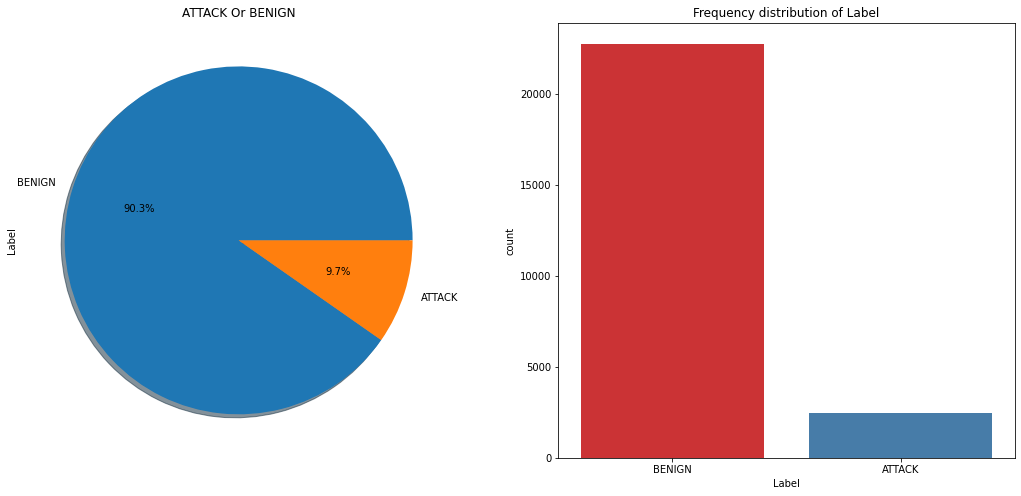

In [ ]:
# visualize frequency distribution of Lable 

f,ax=plt.subplots(1,2,figsize=(18,8))

ax[0] = df['Label'].value_counts().plot.pie(explode=[0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('ATTACK Or BENIGN')


#f, ax = plt.subplots(figsize=(6, 8))
ax[1] = sns.countplot(x="Label", data=df, palette="Set1")
ax[1].set_title("Frequency distribution of Label")

plt.show()

In [ ]:
encoder = LabelEncoder()
df["Label"] = encoder.fit_transform(df["Label"])

In [ ]:
df.shape

(25191, 79)

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(),inplace= True)


In [ ]:
df_copy= df.copy()

In [ ]:
df_copy.columns = df_copy.columns.str.strip()
df_copy.sort_index(inplace=True)

In [ ]:
X_original = df_copy.drop(['Label'], axis=1)

y_original = df_copy['Label']

In [ ]:
X_original.shape

(25191, 78)

In [ ]:
columns = df_copy.columns

In [ ]:
columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

# Fitting the two algorithms on the origrinal dataset

In [ ]:
RF_ada = RandomForestClassifier(n_estimators=10,random_state=0).fit(X_original, y_original)
RF_static = RandomForestClassifier(n_estimators=10,random_state=0).fit(X_original, y_original)


# Fitting the two adaptive model into the Kafka Stream 

New Data Distrbution Shape: (25192,)


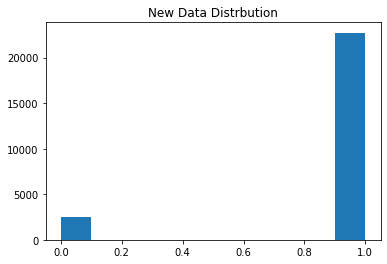

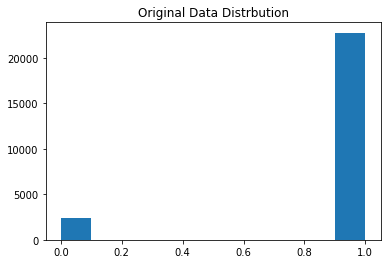

Adaptive model classifier evaluations
First 1000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969960611055654
recall score for incoming streams: 0.9988938053097345
precision score for incoming streams: 0.9977900552486187
ROC score for incoming data: 0.9891376243043517
####################################
Static model classifier evaluations
First 1000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969960611055654
recall score for incoming streams: 0.9988938053097345
precision score for incoming streams: 0.9977900552486187
ROC score for incoming data: 0.9891376243043517
####################################
New Data Distrbution Shape: (25192,)


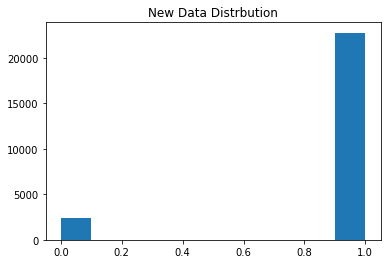

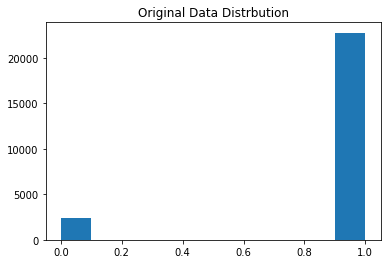

Adaptive model classifier evaluations
First 2000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989983507474668
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9989082969432315
ROC score for incoming data: 0.9941860465116279
####################################
Static model classifier evaluations
First 2000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989983507474668
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9989082969432315
ROC score for incoming data: 0.9941860465116279
####################################
New Data Distrbution Shape: (25192,)


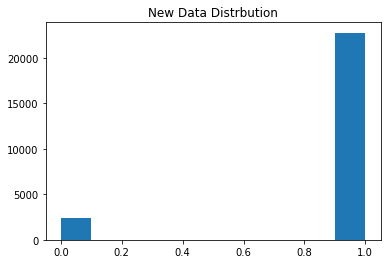

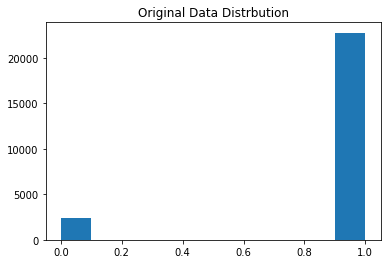

Adaptive model classifier evaluations
First 3000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989986596298808
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988962472406181
ROC score for incoming data: 0.9947916666666667
####################################
Static model classifier evaluations
First 3000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969959788896421
recall score for incoming streams: 0.9988950276243094
precision score for incoming streams: 0.9977924944812362
ROC score for incoming data: 0.989030847145488
####################################
New Data Distrbution Shape: (25192,)


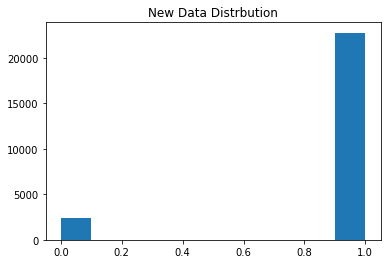

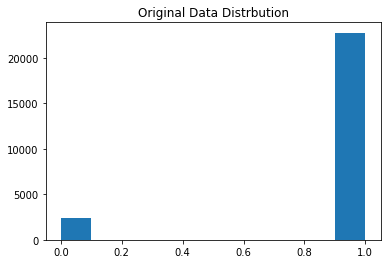

Adaptive model classifier evaluations
First 4000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949718790412599
recall score for incoming streams: 0.9988876529477196
precision score for incoming streams: 0.9955654101995566
ROC score for incoming data: 0.979835983336605
####################################
Static model classifier evaluations
First 4000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979932169041079
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977802441731409
ROC score for incoming data: 0.9901960784313725
####################################
New Data Distrbution Shape: (25192,)


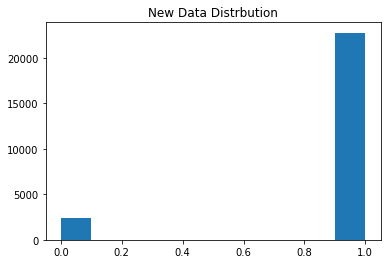

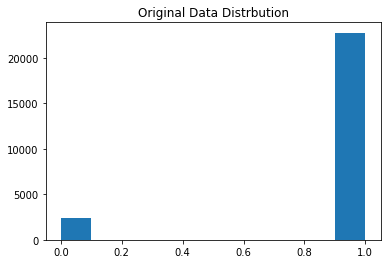

Adaptive model classifier evaluations
First 5000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9970262250065205
recall score for incoming streams: 0.9967213114754099
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9983606557377049
####################################
Static model classifier evaluations
First 5000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9970108395603866
recall score for incoming streams: 0.9978142076502732
precision score for incoming streams: 0.9989059080962801
ROC score for incoming data: 0.9930931503367645
####################################
New Data Distrbution Shape: (25192,)


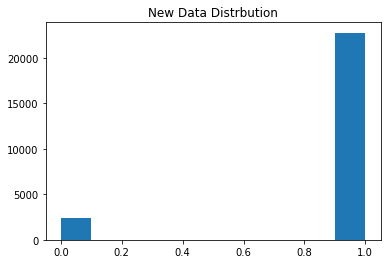

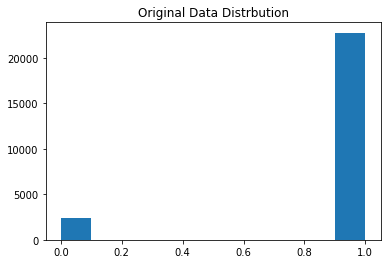

Adaptive model classifier evaluations
First 6000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.997993689666505
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977678571428571
ROC score for incoming data: 0.9906542056074766
####################################
Static model classifier evaluations
First 6000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.9939555979734551
recall score for incoming streams: 0.9988814317673378
precision score for incoming streams: 0.9944320712694877
ROC score for incoming data: 0.9760762299023604
####################################
New Data Distrbution Shape: (25192,)


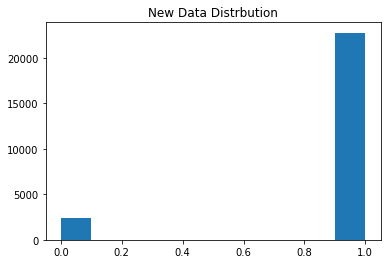

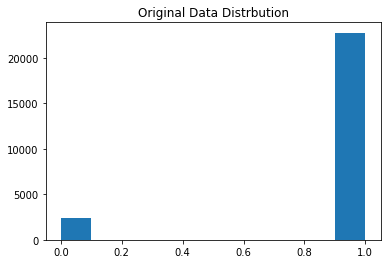

Adaptive model classifier evaluations
First 7000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969960611055654
recall score for incoming streams: 0.9988938053097345
precision score for incoming streams: 0.9977900552486187
ROC score for incoming data: 0.9891376243043517
####################################
Static model classifier evaluations
First 7000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949934351759423
recall score for incoming streams: 0.9977876106194691
precision score for incoming streams: 0.9966850828729282
ROC score for incoming data: 0.9834298877839613
####################################
New Data Distrbution Shape: (25192,)


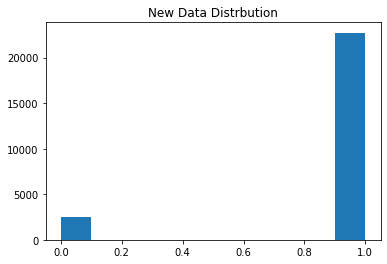

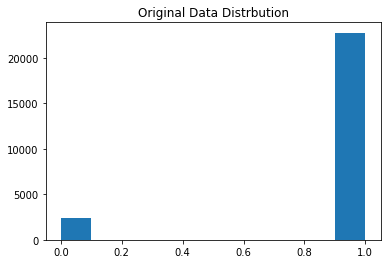

Adaptive model classifier evaluations
First 8000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.9939350961822873
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9932810750279956
ROC score for incoming data: 0.9736842105263158
####################################
Static model classifier evaluations
First 8000 Evaluation
Model accuracy score for incoming stream: 0.9920079920079921
F1 score for incoming streams: 0.9918806221836525
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9910614525139665
ROC score for incoming data: 0.9649122807017544
####################################
New Data Distrbution Shape: (25192,)


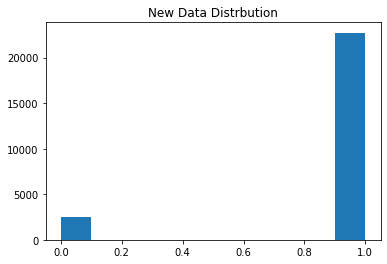

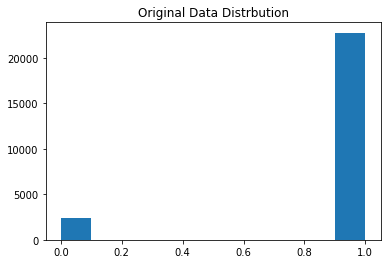

Adaptive model classifier evaluations
First 9000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9980102170091508
recall score for incoming streams: 0.9977653631284916
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9988826815642458
####################################
Static model classifier evaluations
First 9000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9950555453401754
recall score for incoming streams: 0.994413407821229
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9972067039106145
####################################
New Data Distrbution Shape: (25192,)


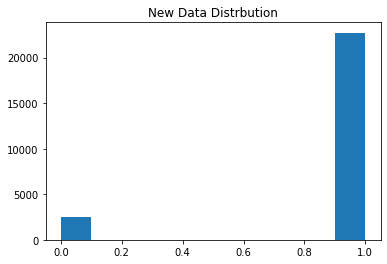

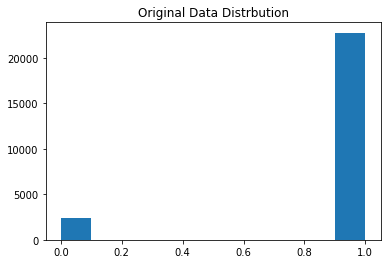

Adaptive model classifier evaluations
First 10000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9960223837835371
recall score for incoming streams: 0.9966850828729282
precision score for incoming streams: 0.9988925802879292
ROC score for incoming data: 0.9931342081031309
####################################
Static model classifier evaluations
First 10000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9960223837835371
recall score for incoming streams: 0.9966850828729282
precision score for incoming streams: 0.9988925802879292
ROC score for incoming data: 0.9931342081031309
####################################
New Data Distrbution Shape: (25192,)


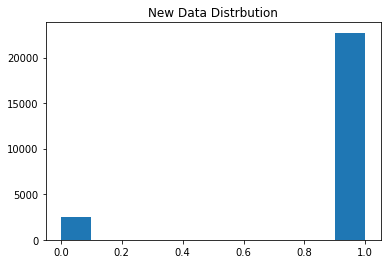

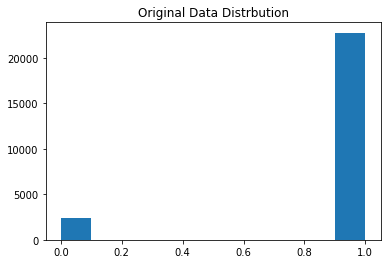

Adaptive model classifier evaluations
First 11000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989988403767466
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988876529477196
ROC score for incoming data: 0.9951456310679612
####################################
Static model classifier evaluations
First 11000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988864142538976
precision score for incoming streams: 0.9988864142538976
ROC score for incoming data: 0.99458883819491
####################################
New Data Distrbution Shape: (25192,)


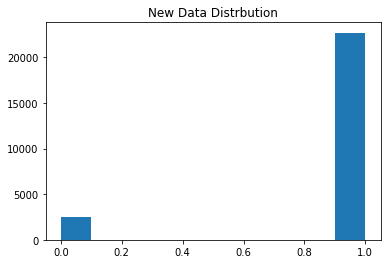

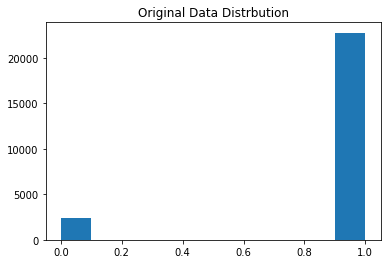

Adaptive model classifier evaluations
First 12000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959877333897491
recall score for incoming streams: 0.9988789237668162
precision score for incoming streams: 0.9966442953020134
ROC score for incoming data: 0.9856779939934998
####################################
Static model classifier evaluations
First 12000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969846033509963
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9966480446927374
ROC score for incoming data: 0.9862385321100917
####################################
New Data Distrbution Shape: (25192,)


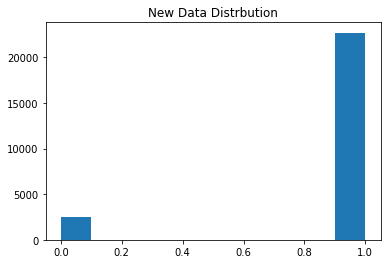

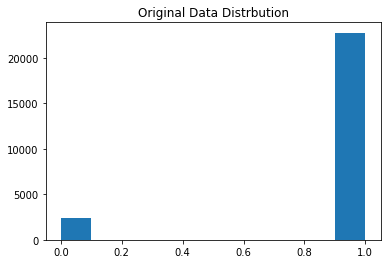

Adaptive model classifier evaluations
First 13000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.997992584852118
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977949283351709
ROC score for incoming data: 0.9895833333333333
####################################
Static model classifier evaluations
First 13000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988950276243094
precision score for incoming streams: 0.9988950276243094
ROC score for incoming data: 0.9942391804788214
####################################
New Data Distrbution Shape: (25192,)


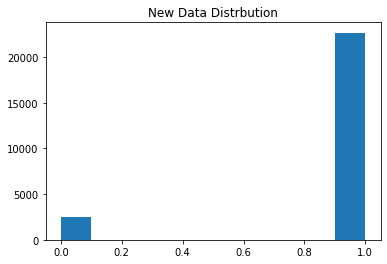

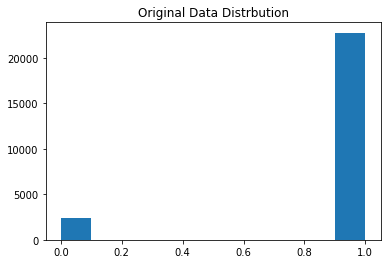

Adaptive model classifier evaluations
First 14000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989989552618879
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988814317673378
ROC score for incoming data: 0.9953703703703703
####################################
Static model classifier evaluations
First 14000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989989552618879
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988814317673378
ROC score for incoming data: 0.9953703703703703
####################################
New Data Distrbution Shape: (25192,)


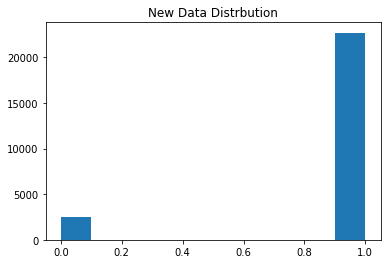

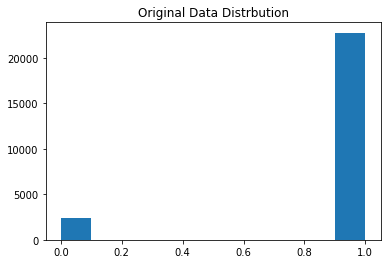

Adaptive model classifier evaluations
First 15000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.996003996003996
recall score for incoming streams: 0.9978189749182116
precision score for incoming streams: 0.9978189749182116
ROC score for incoming data: 0.9870047255543439
####################################
Static model classifier evaluations
First 15000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998012660342483
recall score for incoming streams: 0.9978189749182116
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9989094874591058
####################################
New Data Distrbution Shape: (25192,)


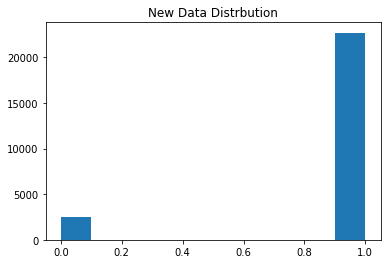

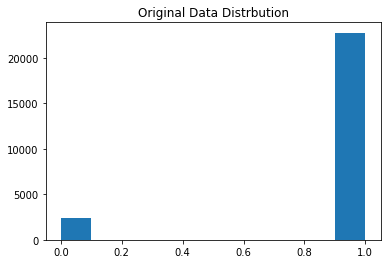

Adaptive model classifier evaluations
First 16000 Evaluation
Model accuracy score for incoming stream: 1.0
F1 score for incoming streams: 1.0
recall score for incoming streams: 1.0
precision score for incoming streams: 1.0
ROC score for incoming data: 1.0
####################################
Static model classifier evaluations
First 16000 Evaluation
Model accuracy score for incoming stream: 1.0
F1 score for incoming streams: 1.0
recall score for incoming streams: 1.0
precision score for incoming streams: 1.0
ROC score for incoming data: 1.0
####################################
New Data Distrbution Shape: (25192,)


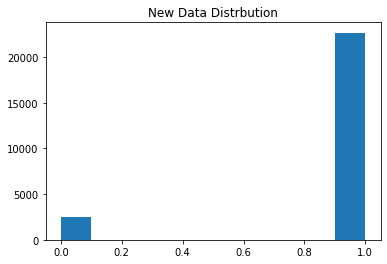

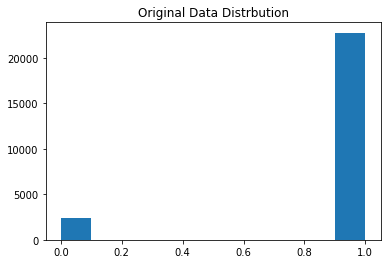

Adaptive model classifier evaluations
First 17000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969967317844143
recall score for incoming streams: 0.9988826815642458
precision score for incoming streams: 0.9977678571428571
ROC score for incoming data: 0.9900073785179719
####################################
Static model classifier evaluations
First 17000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969967317844143
recall score for incoming streams: 0.9988826815642458
precision score for incoming streams: 0.9977678571428571
ROC score for incoming data: 0.9900073785179719
####################################
New Data Distrbution Shape: (25192,)


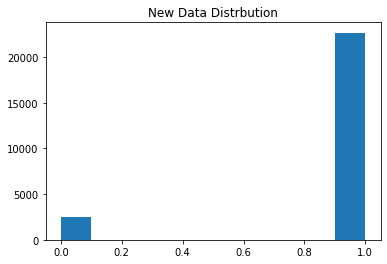

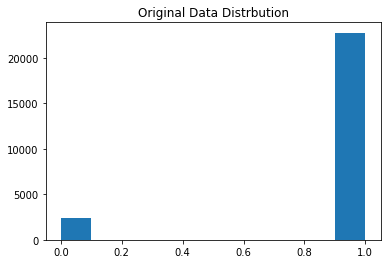

Adaptive model classifier evaluations
First 18000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.994005994005994
recall score for incoming streams: 0.9966960352422908
precision score for incoming streams: 0.9966960352422908
ROC score for incoming data: 0.9822189853630809
####################################
Static model classifier evaluations
First 18000 Evaluation
Model accuracy score for incoming stream: 0.993006993006993
F1 score for incoming streams: 0.9929900173158291
recall score for incoming streams: 0.9966960352422908
precision score for incoming streams: 0.9955995599559956
ROC score for incoming data: 0.9768426412770594
####################################
New Data Distrbution Shape: (25192,)


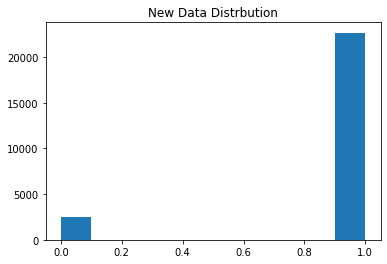

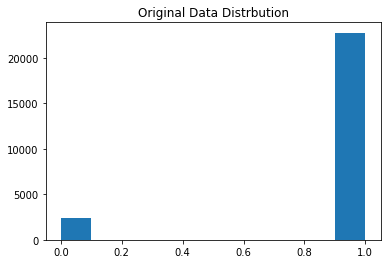

Adaptive model classifier evaluations
First 19000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949485249062001
recall score for incoming streams: 1.0
precision score for incoming streams: 0.994475138121547
ROC score for incoming data: 0.9752475247524752
####################################
Static model classifier evaluations
First 19000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959680624869095
recall score for incoming streams: 1.0
precision score for incoming streams: 0.995575221238938
ROC score for incoming data: 0.9801980198019802
####################################
New Data Distrbution Shape: (25192,)


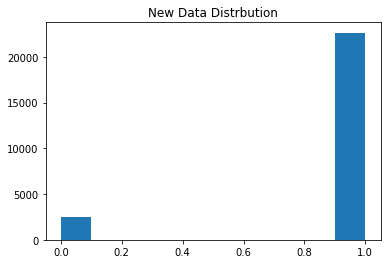

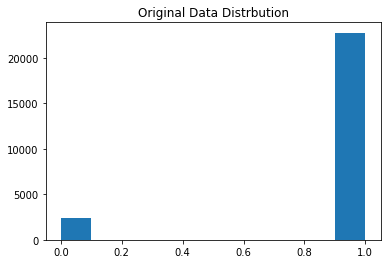

Adaptive model classifier evaluations
First 20000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989990995022805
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988726042841037
ROC score for incoming data: 0.9956521739130435
####################################
Static model classifier evaluations
First 20000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979943611047866
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977477477477478
ROC score for incoming data: 0.9913043478260869
####################################
New Data Distrbution Shape: (25192,)


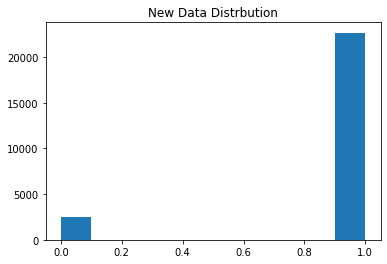

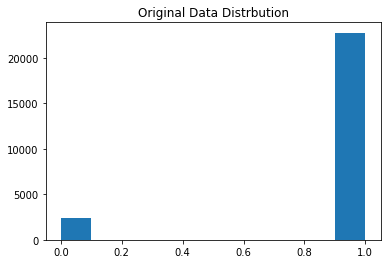

Adaptive model classifier evaluations
First 21000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.996003996003996
recall score for incoming streams: 0.9978142076502732
precision score for incoming streams: 0.9978142076502732
ROC score for incoming data: 0.9872791968483924
####################################
Static model classifier evaluations
First 21000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9950437083442011
recall score for incoming streams: 0.9956284153005465
precision score for incoming streams: 0.9989035087719298
ROC score for incoming data: 0.9920002541619011
####################################
New Data Distrbution Shape: (25192,)


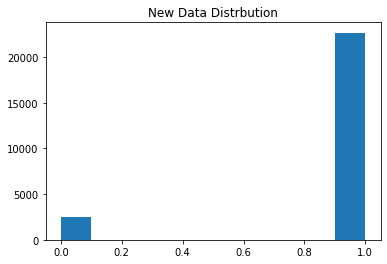

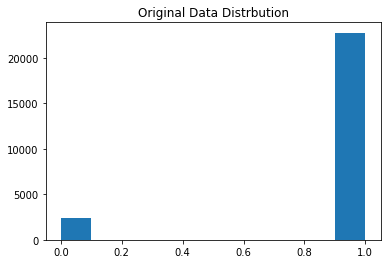

Adaptive model classifier evaluations
First 22000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9950166918605865
recall score for incoming streams: 0.9966887417218543
precision score for incoming streams: 0.9977900552486187
ROC score for incoming data: 0.9878180550714535
####################################
Static model classifier evaluations
First 22000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.9939774152985817
recall score for incoming streams: 0.9977924944812362
precision score for incoming streams: 0.9955947136563876
ROC score for incoming data: 0.9778436156616707
####################################
New Data Distrbution Shape: (25192,)


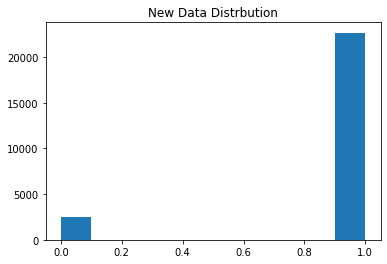

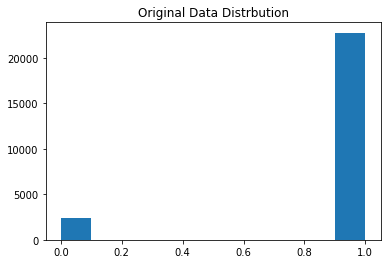

Adaptive model classifier evaluations
First 23000 Evaluation
Model accuracy score for incoming stream: 0.993006993006993
F1 score for incoming streams: 0.9930207069628874
recall score for incoming streams: 0.9955056179775281
precision score for incoming streams: 0.9966254218222722
ROC score for incoming data: 0.9842392954752507
####################################
Static model classifier evaluations
First 23000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.997008874412666
recall score for incoming streams: 0.9977528089887641
precision score for incoming streams: 0.9988751406074241
ROC score for incoming data: 0.9943718999898775
####################################
New Data Distrbution Shape: (25192,)


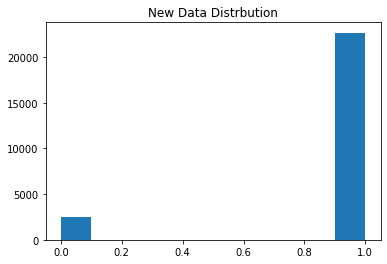

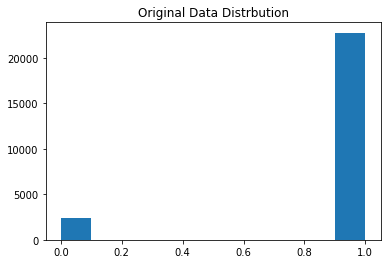

Adaptive model classifier evaluations
First 24000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949934351759423
recall score for incoming streams: 0.9977876106194691
precision score for incoming streams: 0.9966850828729282
ROC score for incoming data: 0.9834298877839613
####################################
Static model classifier evaluations
First 24000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988938053097345
precision score for incoming streams: 0.9988938053097345
ROC score for incoming data: 0.9942922634796095
####################################
New Data Distrbution Shape: (25192,)


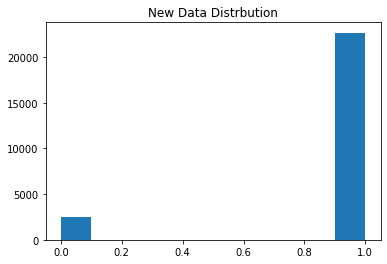

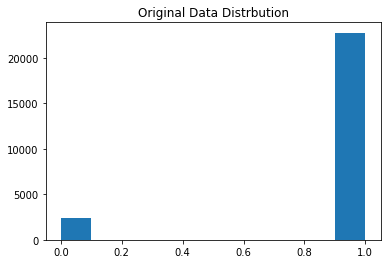

Adaptive model classifier evaluations
First 25000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988801791713325
precision score for incoming streams: 0.9988801791713325
ROC score for incoming data: 0.9948104599560367
####################################
Static model classifier evaluations
First 25000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989989552618879
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988814317673378
ROC score for incoming data: 0.9953703703703703
####################################
New Data Distrbution Shape: (25192,)


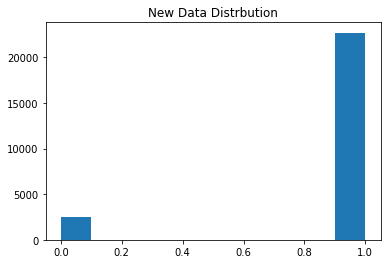

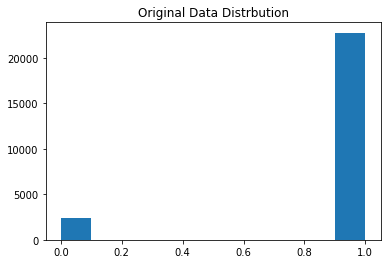

Adaptive model classifier evaluations
First 26000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969797689994734
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9967213114754099
ROC score for incoming data: 0.9831460674157304
####################################
Static model classifier evaluations
First 26000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949922533159126
recall score for incoming streams: 0.9978070175438597
precision score for incoming streams: 0.9967141292442497
ROC score for incoming data: 0.9820495761876601
####################################
New Data Distrbution Shape: (25193,)


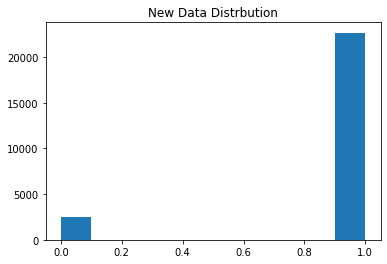

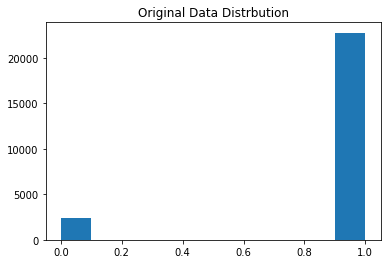

Adaptive model classifier evaluations
First 27000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.996003996003996
recall score for incoming streams: 0.9977426636568849
precision score for incoming streams: 0.9977426636568849
ROC score for incoming data: 0.9901756796545295
####################################
Static model classifier evaluations
First 27000 Evaluation
Model accuracy score for incoming stream: 0.993006993006993
F1 score for incoming streams: 0.9929936965159629
recall score for incoming streams: 0.9966139954853274
precision score for incoming streams: 0.9954904171364148
ROC score for incoming data: 0.9809156933948376
####################################
New Data Distrbution Shape: (25194,)


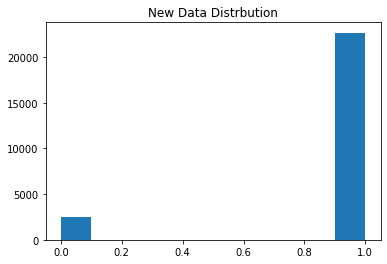

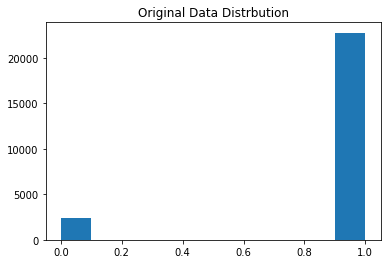

Adaptive model classifier evaluations
First 28000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989986316516929
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988974641675854
ROC score for incoming data: 0.9947368421052631
####################################
Static model classifier evaluations
First 28000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9990033383721173
recall score for incoming streams: 0.9988962472406181
precision score for incoming streams: 1.0
ROC score for incoming data: 0.999448123620309
####################################
New Data Distrbution Shape: (25195,)


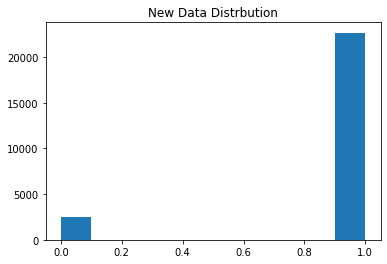

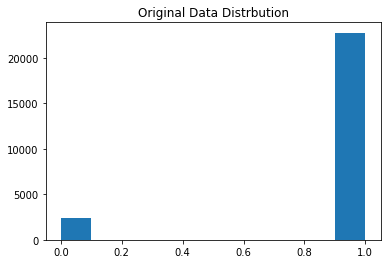

Adaptive model classifier evaluations
First 29000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988901220865705
precision score for incoming streams: 0.9988901220865705
ROC score for incoming data: 0.9944450610432851
####################################
Static model classifier evaluations
First 29000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979930146227263
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977851605758582
ROC score for incoming data: 0.99
####################################
New Data Distrbution Shape: (25196,)


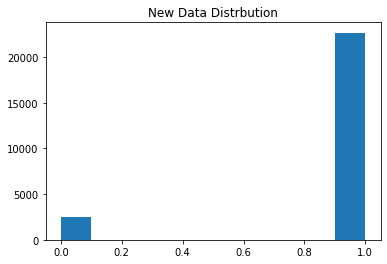

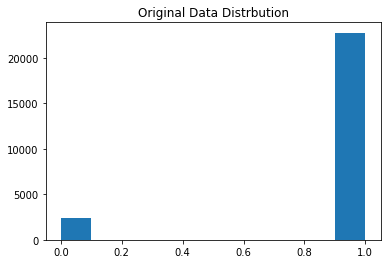

Adaptive model classifier evaluations
First 30000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9960207946815088
recall score for incoming streams: 0.9966555183946488
precision score for incoming streams: 0.9988826815642458
ROC score for incoming data: 0.9935200668896321
####################################
Static model classifier evaluations
First 30000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.994005994005994
recall score for incoming streams: 0.9966555183946488
precision score for incoming streams: 0.9966555183946488
ROC score for incoming data: 0.9839046822742475
####################################
New Data Distrbution Shape: (25197,)


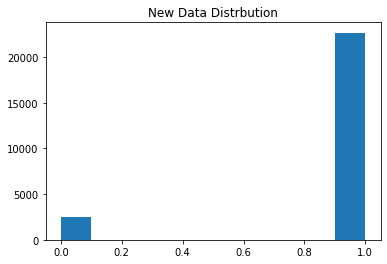

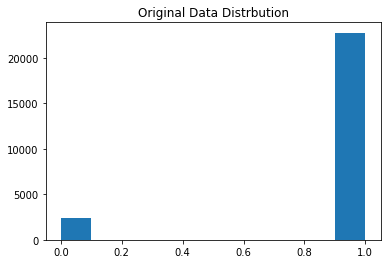

Adaptive model classifier evaluations
First 31000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.994005994005994
recall score for incoming streams: 0.9967032967032967
precision score for incoming streams: 0.9967032967032967
ROC score for incoming data: 0.9818681318681318
####################################
Static model classifier evaluations
First 31000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969955408895219
recall score for incoming streams: 0.9989010989010989
precision score for incoming streams: 0.9978046103183315
ROC score for incoming data: 0.9884615384615384
####################################
New Data Distrbution Shape: (25198,)


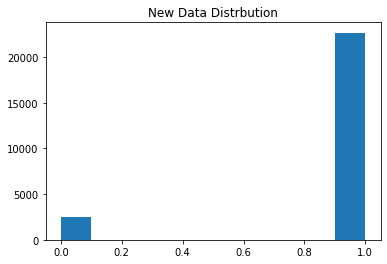

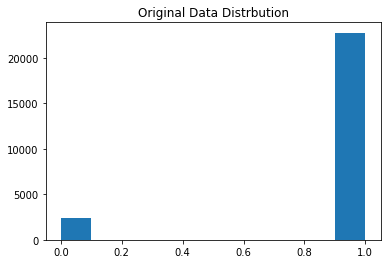

Adaptive model classifier evaluations
First 32000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988888888888889
precision score for incoming streams: 0.9988888888888889
ROC score for incoming data: 0.9944939493949395
####################################
Static model classifier evaluations
First 32000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959862335223045
recall score for incoming streams: 0.9988888888888889
precision score for incoming streams: 0.9966740576496674
ROC score for incoming data: 0.9845929592959296
####################################
New Data Distrbution Shape: (25199,)


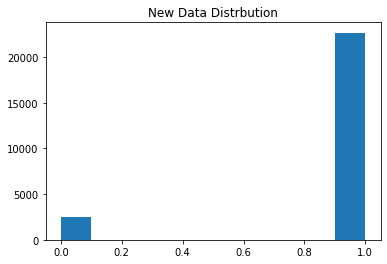

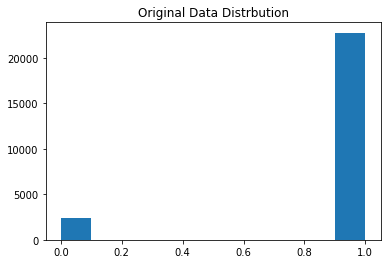

Adaptive model classifier evaluations
First 33000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.9939444454778518
recall score for incoming streams: 0.9989023051591658
precision score for incoming streams: 0.994535519125683
ROC score for incoming data: 0.971673374801805
####################################
Static model classifier evaluations
First 33000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969800619626484
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9967177242888403
ROC score for incoming data: 0.9833333333333334
####################################
New Data Distrbution Shape: (25200,)


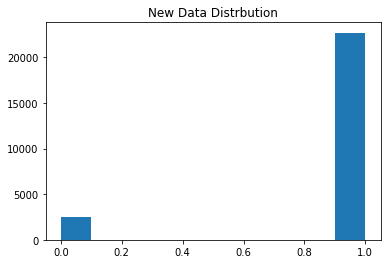

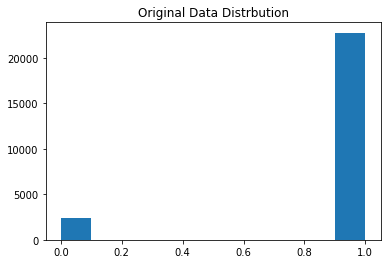

Adaptive model classifier evaluations
First 34000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.9939787312829552
recall score for incoming streams: 0.9977827050997783
precision score for incoming streams: 0.995575221238938
ROC score for incoming data: 0.9786893323478689
####################################
Static model classifier evaluations
First 34000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.994993700985236
recall score for incoming streams: 0.9977827050997783
precision score for incoming streams: 0.9966777408637874
ROC score for incoming data: 0.983739837398374
####################################
New Data Distrbution Shape: (25201,)


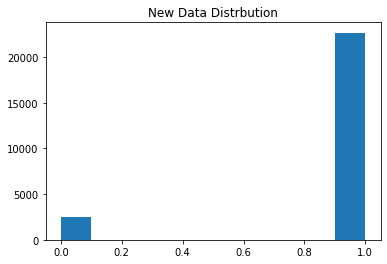

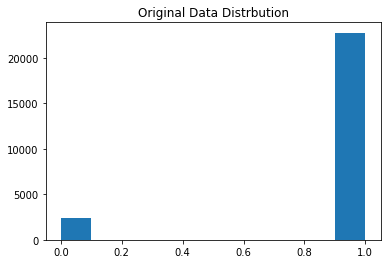

Adaptive model classifier evaluations
First 35000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989989552618879
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988814317673378
ROC score for incoming data: 0.9953703703703703
####################################
Static model classifier evaluations
First 35000 Evaluation
Model accuracy score for incoming stream: 1.0
F1 score for incoming streams: 1.0
recall score for incoming streams: 1.0
precision score for incoming streams: 1.0
ROC score for incoming data: 1.0
####################################
New Data Distrbution Shape: (25202,)


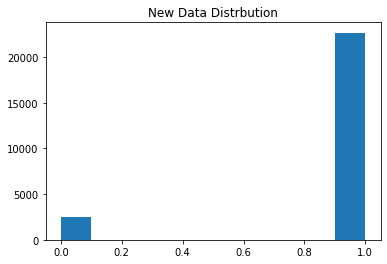

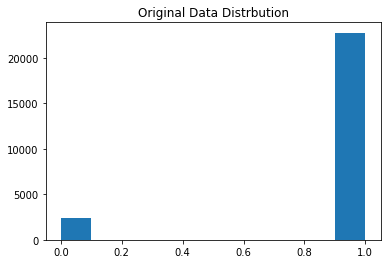

Adaptive model classifier evaluations
First 36000 Evaluation
Model accuracy score for incoming stream: 0.991008991008991
F1 score for incoming streams: 0.9909920683494934
recall score for incoming streams: 0.9954802259887006
precision score for incoming streams: 0.9943566591422122
ROC score for incoming data: 0.9761883888564192
####################################
Static model classifier evaluations
First 36000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.9939833157322605
recall score for incoming streams: 0.9977401129943503
precision score for incoming streams: 0.9954904171364148
ROC score for incoming data: 0.9816286771868303
####################################
New Data Distrbution Shape: (25203,)


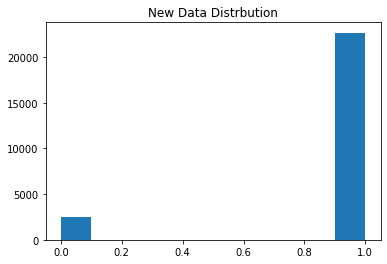

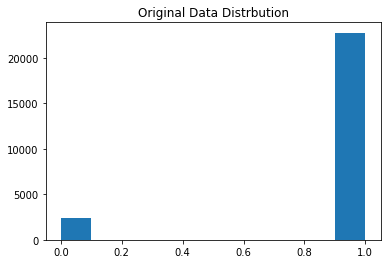

Adaptive model classifier evaluations
First 37000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979928041122275
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977900552486187
ROC score for incoming data: 0.9897959183673469
####################################
Static model classifier evaluations
First 37000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969821893107021
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9966887417218543
ROC score for incoming data: 0.9846938775510203
####################################
New Data Distrbution Shape: (25204,)


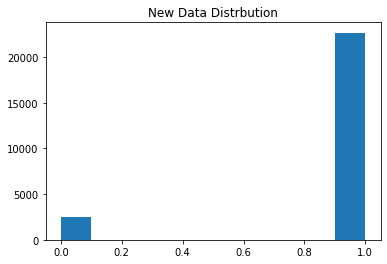

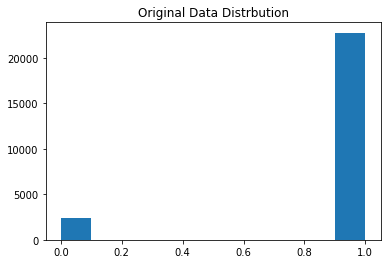

Adaptive model classifier evaluations
First 38000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9990033109668095
recall score for incoming streams: 0.9988950276243094
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9994475138121547
####################################
Static model classifier evaluations
First 38000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969959788896421
recall score for incoming streams: 0.9988950276243094
precision score for incoming streams: 0.9977924944812362
ROC score for incoming data: 0.989030847145488
####################################
New Data Distrbution Shape: (25205,)


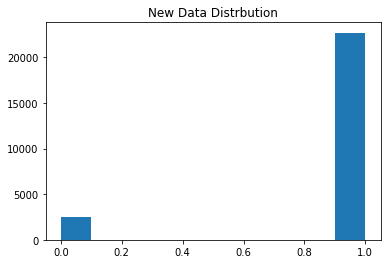

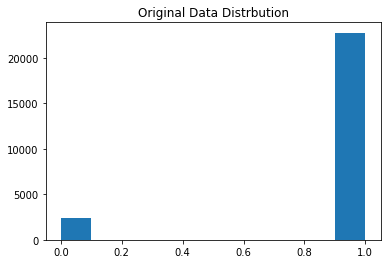

Adaptive model classifier evaluations
First 39000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959853912201978
recall score for incoming streams: 0.9988938053097345
precision score for incoming streams: 0.9966887417218543
ROC score for incoming data: 0.9839829851290941
####################################
Static model classifier evaluations
First 39000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979926956100988
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977924944812362
ROC score for incoming data: 0.9896907216494845
####################################
New Data Distrbution Shape: (25206,)


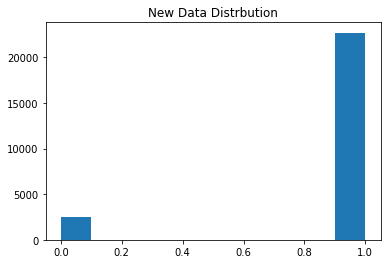

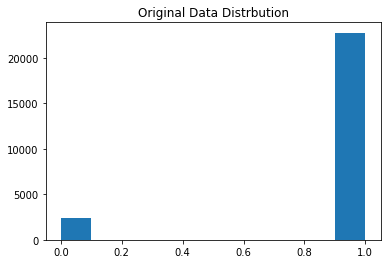

Adaptive model classifier evaluations
First 40000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989984824945921
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9989035087719298
ROC score for incoming data: 0.9944444444444445
####################################
Static model classifier evaluations
First 40000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9990034843721574
recall score for incoming streams: 0.9989023051591658
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9994511525795828
####################################
New Data Distrbution Shape: (25207,)


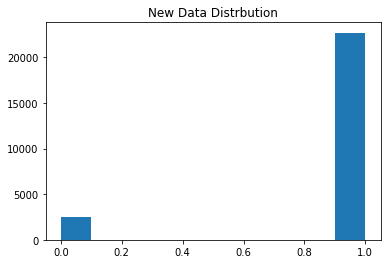

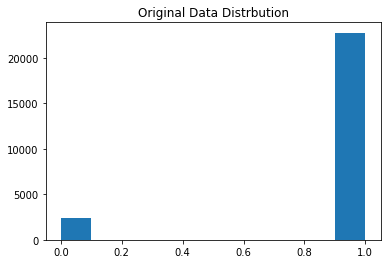

Adaptive model classifier evaluations
First 41000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.995047462515521
recall score for incoming streams: 0.9956616052060737
precision score for incoming streams: 0.998911860718172
ROC score for incoming data: 0.9915016886789862
####################################
Static model classifier evaluations
First 41000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9960268016456941
recall score for incoming streams: 0.9967462039045553
precision score for incoming streams: 0.9989130434782608
ROC score for incoming data: 0.9920439880282271
####################################
New Data Distrbution Shape: (25208,)


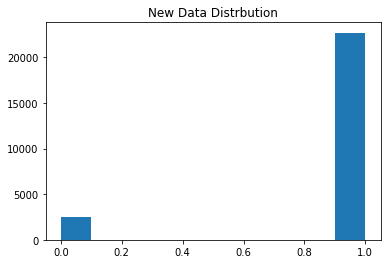

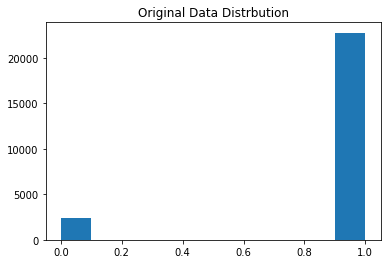

Adaptive model classifier evaluations
First 42000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969971802723631
recall score for incoming streams: 0.9988738738738738
precision score for incoming streams: 0.9977502812148481
ROC score for incoming data: 0.990587379414813
####################################
Static model classifier evaluations
First 42000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.9939587287901895
recall score for incoming streams: 0.9988738738738738
precision score for incoming streams: 0.9943946188340808
ROC score for incoming data: 0.9773130431316271
####################################
New Data Distrbution Shape: (25209,)


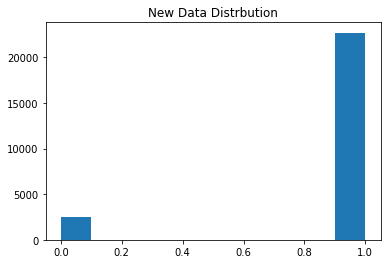

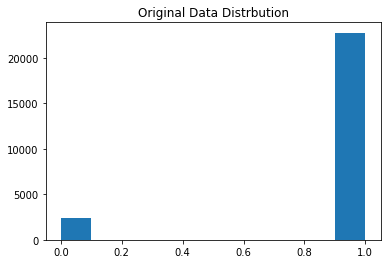

Adaptive model classifier evaluations
First 43000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989988403767466
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988876529477196
ROC score for incoming data: 0.9951456310679612
####################################
Static model classifier evaluations
First 43000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.995968871612436
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9955654101995566
ROC score for incoming data: 0.9805825242718447
####################################
New Data Distrbution Shape: (25210,)


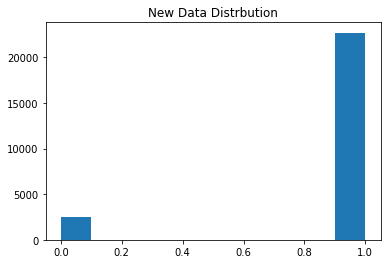

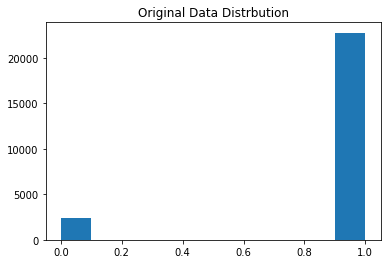

Adaptive model classifier evaluations
First 44000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949935694263308
recall score for incoming streams: 0.9977851605758582
precision score for incoming streams: 0.9966814159292036
ROC score for incoming data: 0.9835864578389496
####################################
Static model classifier evaluations
First 44000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.996003996003996
recall score for incoming streams: 0.9977851605758582
precision score for incoming streams: 0.9977851605758582
ROC score for incoming data: 0.9886884986552761
####################################
New Data Distrbution Shape: (25211,)


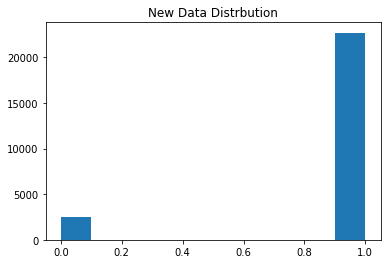

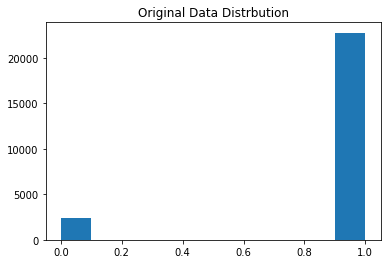

Adaptive model classifier evaluations
First 45000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969831274247561
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9966740576496674
ROC score for incoming data: 0.9852941176470588
####################################
Static model classifier evaluations
First 45000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969831274247561
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9966740576496674
ROC score for incoming data: 0.9852941176470588
####################################
New Data Distrbution Shape: (25212,)


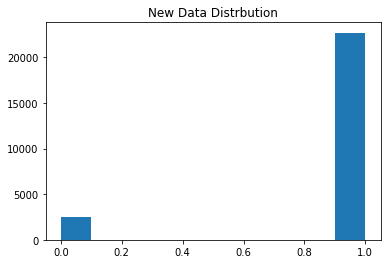

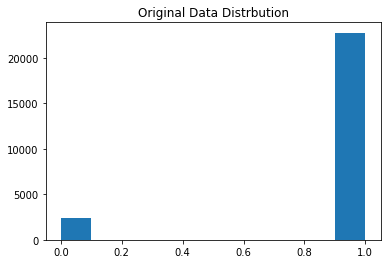

Adaptive model classifier evaluations
First 46000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.996003996003996
recall score for incoming streams: 0.9978021978021978
precision score for incoming streams: 0.9978021978021978
ROC score for incoming data: 0.987912087912088
####################################
Static model classifier evaluations
First 46000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949672474088916
recall score for incoming streams: 0.9989010989010989
precision score for incoming streams: 0.9956188389923329
ROC score for incoming data: 0.9774725274725276
####################################
New Data Distrbution Shape: (25213,)


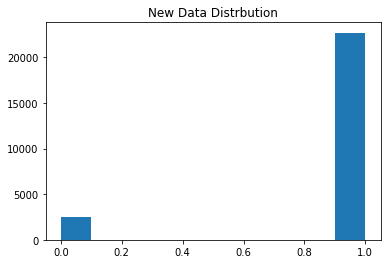

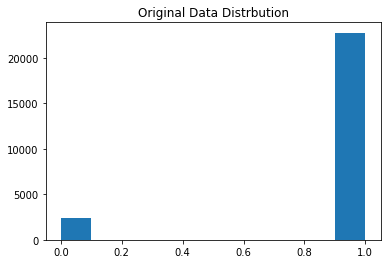

Adaptive model classifier evaluations
First 47000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9960211691351007
recall score for incoming streams: 0.996662958843159
precision score for incoming streams: 0.9988851727982163
ROC score for incoming data: 0.9934295186372658
####################################
Static model classifier evaluations
First 47000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989988160619354
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988888888888889
ROC score for incoming data: 0.9950980392156863
####################################
New Data Distrbution Shape: (25214,)


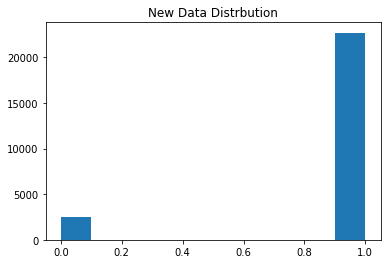

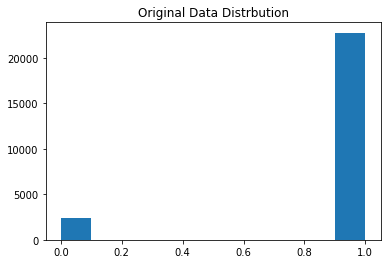

Adaptive model classifier evaluations
First 48000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9990031576252513
recall score for incoming streams: 0.9988876529477196
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9994438264738599
####################################
Static model classifier evaluations
First 48000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.996003996003996
recall score for incoming streams: 0.9977753058954394
precision score for incoming streams: 0.9977753058954394
ROC score for incoming data: 0.9890837313790922
####################################
New Data Distrbution Shape: (25215,)


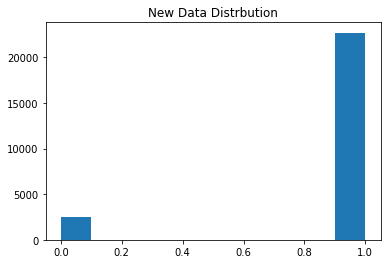

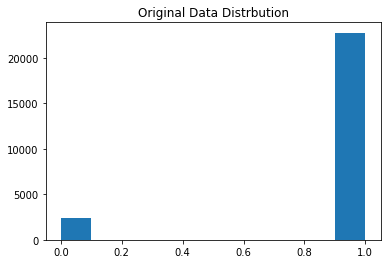

Adaptive model classifier evaluations
First 49000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959866302207467
recall score for incoming streams: 0.9988864142538976
precision score for incoming streams: 0.9966666666666667
ROC score for incoming data: 0.9848801003308323
####################################
Static model classifier evaluations
First 49000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.996003996003996
recall score for incoming streams: 0.9977728285077951
precision score for incoming streams: 0.9977728285077951
ROC score for incoming data: 0.9891776763898199
####################################
New Data Distrbution Shape: (25216,)


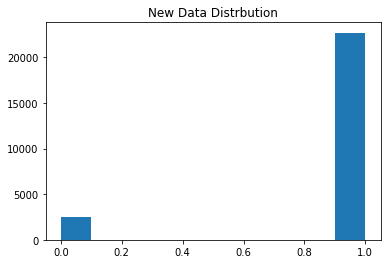

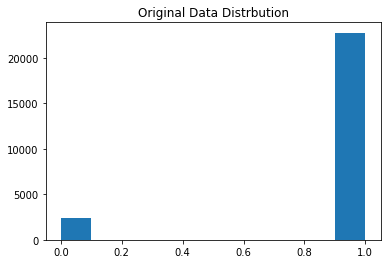

Adaptive model classifier evaluations
First 50000 Evaluation
Model accuracy score for incoming stream: 1.0
F1 score for incoming streams: 1.0
recall score for incoming streams: 1.0
precision score for incoming streams: 1.0
ROC score for incoming data: 1.0
####################################
Static model classifier evaluations
First 50000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988962472406181
precision score for incoming streams: 0.9988962472406181
ROC score for incoming data: 0.994184965725572
####################################
New Data Distrbution Shape: (25217,)


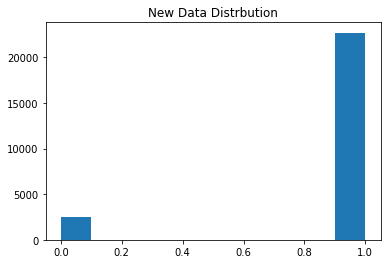

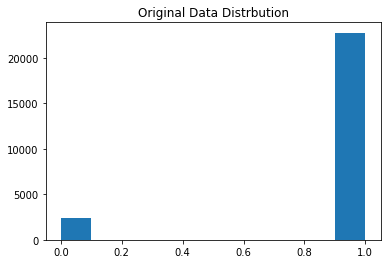

Adaptive model classifier evaluations
First 51000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9990033663503051
recall score for incoming streams: 0.9988974641675854
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9994487320837927
####################################
Static model classifier evaluations
First 51000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.99699580924666
recall score for incoming streams: 0.9988974641675854
precision score for incoming streams: 0.9977973568281938
ROC score for incoming data: 0.9888104342114522
####################################
New Data Distrbution Shape: (25218,)


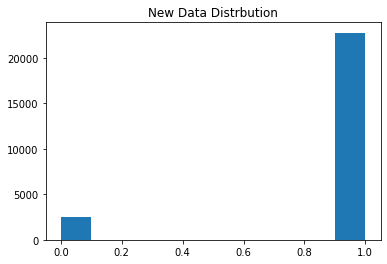

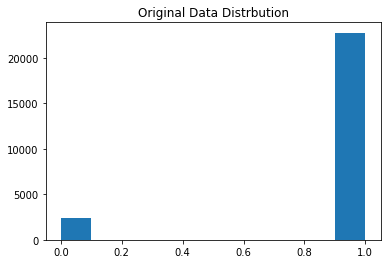

Adaptive model classifier evaluations
First 52000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9950427426010985
recall score for incoming streams: 0.9956188389923329
precision score for incoming streams: 0.9989010989010989
ROC score for incoming data: 0.9921276013143483
####################################
Static model classifier evaluations
First 52000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9960440096554258
recall score for incoming streams: 0.9956188389923329
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9978094194961664
####################################
New Data Distrbution Shape: (25219,)


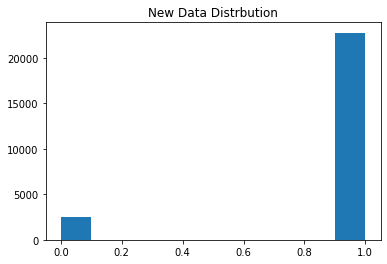

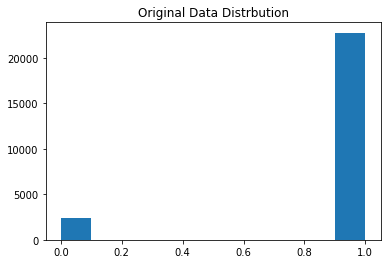

Adaptive model classifier evaluations
First 53000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959823891121601
recall score for incoming streams: 0.9989082969432315
precision score for incoming streams: 0.9967320261437909
ROC score for incoming data: 0.9818070896480864
####################################
Static model classifier evaluations
First 53000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9970109417635936
recall score for incoming streams: 0.9978165938864629
precision score for incoming streams: 0.9989071038251366
ROC score for incoming data: 0.9930259440020551
####################################
New Data Distrbution Shape: (25220,)


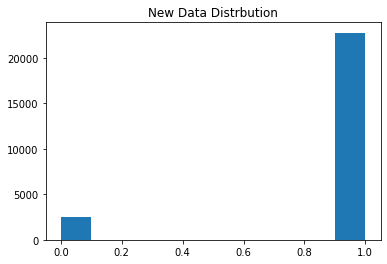

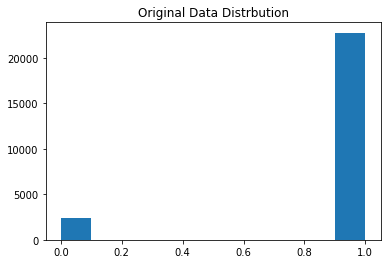

Adaptive model classifier evaluations
First 54000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989988876301144
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988851727982163
ROC score for incoming data: 0.9952380952380953
####################################
Static model classifier evaluations
First 54000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959870118732996
recall score for incoming streams: 0.9988839285714286
precision score for incoming streams: 0.9966592427616926
ROC score for incoming data: 0.98515625
####################################
New Data Distrbution Shape: (25221,)


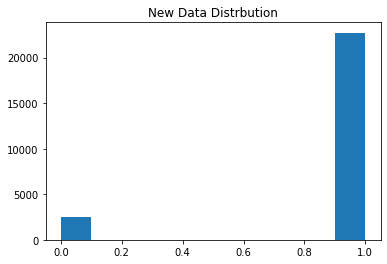

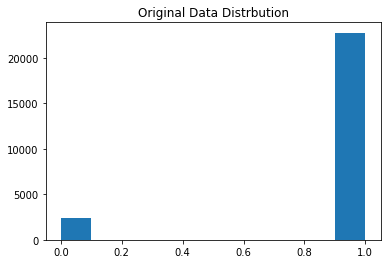

Adaptive model classifier evaluations
First 55000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9990031103718837
recall score for incoming streams: 0.9988851727982163
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9994425863991081
####################################
Static model classifier evaluations
First 55000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979934114364455
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977753058954394
ROC score for incoming data: 0.9903846153846153
####################################
New Data Distrbution Shape: (25222,)


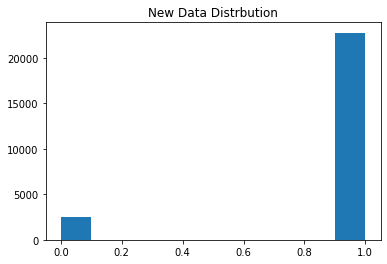

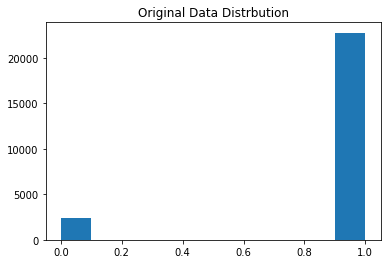

Adaptive model classifier evaluations
First 56000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9990034843721574
recall score for incoming streams: 0.9989023051591658
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9994511525795828
####################################
Static model classifier evaluations
First 56000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949924124729604
recall score for incoming streams: 0.9978046103183315
precision score for incoming streams: 0.9967105263157895
ROC score for incoming data: 0.982235638492499
####################################
New Data Distrbution Shape: (25223,)


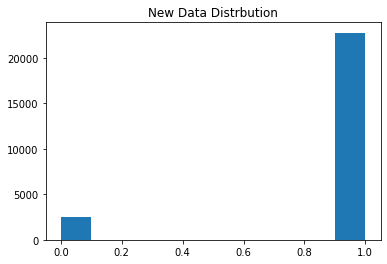

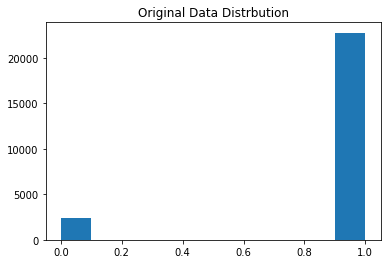

Adaptive model classifier evaluations
First 57000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979926956100988
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977924944812362
ROC score for incoming data: 0.9896907216494845
####################################
Static model classifier evaluations
First 57000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989986870351885
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988950276243094
ROC score for incoming data: 0.9948453608247423
####################################
New Data Distrbution Shape: (25224,)


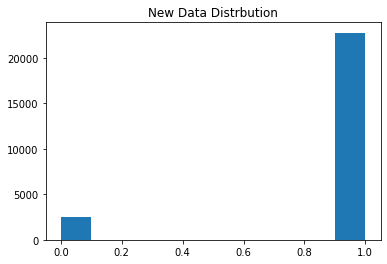

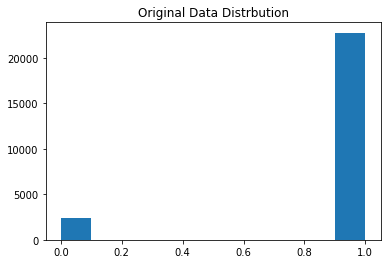

Adaptive model classifier evaluations
First 58000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9989047097480832
precision score for incoming streams: 0.9989047097480832
ROC score for incoming data: 0.9937705366922235
####################################
Static model classifier evaluations
First 58000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9980121273364917
recall score for incoming streams: 0.9978094194961665
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9989047097480832
####################################
New Data Distrbution Shape: (25225,)


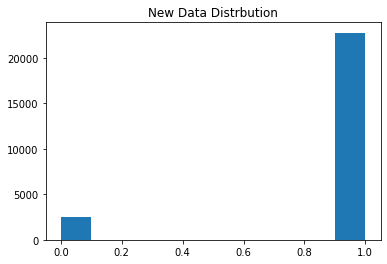

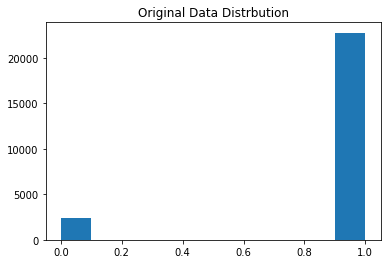

Adaptive model classifier evaluations
First 59000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949544446698148
recall score for incoming streams: 1.0
precision score for incoming streams: 0.994413407821229
ROC score for incoming data: 0.9774774774774775
####################################
Static model classifier evaluations
First 59000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979940373879768
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977578475336323
ROC score for incoming data: 0.990990990990991
####################################
New Data Distrbution Shape: (25226,)


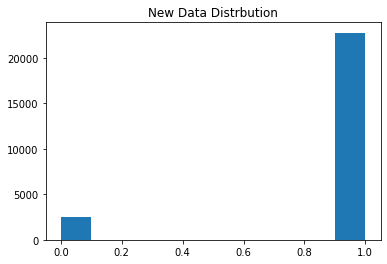

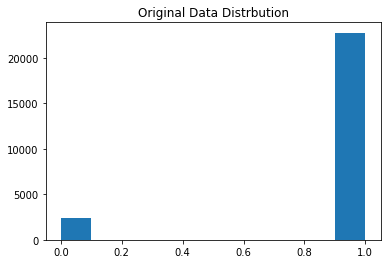

Adaptive model classifier evaluations
First 60000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969816908592418
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9966960352422908
ROC score for incoming data: 0.984375
####################################
Static model classifier evaluations
First 60000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.997992584852118
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977949283351709
ROC score for incoming data: 0.9895833333333333
####################################
New Data Distrbution Shape: (25227,)


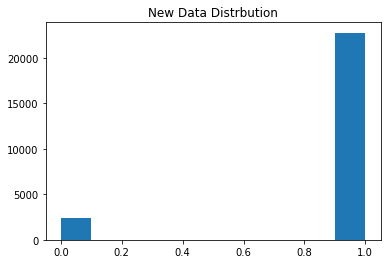

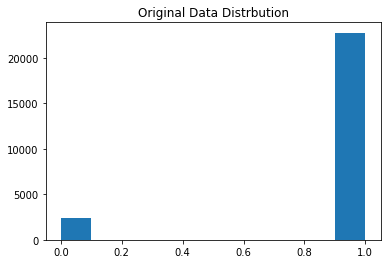

Adaptive model classifier evaluations
First 61000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9970102722992101
recall score for incoming streams: 0.9977997799779978
precision score for incoming streams: 0.998898678414097
ROC score for incoming data: 0.9934651073803031
####################################
Static model classifier evaluations
First 61000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9980116397268592
recall score for incoming streams: 0.9977997799779978
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9988998899889989
####################################
New Data Distrbution Shape: (25228,)


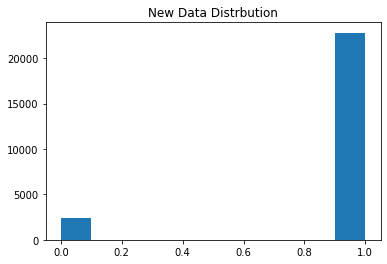

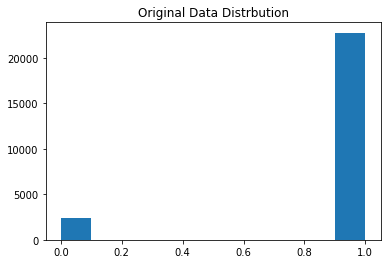

Adaptive model classifier evaluations
First 62000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9960228223037565
recall score for incoming streams: 0.9966923925027563
precision score for incoming streams: 0.9988950276243094
ROC score for incoming data: 0.9930270473152081
####################################
Static model classifier evaluations
First 62000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988974641675854
precision score for incoming streams: 0.9988974641675854
ROC score for incoming data: 0.9941295831476226
####################################
New Data Distrbution Shape: (25229,)


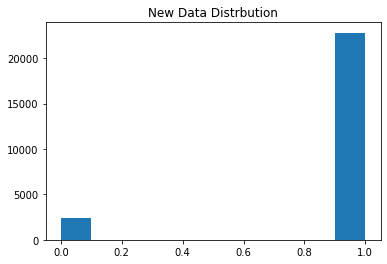

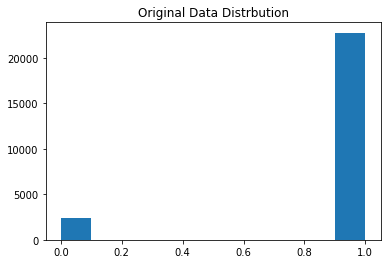

Adaptive model classifier evaluations
First 63000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959624369192013
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9956331877729258
ROC score for incoming data: 0.9775280898876404
####################################
Static model classifier evaluations
First 63000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969953519895476
recall score for incoming streams: 0.9989035087719298
precision score for incoming streams: 0.9978094194961665
ROC score for incoming data: 0.988215799329785
####################################
New Data Distrbution Shape: (25230,)


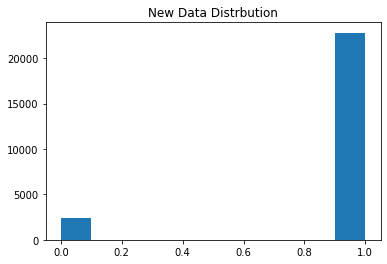

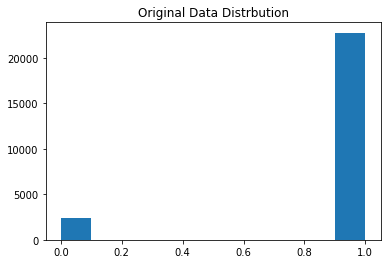

Adaptive model classifier evaluations
First 64000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9970213906549976
recall score for incoming streams: 0.9966480446927374
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9983240223463687
####################################
Static model classifier evaluations
First 64000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989989105948047
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988839285714286
ROC score for incoming data: 0.9952830188679246
####################################
New Data Distrbution Shape: (25231,)


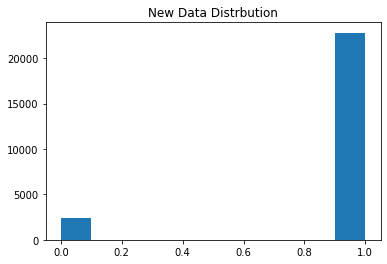

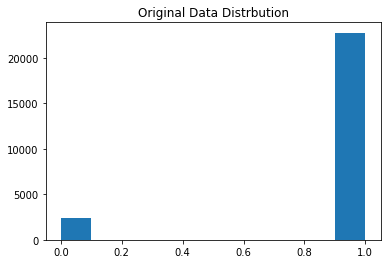

Adaptive model classifier evaluations
First 65000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969953519895476
recall score for incoming streams: 0.9989035087719298
precision score for incoming streams: 0.9978094194961665
ROC score for incoming data: 0.988215799329785
####################################
Static model classifier evaluations
First 65000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9989035087719298
precision score for incoming streams: 0.9989035087719298
ROC score for incoming data: 0.993833776857875
####################################
New Data Distrbution Shape: (25232,)


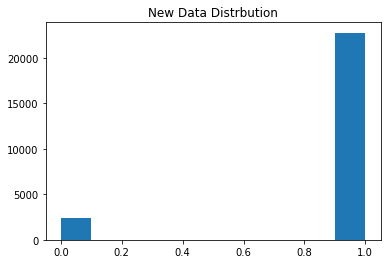

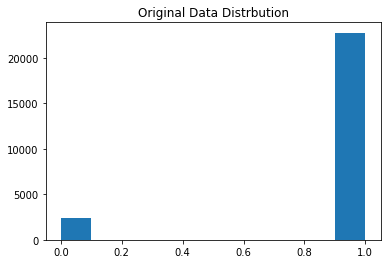

Adaptive model classifier evaluations
First 66000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9989010989010989
precision score for incoming streams: 0.9989010989010989
ROC score for incoming data: 0.993956043956044
####################################
Static model classifier evaluations
First 66000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.996980348445335
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9967141292442497
ROC score for incoming data: 0.9835164835164836
####################################
New Data Distrbution Shape: (25233,)


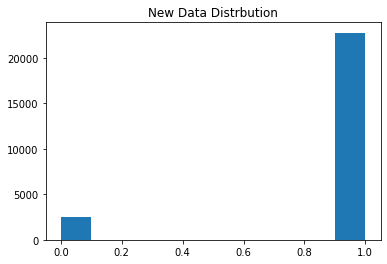

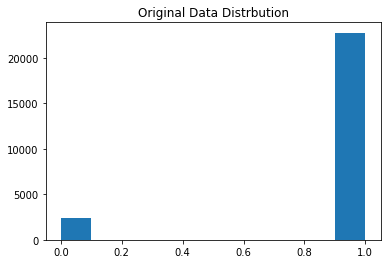

Adaptive model classifier evaluations
First 67000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.999002918034996
recall score for incoming streams: 0.9988738738738738
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9994369369369369
####################################
Static model classifier evaluations
First 67000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9970087541049879
recall score for incoming streams: 0.9977477477477478
precision score for incoming streams: 0.9988726042841037
ROC score for incoming data: 0.9944490951128119
####################################
New Data Distrbution Shape: (25234,)


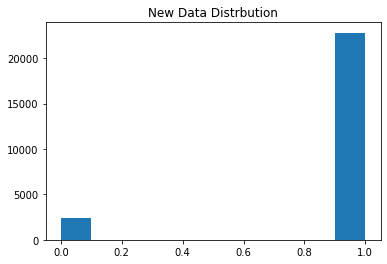

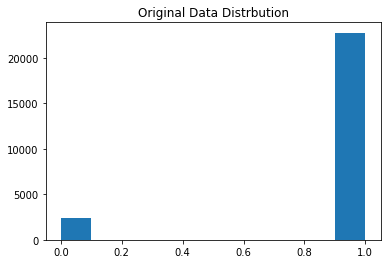

Adaptive model classifier evaluations
First 68000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.994005994005994
recall score for incoming streams: 0.9966996699669967
precision score for incoming streams: 0.9966996699669967
ROC score for incoming data: 0.9820454871574112
####################################
Static model classifier evaluations
First 68000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9950171204986834
recall score for incoming streams: 0.9966996699669967
precision score for incoming streams: 0.9977973568281938
ROC score for incoming data: 0.9874802697661069
####################################
New Data Distrbution Shape: (25235,)


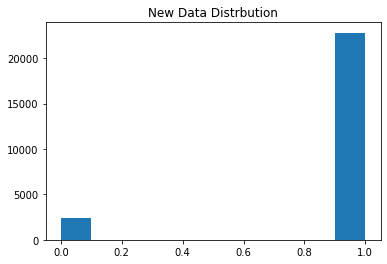

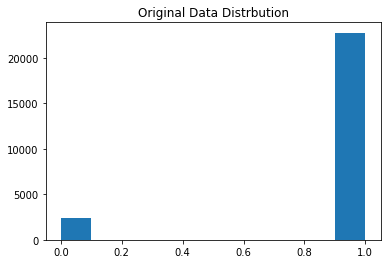

Adaptive model classifier evaluations
First 69000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989985739022614
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988998899889989
ROC score for incoming data: 0.9946236559139785
####################################
Static model classifier evaluations
First 69000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.998898678414097
precision score for incoming streams: 0.998898678414097
ROC score for incoming data: 0.994072995121027
####################################
New Data Distrbution Shape: (25236,)


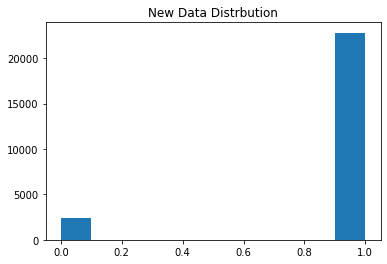

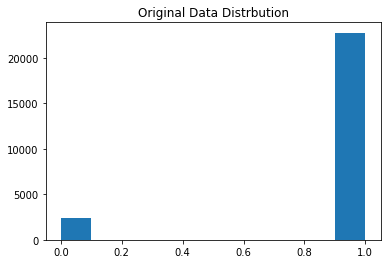

Adaptive model classifier evaluations
First 70000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959864338082158
recall score for incoming streams: 0.9988876529477196
precision score for incoming streams: 0.9966703662597114
ROC score for incoming data: 0.9847379441209186
####################################
Static model classifier evaluations
First 70000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959864338082158
recall score for incoming streams: 0.9988876529477196
precision score for incoming streams: 0.9966703662597114
ROC score for incoming data: 0.9847379441209186
####################################
New Data Distrbution Shape: (25237,)


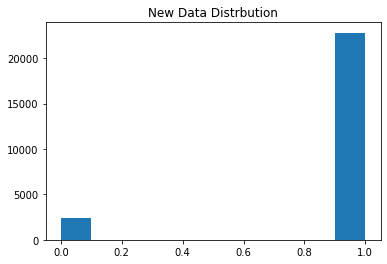

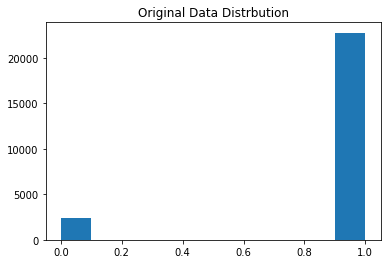

Adaptive model classifier evaluations
First 71000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989988403767466
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988876529477196
ROC score for incoming data: 0.9951456310679612
####################################
Static model classifier evaluations
First 71000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969965211302398
recall score for incoming streams: 0.9988864142538976
precision score for incoming streams: 0.9977753058954394
ROC score for incoming data: 0.9897344692628711
####################################
New Data Distrbution Shape: (25238,)


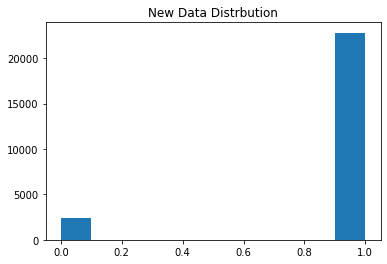

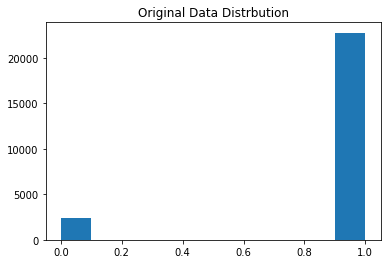

Adaptive model classifier evaluations
First 72000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989988160619354
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988888888888889
ROC score for incoming data: 0.9950980392156863
####################################
Static model classifier evaluations
First 72000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969831274247561
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9966740576496674
ROC score for incoming data: 0.9852941176470588
####################################
New Data Distrbution Shape: (25239,)


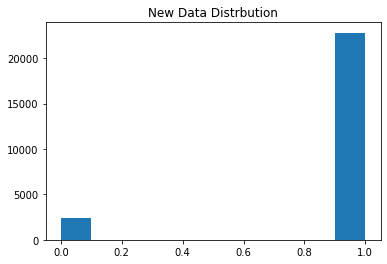

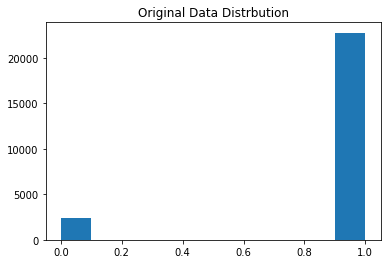

Adaptive model classifier evaluations
First 73000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949450970355199
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9945054945054945
ROC score for incoming data: 0.9739583333333333
####################################
Static model classifier evaluations
First 73000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.997992584852118
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977949283351709
ROC score for incoming data: 0.9895833333333333
####################################
New Data Distrbution Shape: (25240,)


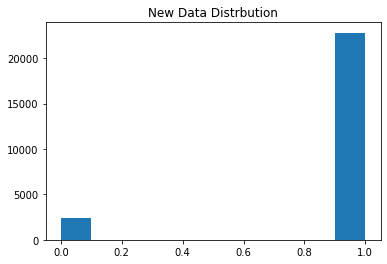

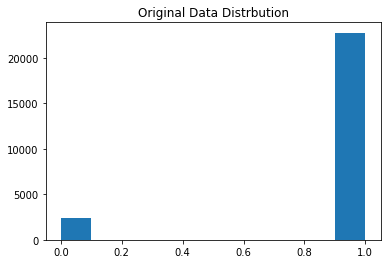

Adaptive model classifier evaluations
First 74000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949931582584645
recall score for incoming streams: 0.9977924944812362
precision score for incoming streams: 0.9966923925027563
ROC score for incoming data: 0.9831067735564075
####################################
Static model classifier evaluations
First 74000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.99496905622331
recall score for incoming streams: 0.9988962472406181
precision score for incoming streams: 0.9955995599559956
ROC score for incoming data: 0.9783954920413617
####################################
New Data Distrbution Shape: (25241,)


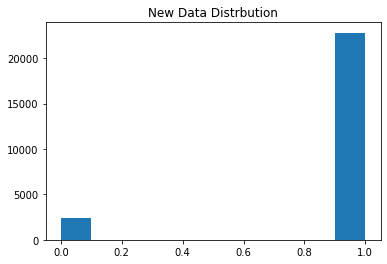

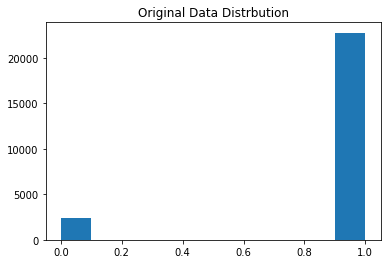

Adaptive model classifier evaluations
First 75000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969851794999597
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9966367713004485
ROC score for incoming data: 0.9866071428571428
####################################
Static model classifier evaluations
First 75000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988751406074241
precision score for incoming streams: 0.9988751406074241
ROC score for incoming data: 0.9949732845894264
####################################
New Data Distrbution Shape: (25242,)


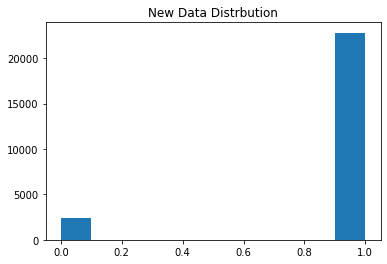

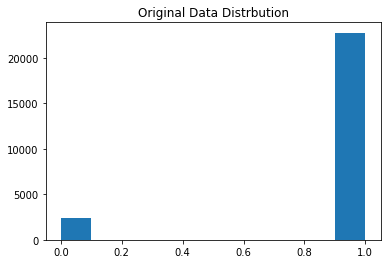

Adaptive model classifier evaluations
First 76000 Evaluation
Model accuracy score for incoming stream: 1.0
F1 score for incoming streams: 1.0
recall score for incoming streams: 1.0
precision score for incoming streams: 1.0
ROC score for incoming data: 1.0
####################################
Static model classifier evaluations
First 76000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.996003996003996
recall score for incoming streams: 0.9977973568281938
precision score for incoming streams: 0.9977973568281938
ROC score for incoming data: 0.988145990242054
####################################
New Data Distrbution Shape: (25243,)


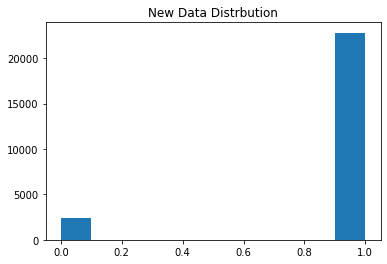

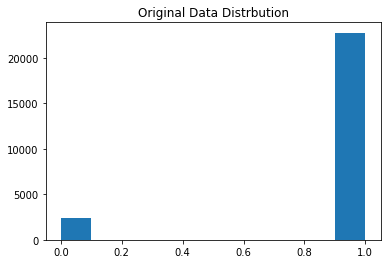

Adaptive model classifier evaluations
First 77000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.996003996003996
recall score for incoming streams: 0.9978118161925602
precision score for incoming streams: 0.9978118161925602
ROC score for incoming data: 0.9874116552227169
####################################
Static model classifier evaluations
First 77000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959829470313648
recall score for incoming streams: 0.9989059080962801
precision score for incoming streams: 0.9967248908296943
ROC score for incoming data: 0.9822115747377953
####################################
New Data Distrbution Shape: (25244,)


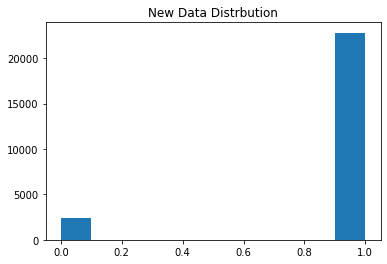

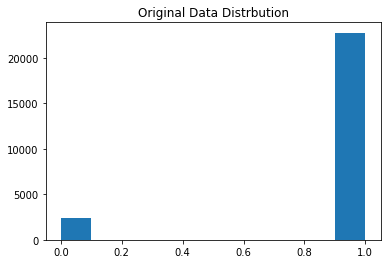

Adaptive model classifier evaluations
First 78000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9970109417635936
recall score for incoming streams: 0.9978165938864629
precision score for incoming streams: 0.9989071038251366
ROC score for incoming data: 0.9930259440020551
####################################
Static model classifier evaluations
First 78000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949642128010187
recall score for incoming streams: 0.9989082969432315
precision score for incoming streams: 0.9956474428726877
ROC score for incoming data: 0.9759247367069097
####################################
New Data Distrbution Shape: (25245,)


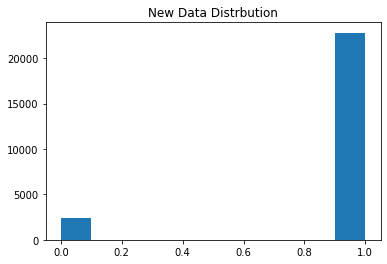

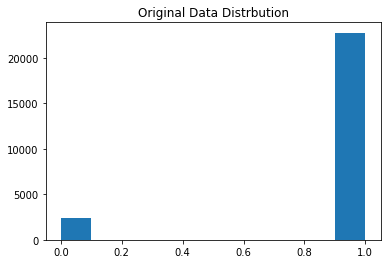

Adaptive model classifier evaluations
First 79000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989988160619354
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988888888888889
ROC score for incoming data: 0.9950980392156863
####################################
Static model classifier evaluations
First 79000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959864338082158
recall score for incoming streams: 0.9988876529477196
precision score for incoming streams: 0.9966703662597114
ROC score for incoming data: 0.9847379441209186
####################################
New Data Distrbution Shape: (25246,)


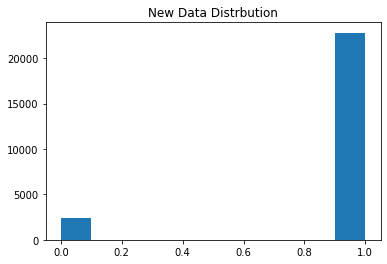

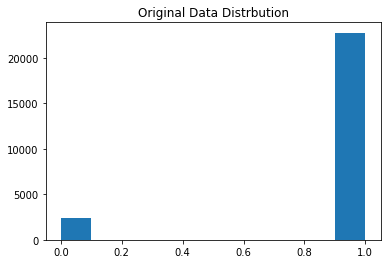

Adaptive model classifier evaluations
First 80000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9949549780525742
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9944071588366891
ROC score for incoming data: 0.9776785714285715
####################################
Static model classifier evaluations
First 80000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969851794999597
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9966367713004485
ROC score for incoming data: 0.9866071428571428
####################################
New Data Distrbution Shape: (25247,)


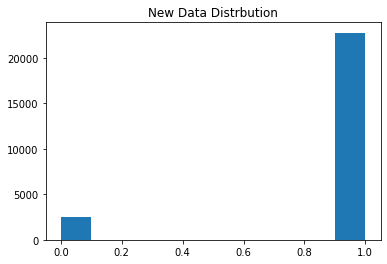

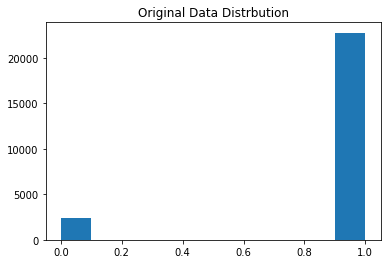

Adaptive model classifier evaluations
First 81000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959847125542733
recall score for incoming streams: 0.9988974641675854
precision score for incoming streams: 0.9966996699669967
ROC score for incoming data: 0.9834912852752821
####################################
Static model classifier evaluations
First 81000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988974641675854
precision score for incoming streams: 0.9988974641675854
ROC score for incoming data: 0.9941295831476226
####################################
New Data Distrbution Shape: (25248,)


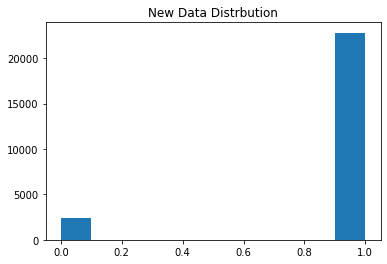

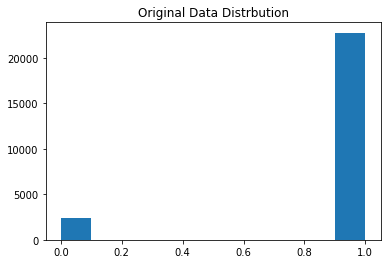

Adaptive model classifier evaluations
First 82000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979902726381599
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9978354978354979
ROC score for incoming data: 0.9873417721518987
####################################
Static model classifier evaluations
First 82000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.99598054527632
recall score for incoming streams: 0.9989154013015185
precision score for incoming streams: 0.9967532467532467
ROC score for incoming data: 0.9804703588786073
####################################
New Data Distrbution Shape: (25249,)


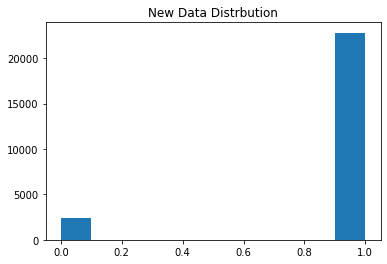

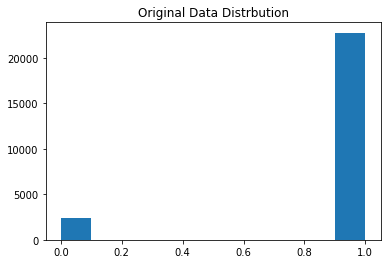

Adaptive model classifier evaluations
First 83000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9960221711526884
recall score for incoming streams: 0.9966814159292036
precision score for incoming streams: 0.9988913525498891
ROC score for incoming data: 0.9931860687893441
####################################
Static model classifier evaluations
First 83000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9960221711526884
recall score for incoming streams: 0.9966814159292036
precision score for incoming streams: 0.9988913525498891
ROC score for incoming data: 0.9931860687893441
####################################
New Data Distrbution Shape: (25250,)


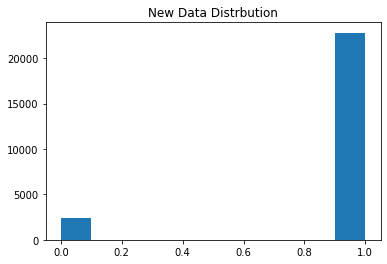

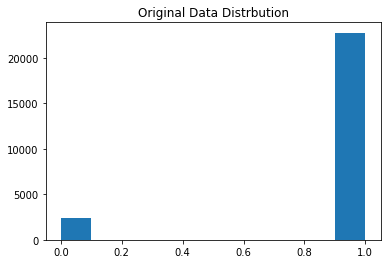

Adaptive model classifier evaluations
First 84000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9950154370359661
recall score for incoming streams: 0.9966517857142857
precision score for incoming streams: 0.9977653631284916
ROC score for incoming data: 0.9888020833333332
####################################
Static model classifier evaluations
First 84000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9970092622215798
recall score for incoming streams: 0.9977678571428571
precision score for incoming streams: 0.9988826815642458
ROC score for incoming data: 0.9941220238095239
####################################
New Data Distrbution Shape: (25251,)


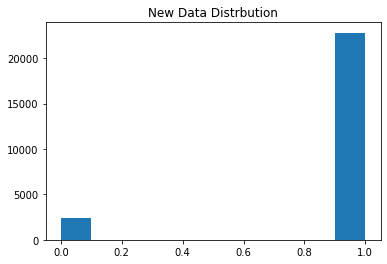

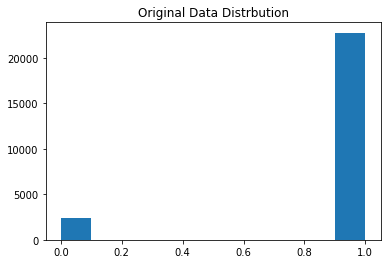

Adaptive model classifier evaluations
First 85000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979928041122275
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977900552486187
ROC score for incoming data: 0.9897959183673469
####################################
Static model classifier evaluations
First 85000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959667864363998
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9955898566703418
ROC score for incoming data: 0.9795918367346939
####################################
New Data Distrbution Shape: (25252,)


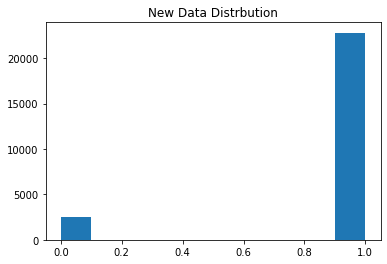

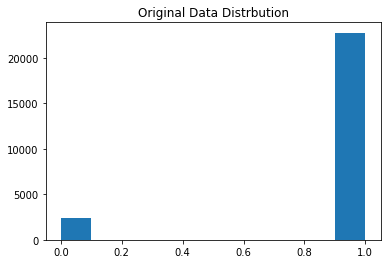

Adaptive model classifier evaluations
First 86000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988801791713325
precision score for incoming streams: 0.9988801791713325
ROC score for incoming data: 0.9948104599560367
####################################
Static model classifier evaluations
First 86000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.998001998001998
recall score for incoming streams: 0.9988801791713325
precision score for incoming streams: 0.9988801791713325
ROC score for incoming data: 0.9948104599560367
####################################
New Data Distrbution Shape: (25253,)


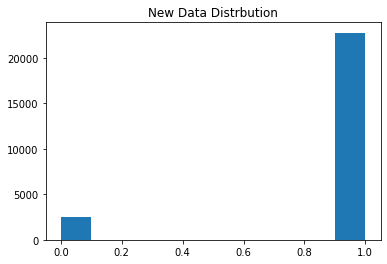

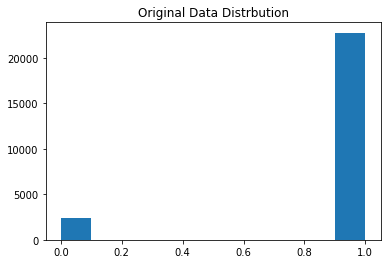

Adaptive model classifier evaluations
First 87000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989987659867842
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988913525498891
ROC score for incoming data: 0.995
####################################
Static model classifier evaluations
First 87000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9990032067319146
recall score for incoming streams: 0.9988901220865705
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9994450610432852
####################################
New Data Distrbution Shape: (25254,)


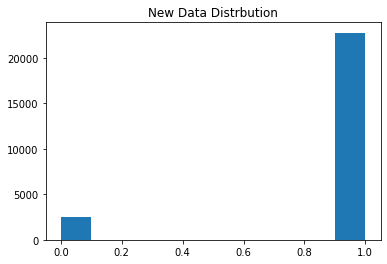

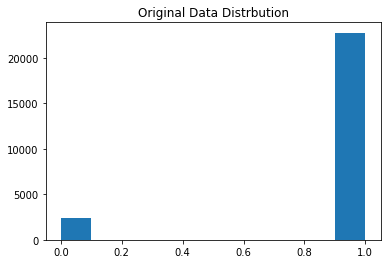

Adaptive model classifier evaluations
First 88000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959870118732996
recall score for incoming streams: 0.9988839285714286
precision score for incoming streams: 0.9966592427616926
ROC score for incoming data: 0.98515625
####################################
Static model classifier evaluations
First 88000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969837840493042
recall score for incoming streams: 1.0
precision score for incoming streams: 0.996662958843159
ROC score for incoming data: 0.9857142857142857
####################################
New Data Distrbution Shape: (25255,)


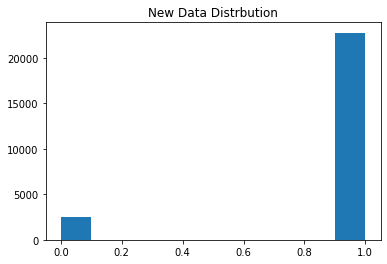

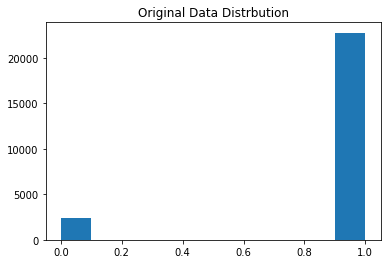

Adaptive model classifier evaluations
First 89000 Evaluation
Model accuracy score for incoming stream: 1.0
F1 score for incoming streams: 1.0
recall score for incoming streams: 1.0
precision score for incoming streams: 1.0
ROC score for incoming data: 1.0
####################################
Static model classifier evaluations
First 89000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959866302207467
recall score for incoming streams: 0.9988864142538976
precision score for incoming streams: 0.9966666666666667
ROC score for incoming data: 0.9848801003308323
####################################
New Data Distrbution Shape: (25256,)


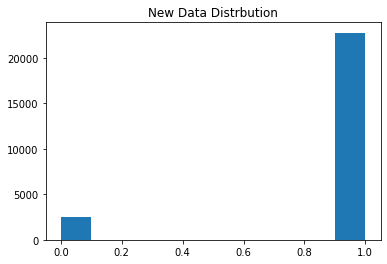

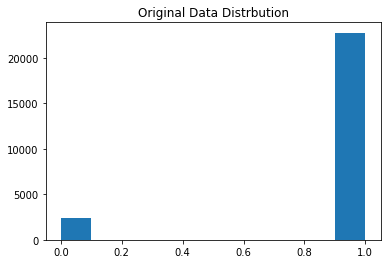

Adaptive model classifier evaluations
First 90000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979924717661939
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977973568281938
ROC score for incoming data: 0.9894736842105264
####################################
Static model classifier evaluations
First 90000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9979924717661939
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9977973568281938
ROC score for incoming data: 0.9894736842105264
####################################
New Data Distrbution Shape: (25257,)


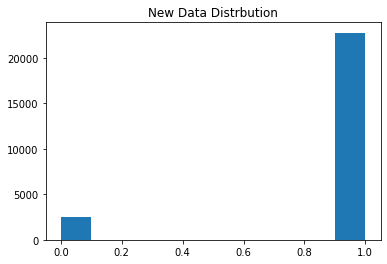

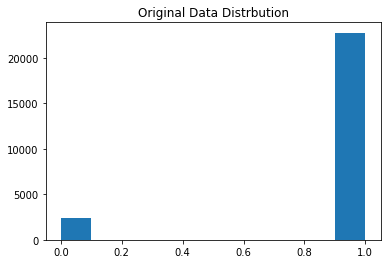

Adaptive model classifier evaluations
First 91000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9950146895560514
recall score for incoming streams: 0.9966254218222722
precision score for incoming streams: 0.9977477477477478
ROC score for incoming data: 0.9893841394825645
####################################
Static model classifier evaluations
First 91000 Evaluation
Model accuracy score for incoming stream: 0.993006993006993
F1 score for incoming streams: 0.9929932790510986
recall score for incoming streams: 0.9966254218222722
precision score for incoming streams: 0.9955056179775281
ROC score for incoming data: 0.9804555680539931
####################################
New Data Distrbution Shape: (25258,)


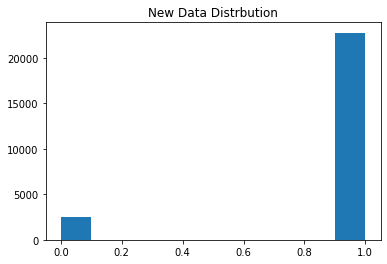

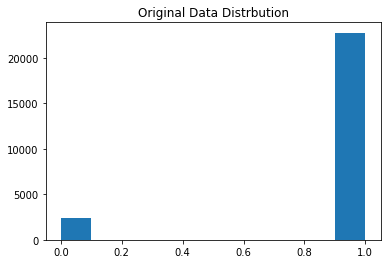

Adaptive model classifier evaluations
First 92000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.9939192184822425
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9934138309549945
ROC score for incoming data: 0.96875
####################################
Static model classifier evaluations
First 92000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959658910607795
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9955995599559956
ROC score for incoming data: 0.9791666666666667
####################################
New Data Distrbution Shape: (25259,)


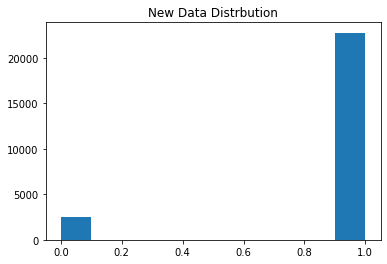

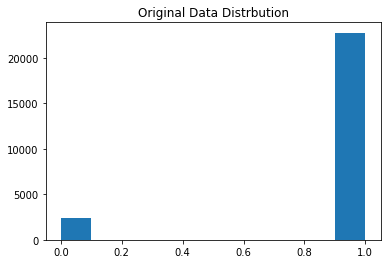

Adaptive model classifier evaluations
First 93000 Evaluation
Model accuracy score for incoming stream: 0.998001998001998
F1 score for incoming streams: 0.9980114111518783
recall score for incoming streams: 0.9977949283351709
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9988974641675854
####################################
Static model classifier evaluations
First 93000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9990033663503051
recall score for incoming streams: 0.9988974641675854
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9994487320837927
####################################
New Data Distrbution Shape: (25260,)


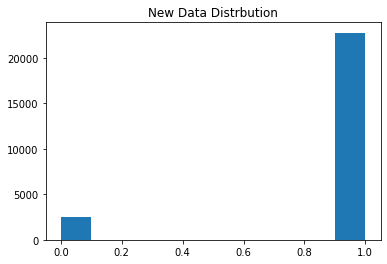

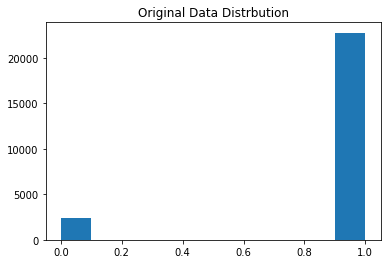

Adaptive model classifier evaluations
First 94000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969819426629322
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9966923925027563
ROC score for incoming data: 0.9845360824742269
####################################
Static model classifier evaluations
First 94000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959663434044751
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9955947136563876
ROC score for incoming data: 0.9793814432989691
####################################
New Data Distrbution Shape: (25261,)


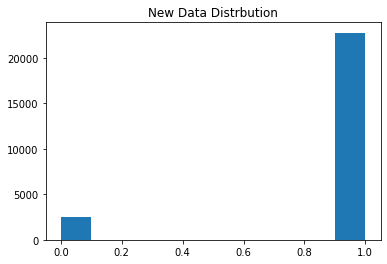

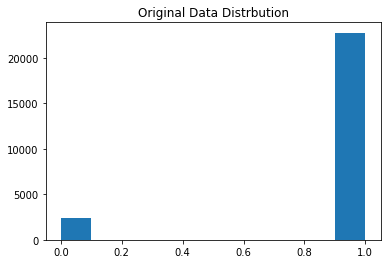

Adaptive model classifier evaluations
First 95000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.996997119593328
recall score for incoming streams: 0.9988751406074241
precision score for incoming streams: 0.9977528089887641
ROC score for incoming data: 0.9905089988751405
####################################
Static model classifier evaluations
First 95000 Evaluation
Model accuracy score for incoming stream: 0.996003996003996
F1 score for incoming streams: 0.9959882409320613
recall score for incoming streams: 0.9988751406074241
precision score for incoming streams: 0.9966329966329966
ROC score for incoming data: 0.9860447131608548
####################################
New Data Distrbution Shape: (25262,)


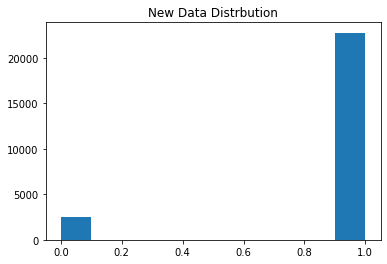

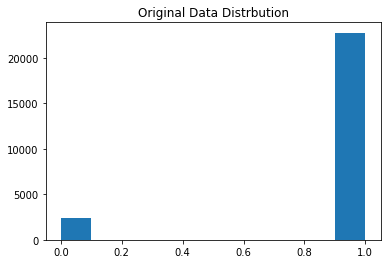

Adaptive model classifier evaluations
First 96000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969967317844143
recall score for incoming streams: 0.9988826815642458
precision score for incoming streams: 0.9977678571428571
ROC score for incoming data: 0.9900073785179719
####################################
Static model classifier evaluations
First 96000 Evaluation
Model accuracy score for incoming stream: 0.994005994005994
F1 score for incoming streams: 0.994005994005994
recall score for incoming streams: 0.9966480446927374
precision score for incoming streams: 0.9966480446927374
ROC score for incoming data: 0.9841730789501423
####################################
New Data Distrbution Shape: (25263,)


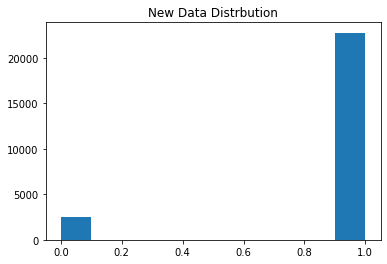

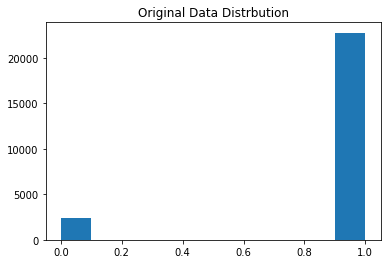

Adaptive model classifier evaluations
First 97000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.9989986596298808
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9988962472406181
ROC score for incoming data: 0.9947916666666667
####################################
Static model classifier evaluations
First 97000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9969816908592418
recall score for incoming streams: 1.0
precision score for incoming streams: 0.9966960352422908
ROC score for incoming data: 0.984375
####################################
New Data Distrbution Shape: (25264,)


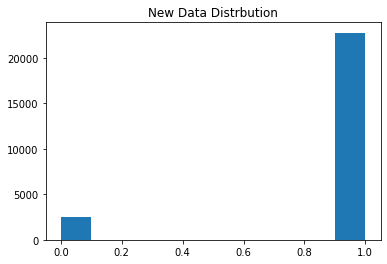

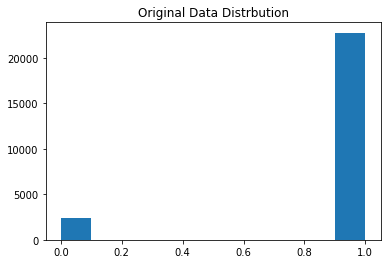

Adaptive model classifier evaluations
First 98000 Evaluation
Model accuracy score for incoming stream: 0.995004995004995
F1 score for incoming streams: 0.9950175775370295
recall score for incoming streams: 0.9967105263157895
precision score for incoming streams: 0.9978046103183315
ROC score for incoming data: 0.9871193081017148
####################################
Static model classifier evaluations
First 98000 Evaluation
Model accuracy score for incoming stream: 0.999000999000999
F1 score for incoming streams: 0.999003515507406
recall score for incoming streams: 0.9989035087719298
precision score for incoming streams: 1.0
ROC score for incoming data: 0.9994517543859649
####################################
New Data Distrbution Shape: (25265,)


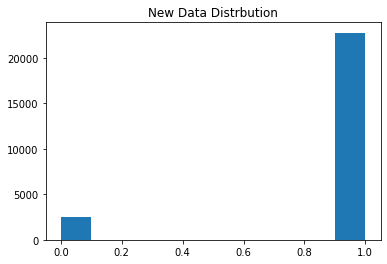

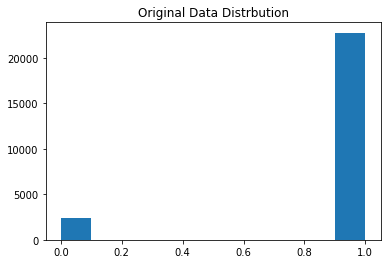

Adaptive model classifier evaluations
First 99000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9970097734148523
recall score for incoming streams: 0.9977851605758582
precision score for incoming streams: 0.9988913525498891
ROC score for incoming data: 0.9937905394716027
####################################
Static model classifier evaluations
First 99000 Evaluation
Model accuracy score for incoming stream: 0.997002997002997
F1 score for incoming streams: 0.9970097734148523
recall score for incoming streams: 0.9977851605758582
precision score for incoming streams: 0.9988913525498891
ROC score for incoming data: 0.9937905394716027
####################################
Training 100000 stream took: 94.4085146109263


In [ ]:
import time
start = time.time()
Kafka_Data=pd.DataFrame()
df_updated = df_copy.copy()
Evaluation = {"accuracies_dynamic": [],"stream_index":[],"f1_scores_dynamic":[],"precision_dynamic":[],"recall_dynamic":[],"ROC_Dynamic":[],
              "accuracies_static": [],"f1_scores_static":[],"precision_static":[],"recall_static":[],"ROC_Static":[]}
# Import the pythtitleConsumer Client for Kafka
from kafka import KafkaConsumer

# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task1', 
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# Data Stream flowing in.
i = 0
for message in consumer:
    
#    print(f"Consuming the {i+1}th data packet!")
    
    data_packet = message.value
    
    #print(data_packet)
    
    
    
    ##############################################
    x=eval(data_packet)
    y=pd.DataFrame(x, index=[0])
    Kafka_Data=Kafka_Data.append(y,ignore_index=True)
    if i in np.arange(1000,100000, 1000):
      
        batch = pd.DataFrame()
        batch = Kafka_Data.iloc[i-1000:i+1,:]
        batch["Label"] = encoder.fit_transform(batch["Label"])
        df_updated.drop(df_updated.head(1000).index, inplace = True)
        batch.replace([np.inf, -np.inf], np.nan, inplace=True)
        batch.fillna(batch.mean(),inplace= True)
        batch.sort_index(inplace=True)
        X_stream = batch.drop(['Label'], axis=1)
        y_stream = batch["Label"]



        df_updated = df_updated.append(batch)

        X = df_updated.drop(['Label'], axis=1)
        y = df_updated['Label']
        print("New Data Distrbution Shape:", y.shape)
        plt.title("New Data Distrbution")
        plt.hist(y)
        plt.show()
        plt.title("Original Data Distrbution")
        plt.hist(y_original)
        plt.show()
     
        stream_prediction_dynamic = RF_ada.predict(X_stream)
        stream_prediction_static = RF_static.predict(X_stream)

        Evaluation["accuracies_dynamic"].append(accuracy_score(y_stream,stream_prediction_dynamic))
        Evaluation["f1_scores_dynamic"].append(f1_score(y_stream,stream_prediction_dynamic, average='weighted'))
        Evaluation["recall_dynamic"].append(recall_score(y_stream,stream_prediction_dynamic,average='weighted'))
        Evaluation["precision_dynamic"].append(precision_score(y_stream,stream_prediction_dynamic,average='weighted'))
        Evaluation["ROC_Dynamic"].append(roc_auc_score(y_stream,stream_prediction_dynamic))

        Evaluation["accuracies_static"].append(accuracy_score(y_stream,stream_prediction_static))
        Evaluation["f1_scores_static"].append(f1_score(y_stream,stream_prediction_static, average='weighted'))
        Evaluation["recall_static"].append(recall_score(y_stream,stream_prediction_static,average='weighted'))
        Evaluation["precision_static"].append(precision_score(y_stream,stream_prediction_static,average='weighted'))
        Evaluation["ROC_Static"].append(roc_auc_score(y_stream,stream_prediction_static))


   
   ################################################################################################################################
       
        print("Adaptive model classifier evaluations")
        print("First "+ str(i) +" Evaluation")
        print('Model accuracy score for incoming stream:', accuracy_score(y_stream,stream_prediction_dynamic))
        print("F1 score for incoming streams:",f1_score(y_stream,stream_prediction_dynamic, average='weighted'))
        print("recall score for incoming streams:",recall_score(y_stream,stream_prediction_dynamic))
        print("precision score for incoming streams:",precision_score(y_stream,stream_prediction_dynamic))
        print("ROC score for incoming data:",roc_auc_score(y_stream,stream_prediction_dynamic))
        print("####################################")
        print("Static model classifier evaluations")
        print("First "+ str(i) +" Evaluation")
        print('Model accuracy score for incoming stream:', accuracy_score(y_stream,stream_prediction_static))
        print("F1 score for incoming streams:",f1_score(y_stream,stream_prediction_static, average='weighted'))
        print("recall score for incoming streams:",recall_score(y_stream,stream_prediction_static))
        print("precision score for incoming streams:",precision_score(y_stream,stream_prediction_static))
        print("ROC score for incoming data:",roc_auc_score(y_stream,stream_prediction_static))

        print("####################################")

        
        Evaluation["stream_index"].append(i)
        # fit the model to the updated training set
        RF_ada = RandomForestClassifier(n_estimators=10,random_state=0).fit(X, y)





    ##############################################
    if i == 100000:
        # save the model to disk
        filename = 'finalized_DT.sav'
        pickle.dump(RF_ada, open(filename, 'wb'))
        break
    i+=1

end = time.time()
print("Training 100000 stream took:", (end-start)/60)

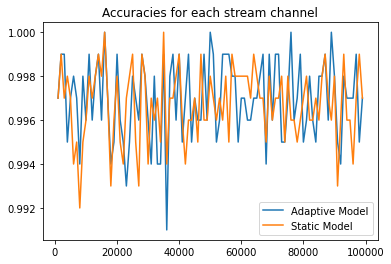

<Figure size 2160x2160 with 0 Axes>

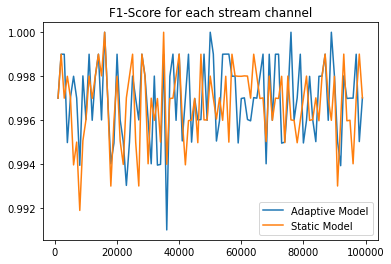

<Figure size 2160x2160 with 0 Axes>

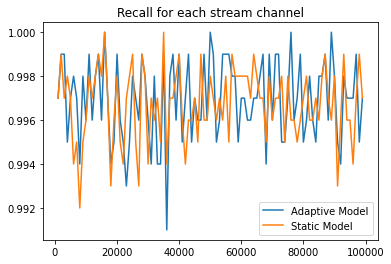

<Figure size 2160x2160 with 0 Axes>

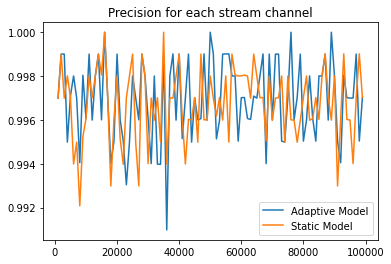

<Figure size 2160x2160 with 0 Axes>

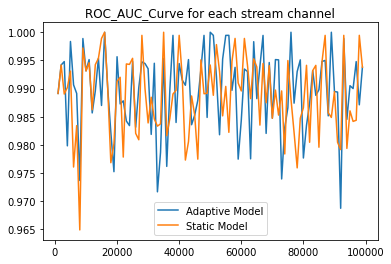

<Figure size 2160x2160 with 0 Axes>

In [ ]:
plt.title("Accuracies for each stream channel")
plt.plot(Evaluation["stream_index"],Evaluation["accuracies_dynamic"], label = "Adaptive Model")
plt.plot(Evaluation["stream_index"],Evaluation["accuracies_static"], label = "Static Model")
plt.legend()
plt.figure(figsize=(30,30));
plt.show()
plt.title("F1-Score for each stream channel")
plt.plot(Evaluation["stream_index"],Evaluation["f1_scores_dynamic"], label = "Adaptive Model")
plt.plot(Evaluation["stream_index"],Evaluation["f1_scores_static"], label = "Static Model")
plt.legend()
plt.figure(figsize=(30,30));
plt.show()
plt.title("Recall for each stream channel")
plt.plot(Evaluation["stream_index"],Evaluation["recall_dynamic"], label = "Adaptive Model")
plt.plot(Evaluation["stream_index"],Evaluation["recall_static"], label = "Static Model")
plt.legend()
plt.figure(figsize=(30,30));
plt.show()
plt.title("Precision for each stream channel")
plt.plot(Evaluation["stream_index"],Evaluation["precision_dynamic"], label = "Adaptive Model")
plt.plot(Evaluation["stream_index"],Evaluation["precision_static"], label = "Static Model")
plt.legend()
plt.figure(figsize=(30,30));
plt.show()
plt.title("ROC_AUC_Curve for each stream channel")
plt.plot(Evaluation["stream_index"],Evaluation["ROC_Dynamic"], label = "Adaptive Model")
plt.plot(Evaluation["stream_index"],Evaluation["ROC_Static"], label = "Static Model")
plt.legend()
plt.figure(figsize=(30,30));
plt.show()

# IOT Botnet Attack Detection problem


**Reading Data and Data Preparation**

In [ ]:
data = '/content/drive/MyDrive/AI_CS/iot_static_data.csv'

dfIOT = pd.read_csv(data)

In [ ]:
initial_eda(dfIOT)


Dimensions : 25609 rows, 117 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                      MI_dir_L5_weight    float64        18246          0
                        MI_dir_L5_mean    float64        13695          0
                    MI_dir_L5_variance    float64        15566          0
                      MI_dir_L3_weight    float64        20955          0
                        MI_dir_L3_mean    float64        16953          0
                    MI_dir_L3_variance    float64        18577          0
                      MI_dir_L1_weight    float64        23190          0
                        MI_dir_L1_mean    float64        22531          0
                    MI_dir_L1_variance    float64        23618          0
                    MI_dir_L0.1_weight    float64        24583          0
                      MI_dir_L0.1_mean    float64        24401          0
                  MI_dir_L0.1_variance    float64   

In [ ]:
dfIOT["Class"].value_counts()

BENIGN                   22287
mirai_udp_attack          1774
gafgyt_udp_attack          446
gafgyt_junk_attack         377
gafgyt_tcp_attack          213
gafgyt_scan_attack         200
mirai_syn_attack           101
mirai_ack_attack            96
mirai_scan_attack           86
gafgyt_combo_attack         18
mirai_udpplain_attack       11
Name: Class, dtype: int64

In [ ]:
dfIOT["Class"].unique()


array(['BENIGN', 'mirai_udp_attack', 'mirai_ack_attack',
       'gafgyt_scan_attack', 'mirai_scan_attack', 'gafgyt_tcp_attack',
       'gafgyt_udp_attack', 'gafgyt_junk_attack', 'gafgyt_combo_attack',
       'mirai_syn_attack', 'mirai_udpplain_attack'], dtype=object)

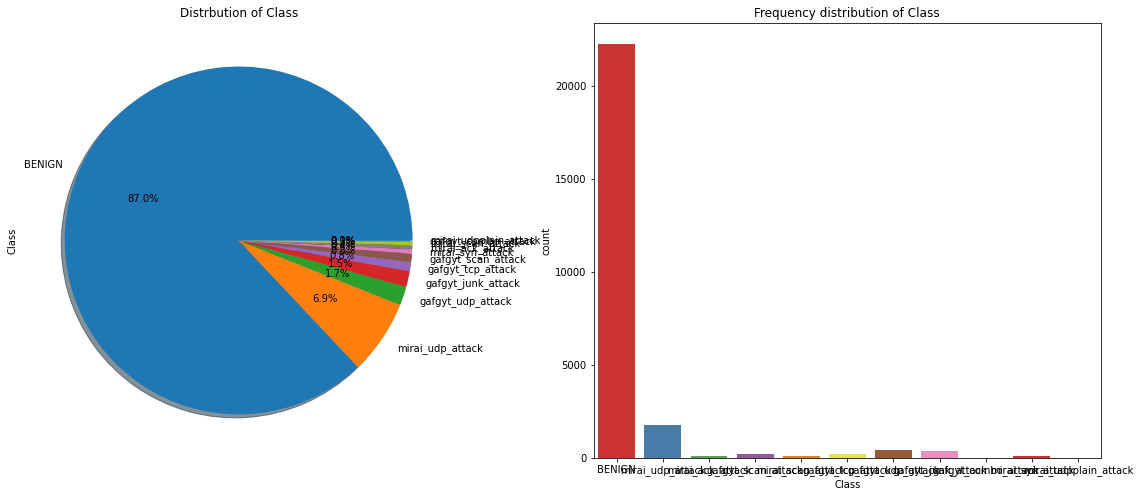

In [ ]:
# visualize frequency distribution of Lable 

f,ax=plt.subplots(1,2,figsize=(20,8))

ax[0] = dfIOT['Class'].value_counts().plot.pie(explode=None,autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Distrbution of Class')


#f, ax = plt.subplots(figsize=(6, 8))
ax[1] = sns.countplot(x="Class", data=dfIOT, palette="Set1")
ax[1].set_title("Frequency distribution of Class")

plt.show()

In [ ]:
categorical = [col for col in dfIOT.columns if dfIOT[col].dtypes == 'O']

categorical

['Source', 'Class']

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
dfIOT["Class"] = encoder.fit_transform(dfIOT["Class"])
dfIOT["Source"] = encoder.fit_transform(dfIOT["Source"])

In [ ]:
dfIOT.shape

(25609, 117)

In [ ]:
dfIOT.sort_index(inplace=True)
df_copy = dfIOT.copy()


In [ ]:
X_original = dfIOT.drop(['Class'], axis=1)
y_original = dfIOT['Class']

# Fitting the two models on the original dataset

In [ ]:
cat_ada = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy',
    random_state = 0
).fit(X_original, y_original)
print("#####################################")
cat_static = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
random_state=0).fit(X_original, y_original)


0:	learn: 1.5105204	total: 537ms	remaining: 2.15s
1:	learn: 1.1969980	total: 1.1s	remaining: 1.66s
2:	learn: 0.9941055	total: 1.64s	remaining: 1.09s
3:	learn: 0.8438288	total: 2.17s	remaining: 543ms
4:	learn: 0.7270213	total: 2.71s	remaining: 0us
#####################################
0:	learn: 1.5105204	total: 535ms	remaining: 2.14s
1:	learn: 1.1969980	total: 1.08s	remaining: 1.62s
2:	learn: 0.9941055	total: 1.62s	remaining: 1.08s
3:	learn: 0.8438288	total: 2.18s	remaining: 544ms
4:	learn: 0.7270213	total: 2.72s	remaining: 0us


# Fitting the two adaptive model into the Kafka Stream 

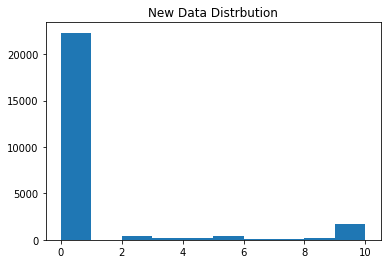

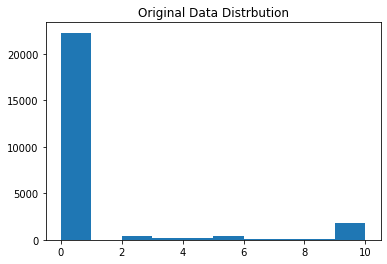

Adaptive model classifier evaluations
First 1000 Evaluation
Model accuracy score for incoming stream: 0.8721278721278721
F1 score for incoming streams: 0.8711570120020824
recall score for incoming streams: 0.8721278721278721
precision score for incoming streams: 0.871143142571714
####################################
Static model classifier evaluations
First 1000 Evaluation
Model accuracy score for incoming stream: 0.8721278721278721
F1 score for incoming streams: 0.8711570120020824
recall score for incoming streams: 0.8721278721278721
precision score for incoming streams: 0.871143142571714
####################################
0:	learn: 1.5240828	total: 524ms	remaining: 2.1s
1:	learn: 1.2092425	total: 1.06s	remaining: 1.59s
2:	learn: 1.0062438	total: 1.61s	remaining: 1.07s
3:	learn: 0.8573080	total: 2.15s	remaining: 539ms
4:	learn: 0.7406646	total: 2.68s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


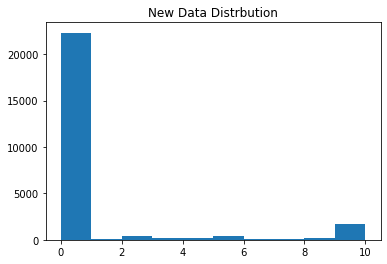

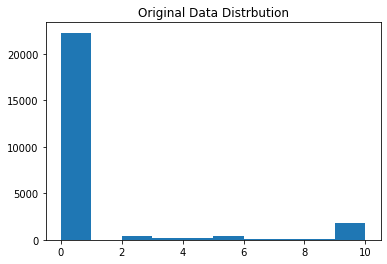

Adaptive model classifier evaluations
First 2000 Evaluation
Model accuracy score for incoming stream: 0.987012987012987
F1 score for incoming streams: 0.9827587126135526
recall score for incoming streams: 0.987012987012987
precision score for incoming streams: 0.9798662137521195
####################################
Static model classifier evaluations
First 2000 Evaluation
Model accuracy score for incoming stream: 0.986013986013986
F1 score for incoming streams: 0.9808342616691763
recall score for incoming streams: 0.986013986013986
precision score for incoming streams: 0.9795057501703797
####################################
0:	learn: 1.5207676	total: 523ms	remaining: 2.09s
1:	learn: 1.2079696	total: 1.06s	remaining: 1.59s
2:	learn: 1.0035093	total: 1.58s	remaining: 1.06s
3:	learn: 0.8536680	total: 2.12s	remaining: 529ms
4:	learn: 0.7373945	total: 2.63s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


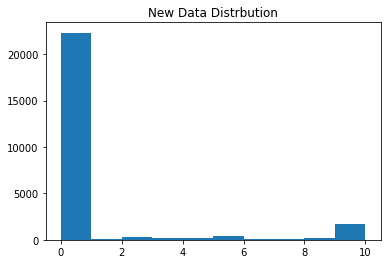

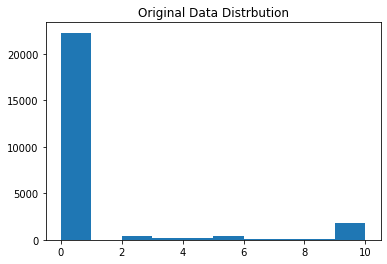

Adaptive model classifier evaluations
First 3000 Evaluation
Model accuracy score for incoming stream: 0.8911088911088911
F1 score for incoming streams: 0.8892267153136718
recall score for incoming streams: 0.8911088911088911
precision score for incoming streams: 0.8891705309615757
####################################
Static model classifier evaluations
First 3000 Evaluation
Model accuracy score for incoming stream: 0.8911088911088911
F1 score for incoming streams: 0.8892267153136718
recall score for incoming streams: 0.8911088911088911
precision score for incoming streams: 0.8891705309615757
####################################
0:	learn: 1.5248854	total: 549ms	remaining: 2.2s
1:	learn: 1.2133409	total: 1.07s	remaining: 1.61s
2:	learn: 1.0109144	total: 1.6s	remaining: 1.07s
3:	learn: 0.8623942	total: 2.12s	remaining: 530ms
4:	learn: 0.7482845	total: 2.65s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


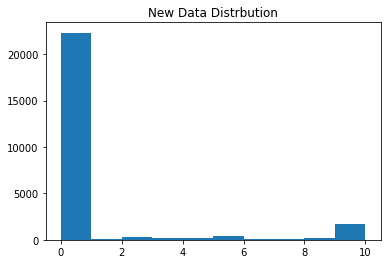

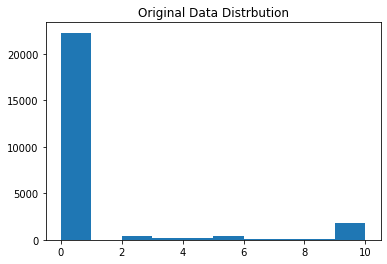

Adaptive model classifier evaluations
First 4000 Evaluation
Model accuracy score for incoming stream: 0.9790209790209791
F1 score for incoming streams: 0.9725254550905584
recall score for incoming streams: 0.9790209790209791
precision score for incoming streams: 0.9705797779545715
####################################
Static model classifier evaluations
First 4000 Evaluation
Model accuracy score for incoming stream: 0.9790209790209791
F1 score for incoming streams: 0.9729041208150333
recall score for incoming streams: 0.9790209790209791
precision score for incoming streams: 0.9699083872301958
####################################
0:	learn: 1.5276664	total: 523ms	remaining: 2.09s
1:	learn: 1.2154931	total: 1.05s	remaining: 1.58s
2:	learn: 1.0141835	total: 1.57s	remaining: 1.05s
3:	learn: 0.8669096	total: 2.1s	remaining: 526ms
4:	learn: 0.7519194	total: 2.63s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


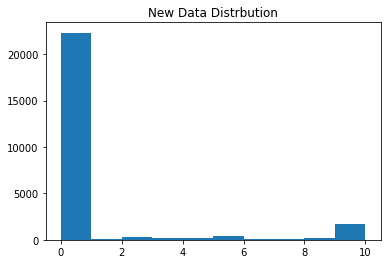

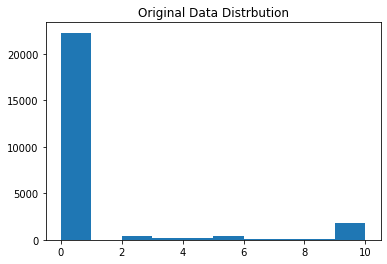

Adaptive model classifier evaluations
First 5000 Evaluation
Model accuracy score for incoming stream: 0.978021978021978
F1 score for incoming streams: 0.9696795654739079
recall score for incoming streams: 0.978021978021978
precision score for incoming streams: 0.9634087928616928
####################################
Static model classifier evaluations
First 5000 Evaluation
Model accuracy score for incoming stream: 0.981018981018981
F1 score for incoming streams: 0.9743885794357473
recall score for incoming streams: 0.981018981018981
precision score for incoming streams: 0.9714085118697492
####################################
0:	learn: 1.5263198	total: 549ms	remaining: 2.19s
1:	learn: 1.2148562	total: 1.08s	remaining: 1.63s
2:	learn: 1.0130674	total: 1.62s	remaining: 1.08s
3:	learn: 0.8659239	total: 2.15s	remaining: 538ms
4:	learn: 0.7501762	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


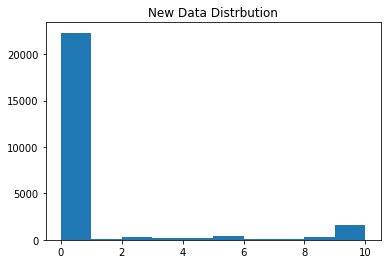

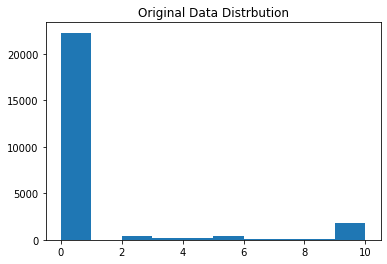

Adaptive model classifier evaluations
First 6000 Evaluation
Model accuracy score for incoming stream: 0.8561438561438561
F1 score for incoming streams: 0.8556446468982912
recall score for incoming streams: 0.8561438561438561
precision score for incoming streams: 0.8551460194816838
####################################
Static model classifier evaluations
First 6000 Evaluation
Model accuracy score for incoming stream: 0.8561438561438561
F1 score for incoming streams: 0.8561438561438561
recall score for incoming streams: 0.8561438561438561
precision score for incoming streams: 0.8561438561438561
####################################
0:	learn: 1.5345058	total: 531ms	remaining: 2.13s
1:	learn: 1.2252217	total: 1.06s	remaining: 1.6s
2:	learn: 1.0246061	total: 1.59s	remaining: 1.06s
3:	learn: 0.8761501	total: 2.12s	remaining: 529ms
4:	learn: 0.7608562	total: 2.64s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


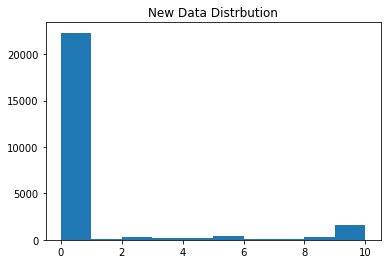

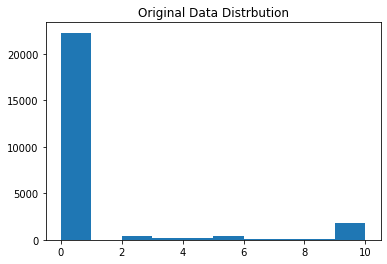

Adaptive model classifier evaluations
First 7000 Evaluation
Model accuracy score for incoming stream: 0.978021978021978
F1 score for incoming streams: 0.9699955478639074
recall score for incoming streams: 0.978021978021978
precision score for incoming streams: 0.9677904444606124
####################################
Static model classifier evaluations
First 7000 Evaluation
Model accuracy score for incoming stream: 0.983016983016983
F1 score for incoming streams: 0.9766529553395912
recall score for incoming streams: 0.983016983016983
precision score for incoming streams: 0.971532203606507
####################################
0:	learn: 1.5331259	total: 540ms	remaining: 2.16s
1:	learn: 1.2231681	total: 1.07s	remaining: 1.6s
2:	learn: 1.0229646	total: 1.6s	remaining: 1.07s
3:	learn: 0.8745531	total: 2.12s	remaining: 531ms
4:	learn: 0.7596212	total: 2.66s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


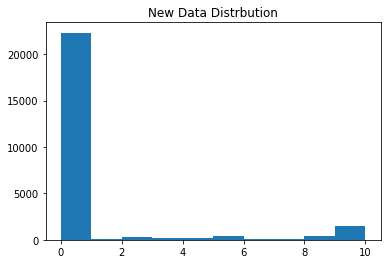

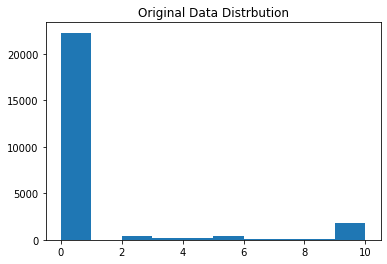

Adaptive model classifier evaluations
First 8000 Evaluation
Model accuracy score for incoming stream: 0.8771228771228772
F1 score for incoming streams: 0.8766236609150666
recall score for incoming streams: 0.8771228771228772
precision score for incoming streams: 0.8761250126437838
####################################
Static model classifier evaluations
First 8000 Evaluation
Model accuracy score for incoming stream: 0.8771228771228772
F1 score for incoming streams: 0.8771228771228772
recall score for incoming streams: 0.8771228771228772
precision score for incoming streams: 0.8771228771228772
####################################
0:	learn: 1.5392342	total: 527ms	remaining: 2.11s
1:	learn: 1.2344570	total: 1.06s	remaining: 1.59s
2:	learn: 1.0332688	total: 1.59s	remaining: 1.06s
3:	learn: 0.8865386	total: 2.12s	remaining: 531ms
4:	learn: 0.7712098	total: 2.65s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


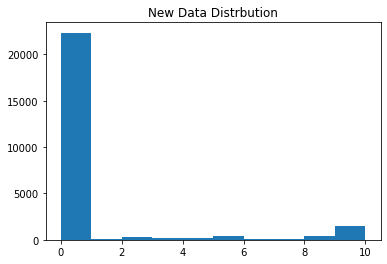

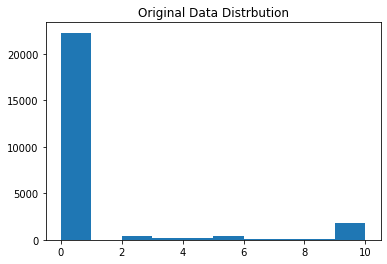

Adaptive model classifier evaluations
First 9000 Evaluation
Model accuracy score for incoming stream: 0.974025974025974
F1 score for incoming streams: 0.9655100646712191
recall score for incoming streams: 0.974025974025974
precision score for incoming streams: 0.9600971451211546
####################################
Static model classifier evaluations
First 9000 Evaluation
Model accuracy score for incoming stream: 0.977022977022977
F1 score for incoming streams: 0.9696673529494028
recall score for incoming streams: 0.977022977022977
precision score for incoming streams: 0.9697034285269579
####################################
0:	learn: 1.5427440	total: 533ms	remaining: 2.13s
1:	learn: 1.2367146	total: 1.07s	remaining: 1.6s
2:	learn: 1.0335450	total: 1.6s	remaining: 1.06s
3:	learn: 0.8870425	total: 2.13s	remaining: 532ms
4:	learn: 0.7720753	total: 2.67s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


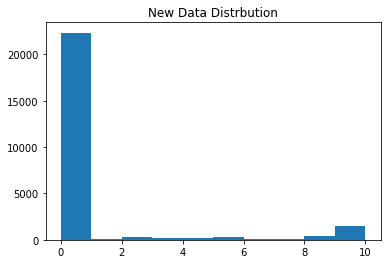

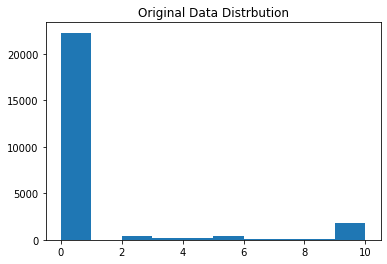

Adaptive model classifier evaluations
First 10000 Evaluation
Model accuracy score for incoming stream: 0.977022977022977
F1 score for incoming streams: 0.9699560530204585
recall score for incoming streams: 0.977022977022977
precision score for incoming streams: 0.9662478947427043
####################################
Static model classifier evaluations
First 10000 Evaluation
Model accuracy score for incoming stream: 0.978021978021978
F1 score for incoming streams: 0.9712921882067517
recall score for incoming streams: 0.978021978021978
precision score for incoming streams: 0.9673718463331139
####################################
0:	learn: 1.5466744	total: 533ms	remaining: 2.13s
1:	learn: 1.2366362	total: 1.07s	remaining: 1.6s
2:	learn: 1.0326404	total: 1.6s	remaining: 1.06s
3:	learn: 0.8856566	total: 2.13s	remaining: 533ms
4:	learn: 0.7714483	total: 2.66s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


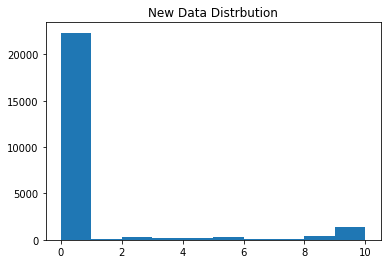

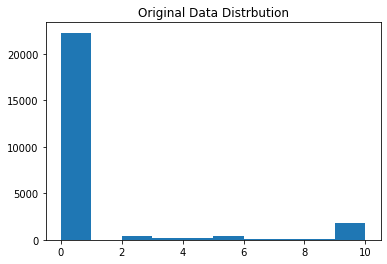

Adaptive model classifier evaluations
First 11000 Evaluation
Model accuracy score for incoming stream: 0.8681318681318682
F1 score for incoming streams: 0.8671340154098776
recall score for incoming streams: 0.8681318681318682
precision score for incoming streams: 0.8661384539685344
####################################
Static model classifier evaluations
First 11000 Evaluation
Model accuracy score for incoming stream: 0.8681318681318682
F1 score for incoming streams: 0.8681318681318682
recall score for incoming streams: 0.8681318681318682
precision score for incoming streams: 0.8681318681318682
####################################
0:	learn: 1.5480687	total: 528ms	remaining: 2.11s
1:	learn: 1.2428510	total: 1.07s	remaining: 1.6s
2:	learn: 1.0387754	total: 1.6s	remaining: 1.07s
3:	learn: 0.8923022	total: 2.13s	remaining: 532ms
4:	learn: 0.7779809	total: 2.66s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


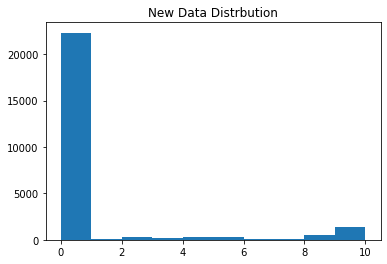

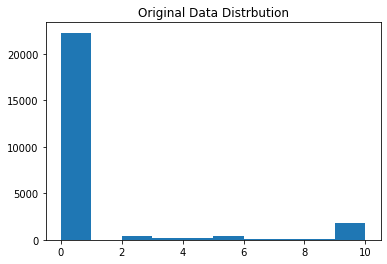

Adaptive model classifier evaluations
First 12000 Evaluation
Model accuracy score for incoming stream: 0.8781218781218781
F1 score for incoming streams: 0.8781218781218781
recall score for incoming streams: 0.8781218781218781
precision score for incoming streams: 0.8781218781218781
####################################
Static model classifier evaluations
First 12000 Evaluation
Model accuracy score for incoming stream: 0.8781218781218781
F1 score for incoming streams: 0.8781218781218781
recall score for incoming streams: 0.8781218781218781
precision score for incoming streams: 0.8781218781218781
####################################
0:	learn: 1.5499797	total: 518ms	remaining: 2.07s
1:	learn: 1.2439472	total: 1.05s	remaining: 1.57s
2:	learn: 1.0433153	total: 1.58s	remaining: 1.05s
3:	learn: 0.8978511	total: 2.12s	remaining: 529ms
4:	learn: 0.7843961	total: 2.64s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


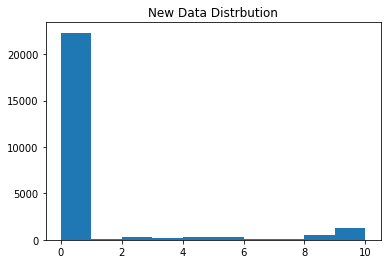

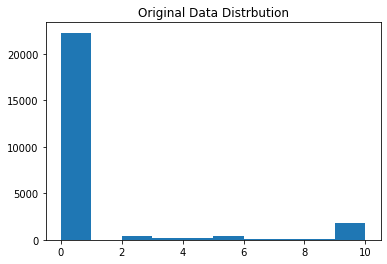

Adaptive model classifier evaluations
First 13000 Evaluation
Model accuracy score for incoming stream: 0.8601398601398601
F1 score for incoming streams: 0.8596406495419844
recall score for incoming streams: 0.8601398601398601
precision score for incoming streams: 0.8591420180747328
####################################
Static model classifier evaluations
First 13000 Evaluation
Model accuracy score for incoming stream: 0.8601398601398601
F1 score for incoming streams: 0.8601398601398601
recall score for incoming streams: 0.8601398601398601
precision score for incoming streams: 0.8601398601398601
####################################
0:	learn: 1.5557569	total: 521ms	remaining: 2.08s
1:	learn: 1.2514626	total: 1.05s	remaining: 1.57s
2:	learn: 1.0514701	total: 1.57s	remaining: 1.05s
3:	learn: 0.9045349	total: 2.1s	remaining: 526ms
4:	learn: 0.7900503	total: 2.62s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


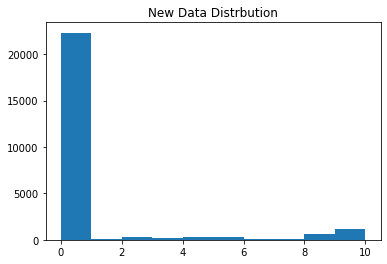

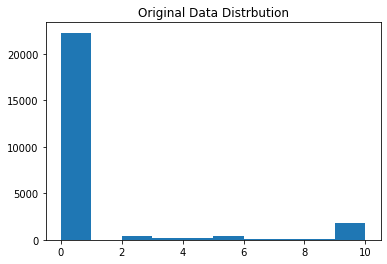

Adaptive model classifier evaluations
First 14000 Evaluation
Model accuracy score for incoming stream: 0.8661338661338661
F1 score for incoming streams: 0.8641404625294152
recall score for incoming streams: 0.8661338661338661
precision score for incoming streams: 0.8621562134765349
####################################
Static model classifier evaluations
First 14000 Evaluation
Model accuracy score for incoming stream: 0.8661338661338661
F1 score for incoming streams: 0.8661338661338661
recall score for incoming streams: 0.8661338661338661
precision score for incoming streams: 0.8661338661338661
####################################
0:	learn: 1.5585183	total: 533ms	remaining: 2.13s
1:	learn: 1.2555222	total: 1.07s	remaining: 1.6s
2:	learn: 1.0553835	total: 1.6s	remaining: 1.06s
3:	learn: 0.9096165	total: 2.12s	remaining: 531ms
4:	learn: 0.7952929	total: 2.66s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


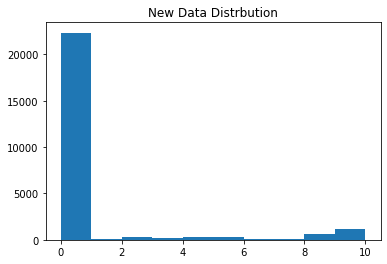

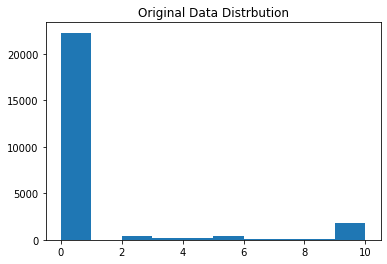

Adaptive model classifier evaluations
First 15000 Evaluation
Model accuracy score for incoming stream: 0.975024975024975
F1 score for incoming streams: 0.968976899900894
recall score for incoming streams: 0.975024975024975
precision score for incoming streams: 0.9676475247426036
####################################
Static model classifier evaluations
First 15000 Evaluation
Model accuracy score for incoming stream: 0.985014985014985
F1 score for incoming streams: 0.9796420425932971
recall score for incoming streams: 0.985014985014985
precision score for incoming streams: 0.976809767182438
####################################
0:	learn: 1.5569992	total: 532ms	remaining: 2.13s
1:	learn: 1.2532830	total: 1.05s	remaining: 1.58s
2:	learn: 1.0533955	total: 1.59s	remaining: 1.06s
3:	learn: 0.9057165	total: 2.13s	remaining: 532ms
4:	learn: 0.7915372	total: 2.68s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


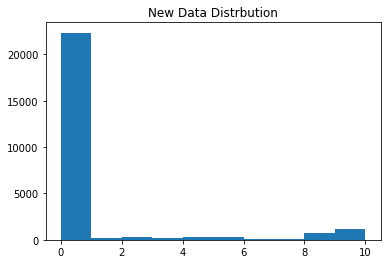

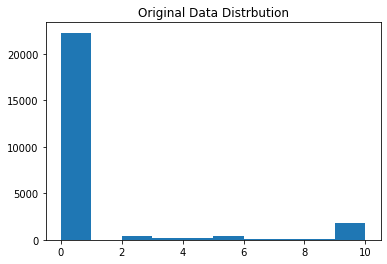

Adaptive model classifier evaluations
First 16000 Evaluation
Model accuracy score for incoming stream: 0.8971028971028971
F1 score for incoming streams: 0.8930413144497651
recall score for incoming streams: 0.8971028971028971
precision score for incoming streams: 0.8910059865942219
####################################
Static model classifier evaluations
First 16000 Evaluation
Model accuracy score for incoming stream: 0.8871128871128872
F1 score for incoming streams: 0.886140886140886
recall score for incoming streams: 0.8871128871128872
precision score for incoming streams: 0.8861275710590779
####################################
0:	learn: 1.5590191	total: 540ms	remaining: 2.16s
1:	learn: 1.2581598	total: 1.08s	remaining: 1.62s
2:	learn: 1.0582276	total: 1.61s	remaining: 1.07s
3:	learn: 0.9119906	total: 2.15s	remaining: 537ms
4:	learn: 0.7970640	total: 2.67s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


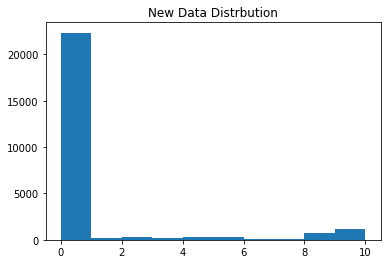

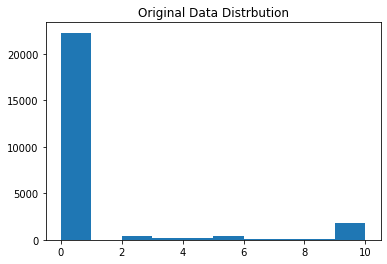

Adaptive model classifier evaluations
First 17000 Evaluation
Model accuracy score for incoming stream: 0.971028971028971
F1 score for incoming streams: 0.9643492016688768
recall score for incoming streams: 0.971028971028971
precision score for incoming streams: 0.9623729363956224
####################################
Static model classifier evaluations
First 17000 Evaluation
Model accuracy score for incoming stream: 0.988011988011988
F1 score for incoming streams: 0.9829803111399564
recall score for incoming streams: 0.988011988011988
precision score for incoming streams: 0.9788827398148456
####################################
0:	learn: 1.5643835	total: 524ms	remaining: 2.1s
1:	learn: 1.2582410	total: 1.06s	remaining: 1.59s
2:	learn: 1.0575656	total: 1.59s	remaining: 1.06s
3:	learn: 0.9117062	total: 2.13s	remaining: 533ms
4:	learn: 0.7975106	total: 2.65s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


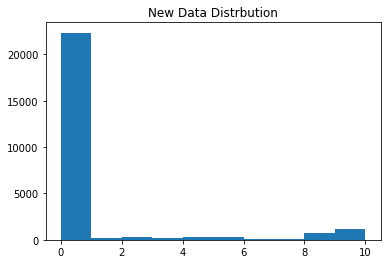

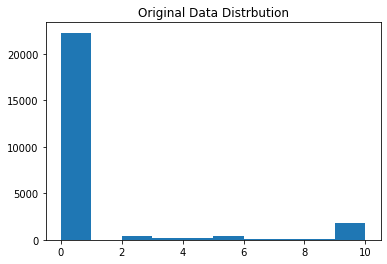

Adaptive model classifier evaluations
First 18000 Evaluation
Model accuracy score for incoming stream: 0.9660339660339661
F1 score for incoming streams: 0.9575707070118427
recall score for incoming streams: 0.9660339660339661
precision score for incoming streams: 0.9598434162474699
####################################
Static model classifier evaluations
First 18000 Evaluation
Model accuracy score for incoming stream: 0.987012987012987
F1 score for incoming streams: 0.9825095932761525
recall score for incoming streams: 0.987012987012987
precision score for incoming streams: 0.9793474382760097
####################################
0:	learn: 1.5586211	total: 517ms	remaining: 2.07s
1:	learn: 1.2558931	total: 1.06s	remaining: 1.59s
2:	learn: 1.0568596	total: 1.59s	remaining: 1.06s
3:	learn: 0.9106487	total: 2.12s	remaining: 530ms
4:	learn: 0.7961749	total: 2.64s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


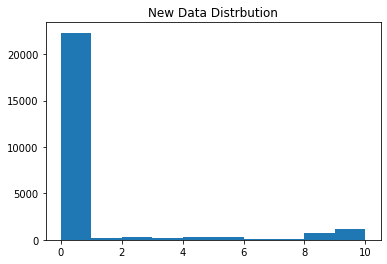

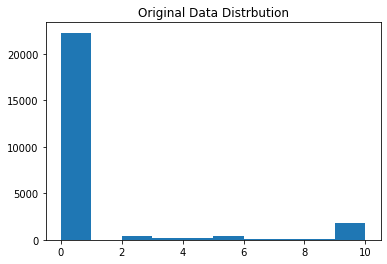

Adaptive model classifier evaluations
First 19000 Evaluation
Model accuracy score for incoming stream: 0.974025974025974
F1 score for incoming streams: 0.9661624864233751
recall score for incoming streams: 0.974025974025974
precision score for incoming streams: 0.9674708424708425
####################################
Static model classifier evaluations
First 19000 Evaluation
Model accuracy score for incoming stream: 0.9760239760239761
F1 score for incoming streams: 0.9688099813785623
recall score for incoming streams: 0.9760239760239761
precision score for incoming streams: 0.9684781684781685
####################################
0:	learn: 1.5581066	total: 530ms	remaining: 2.12s
1:	learn: 1.2578129	total: 1.06s	remaining: 1.59s
2:	learn: 1.0572902	total: 1.61s	remaining: 1.07s
3:	learn: 0.9115169	total: 2.14s	remaining: 535ms
4:	learn: 0.7979774	total: 2.67s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


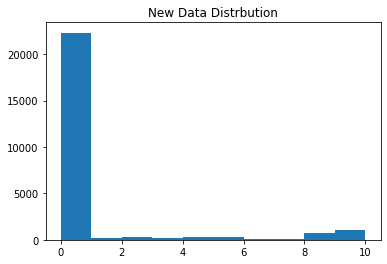

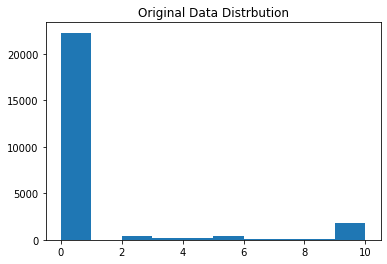

Adaptive model classifier evaluations
First 20000 Evaluation
Model accuracy score for incoming stream: 0.8731268731268731
F1 score for incoming streams: 0.8693926290099401
recall score for incoming streams: 0.8731268731268731
precision score for incoming streams: 0.867199903088856
####################################
Static model classifier evaluations
First 20000 Evaluation
Model accuracy score for incoming stream: 0.8661338661338661
F1 score for incoming streams: 0.8656346535309071
recall score for incoming streams: 0.8661338661338661
precision score for incoming streams: 0.8651360160576751
####################################
0:	learn: 1.5597461	total: 525ms	remaining: 2.1s
1:	learn: 1.2597714	total: 1.07s	remaining: 1.6s
2:	learn: 1.0590111	total: 1.6s	remaining: 1.06s
3:	learn: 0.9131262	total: 2.14s	remaining: 536ms
4:	learn: 0.7986904	total: 2.66s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


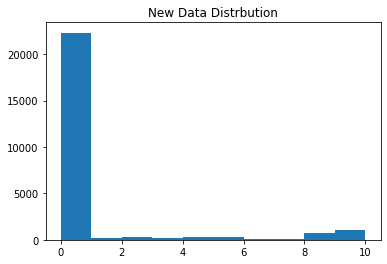

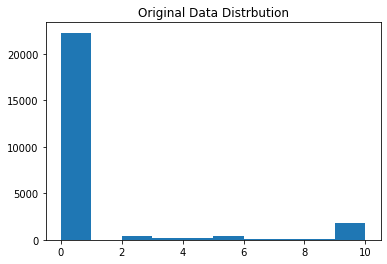

Adaptive model classifier evaluations
First 21000 Evaluation
Model accuracy score for incoming stream: 0.971028971028971
F1 score for incoming streams: 0.9631858825812574
recall score for incoming streams: 0.971028971028971
precision score for incoming streams: 0.9628864480951594
####################################
Static model classifier evaluations
First 21000 Evaluation
Model accuracy score for incoming stream: 0.983016983016983
F1 score for incoming streams: 0.9772740656803471
recall score for incoming streams: 0.983016983016983
precision score for incoming streams: 0.9750435674979486
####################################
0:	learn: 1.5623728	total: 533ms	remaining: 2.13s
1:	learn: 1.2605354	total: 1.06s	remaining: 1.59s
2:	learn: 1.0593779	total: 1.59s	remaining: 1.06s
3:	learn: 0.9141397	total: 2.14s	remaining: 534ms
4:	learn: 0.7995293	total: 2.67s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


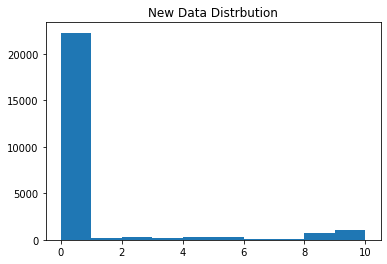

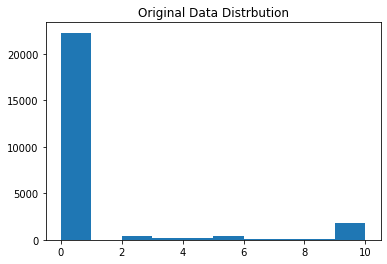

Adaptive model classifier evaluations
First 22000 Evaluation
Model accuracy score for incoming stream: 0.971028971028971
F1 score for incoming streams: 0.9626520781565059
recall score for incoming streams: 0.971028971028971
precision score for incoming streams: 0.9610990754177822
####################################
Static model classifier evaluations
First 22000 Evaluation
Model accuracy score for incoming stream: 0.977022977022977
F1 score for incoming streams: 0.9683718033471729
recall score for incoming streams: 0.977022977022977
precision score for incoming streams: 0.966884096295861
####################################
0:	learn: 1.5645275	total: 555ms	remaining: 2.22s
1:	learn: 1.2639224	total: 1.12s	remaining: 1.67s
2:	learn: 1.0625195	total: 1.69s	remaining: 1.13s
3:	learn: 0.9171378	total: 2.23s	remaining: 557ms
4:	learn: 0.8021803	total: 2.77s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


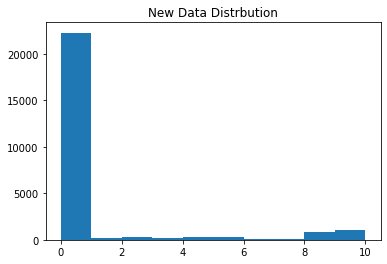

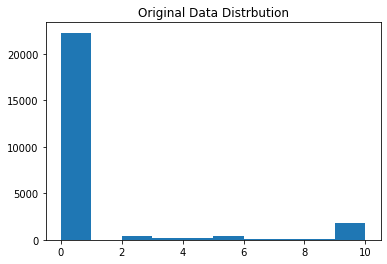

Adaptive model classifier evaluations
First 23000 Evaluation
Model accuracy score for incoming stream: 0.8861138861138861
F1 score for incoming streams: 0.8794584463155891
recall score for incoming streams: 0.8861138861138861
precision score for incoming streams: 0.8751431009127703
####################################
Static model classifier evaluations
First 23000 Evaluation
Model accuracy score for incoming stream: 0.8721278721278721
F1 score for incoming streams: 0.8716286575473753
recall score for incoming streams: 0.8721278721278721
precision score for incoming streams: 0.8711300141506091
####################################
0:	learn: 1.5645125	total: 537ms	remaining: 2.15s
1:	learn: 1.2612384	total: 1.06s	remaining: 1.6s
2:	learn: 1.0620112	total: 1.61s	remaining: 1.07s
3:	learn: 0.9154818	total: 2.15s	remaining: 537ms
4:	learn: 0.8008451	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


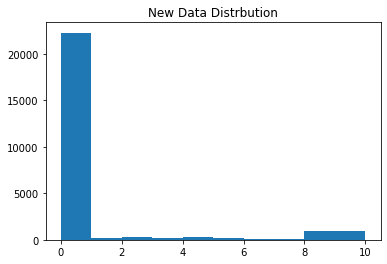

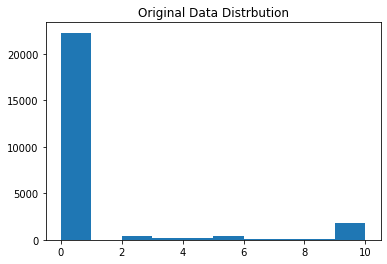

Adaptive model classifier evaluations
First 24000 Evaluation
Model accuracy score for incoming stream: 0.8821178821178821
F1 score for incoming streams: 0.8749474982579687
recall score for incoming streams: 0.8821178821178821
precision score for incoming streams: 0.9466363038917508
####################################
Static model classifier evaluations
First 24000 Evaluation
Model accuracy score for incoming stream: 0.8601398601398601
F1 score for incoming streams: 0.8591652250188835
recall score for incoming streams: 0.8601398601398601
precision score for incoming streams: 0.8591531924865259
####################################
0:	learn: 1.5668398	total: 522ms	remaining: 2.09s
1:	learn: 1.2670672	total: 1.06s	remaining: 1.59s
2:	learn: 1.0656753	total: 1.6s	remaining: 1.06s
3:	learn: 0.9181810	total: 2.12s	remaining: 531ms
4:	learn: 0.8033466	total: 2.67s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


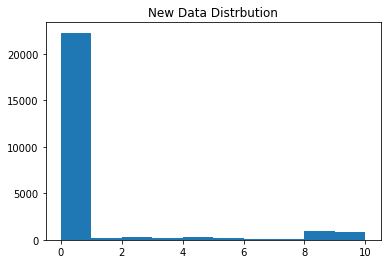

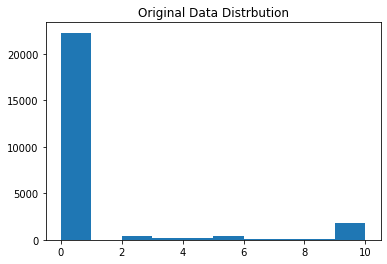

Adaptive model classifier evaluations
First 25000 Evaluation
Model accuracy score for incoming stream: 0.9050949050949051
F1 score for incoming streams: 0.8994881294453682
recall score for incoming streams: 0.9050949050949051
precision score for incoming streams: 0.8976448926077434
####################################
Static model classifier evaluations
First 25000 Evaluation
Model accuracy score for incoming stream: 0.8791208791208791
F1 score for incoming streams: 0.8763604816236394
recall score for incoming streams: 0.8791208791208791
precision score for incoming streams: 0.8762470406306023
####################################
0:	learn: 1.5644957	total: 525ms	remaining: 2.1s
1:	learn: 1.2601595	total: 1.06s	remaining: 1.6s
2:	learn: 1.0605479	total: 1.6s	remaining: 1.06s
3:	learn: 0.9154972	total: 2.14s	remaining: 535ms
4:	learn: 0.8017101	total: 2.66s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


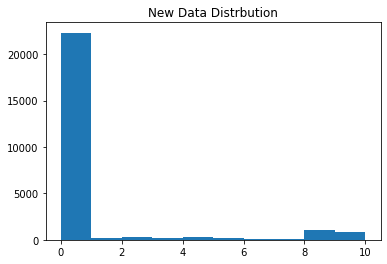

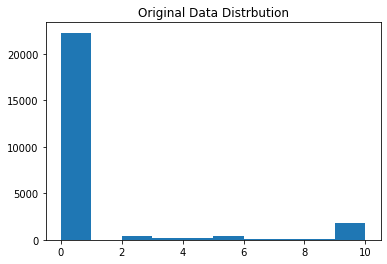

Adaptive model classifier evaluations
First 26000 Evaluation
Model accuracy score for incoming stream: 0.97002997002997
F1 score for incoming streams: 0.9616051120839612
recall score for incoming streams: 0.97002997002997
precision score for incoming streams: 0.9588346159842213
####################################
Static model classifier evaluations
First 26000 Evaluation
Model accuracy score for incoming stream: 0.8661338661338661
F1 score for incoming streams: 0.8651622350252488
recall score for incoming streams: 0.8661338661338661
precision score for incoming streams: 0.8651487401487402
####################################
0:	learn: 1.5618935	total: 538ms	remaining: 2.15s
1:	learn: 1.2589334	total: 1.08s	remaining: 1.61s
2:	learn: 1.0594192	total: 1.61s	remaining: 1.07s
3:	learn: 0.9143844	total: 2.14s	remaining: 535ms
4:	learn: 0.8006931	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


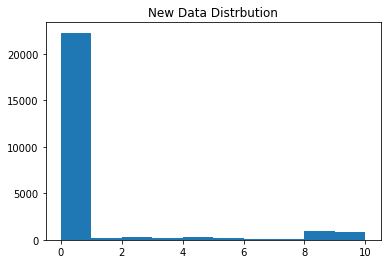

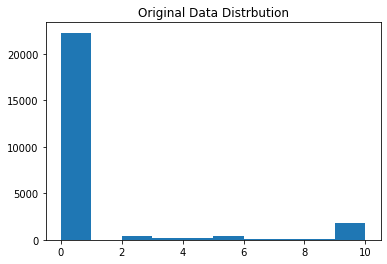

Adaptive model classifier evaluations
First 27000 Evaluation
Model accuracy score for incoming stream: 0.8651348651348651
F1 score for incoming streams: 0.856794903276481
recall score for incoming streams: 0.8651348651348651
precision score for incoming streams: 0.8542585356281102
####################################
Static model classifier evaluations
First 27000 Evaluation
Model accuracy score for incoming stream: 0.974025974025974
F1 score for incoming streams: 0.9635291179408827
recall score for incoming streams: 0.974025974025974
precision score for incoming streams: 0.9582782808589261
####################################
0:	learn: 1.5615094	total: 533ms	remaining: 2.13s
1:	learn: 1.2617672	total: 1.07s	remaining: 1.61s
2:	learn: 1.0637608	total: 1.61s	remaining: 1.07s
3:	learn: 0.9179030	total: 2.15s	remaining: 539ms
4:	learn: 0.8046314	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


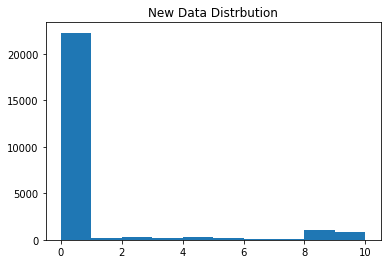

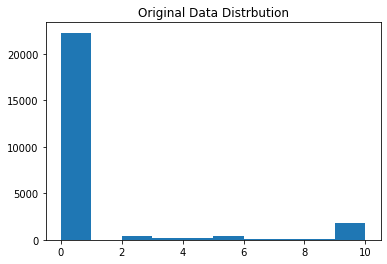

Adaptive model classifier evaluations
First 28000 Evaluation
Model accuracy score for incoming stream: 0.9690309690309691
F1 score for incoming streams: 0.9601044153241957
recall score for incoming streams: 0.9690309690309691
precision score for incoming streams: 0.9550919552239248
####################################
Static model classifier evaluations
First 28000 Evaluation
Model accuracy score for incoming stream: 0.8631368631368631
F1 score for incoming streams: 0.8607347931571534
recall score for incoming streams: 0.8631368631368631
precision score for incoming streams: 0.8601897494868695
####################################
0:	learn: 1.5704029	total: 530ms	remaining: 2.12s
1:	learn: 1.2662274	total: 1.05s	remaining: 1.57s
2:	learn: 1.0661542	total: 1.58s	remaining: 1.05s
3:	learn: 0.9210675	total: 2.11s	remaining: 528ms
4:	learn: 0.8065590	total: 2.68s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


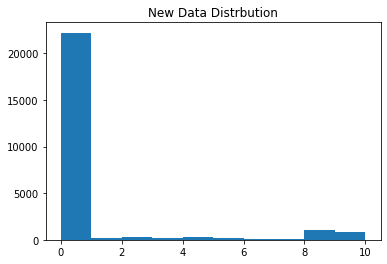

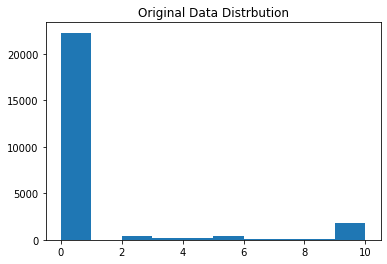

Adaptive model classifier evaluations
First 29000 Evaluation
Model accuracy score for incoming stream: 0.9760239760239761
F1 score for incoming streams: 0.9683662054443097
recall score for incoming streams: 0.9760239760239761
precision score for incoming streams: 0.9680476640406953
####################################
Static model classifier evaluations
First 29000 Evaluation
Model accuracy score for incoming stream: 0.8561438561438561
F1 score for incoming streams: 0.8551689274580841
recall score for incoming streams: 0.8561438561438561
precision score for incoming streams: 0.8551570380838673
####################################
0:	learn: 1.5643785	total: 544ms	remaining: 2.17s
1:	learn: 1.2616458	total: 1.07s	remaining: 1.61s
2:	learn: 1.0623022	total: 1.64s	remaining: 1.09s
3:	learn: 0.9177124	total: 2.17s	remaining: 542ms
4:	learn: 0.8037088	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


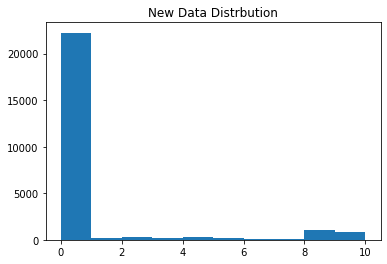

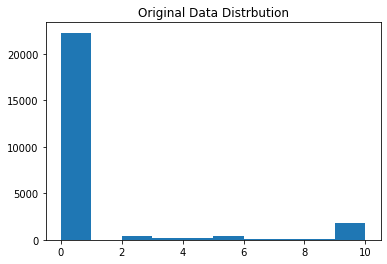

Adaptive model classifier evaluations
First 30000 Evaluation
Model accuracy score for incoming stream: 0.9120879120879121
F1 score for incoming streams: 0.9070318419648483
recall score for incoming streams: 0.9120879120879121
precision score for incoming streams: 0.9046520121908148
####################################
Static model classifier evaluations
First 30000 Evaluation
Model accuracy score for incoming stream: 0.98001998001998
F1 score for incoming streams: 0.9731206507714232
recall score for incoming streams: 0.98001998001998
precision score for incoming streams: 0.9724179815744743
####################################
0:	learn: 1.5673837	total: 536ms	remaining: 2.15s
1:	learn: 1.2637392	total: 1.07s	remaining: 1.61s
2:	learn: 1.0632479	total: 1.61s	remaining: 1.07s
3:	learn: 0.9154463	total: 2.15s	remaining: 537ms
4:	learn: 0.8016951	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


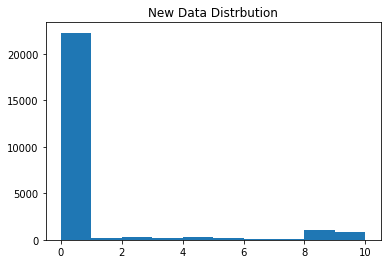

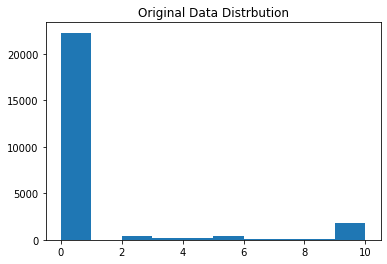

Adaptive model classifier evaluations
First 31000 Evaluation
Model accuracy score for incoming stream: 0.8861138861138861
F1 score for incoming streams: 0.8815102506290364
recall score for incoming streams: 0.8861138861138861
precision score for incoming streams: 0.8799959801715288
####################################
Static model classifier evaluations
First 31000 Evaluation
Model accuracy score for incoming stream: 0.987012987012987
F1 score for incoming streams: 0.9817988835918275
recall score for incoming streams: 0.987012987012987
precision score for incoming streams: 0.9777212103739407
####################################
0:	learn: 1.5624812	total: 540ms	remaining: 2.16s
1:	learn: 1.2599623	total: 1.07s	remaining: 1.61s
2:	learn: 1.0622037	total: 1.64s	remaining: 1.09s
3:	learn: 0.9159821	total: 2.17s	remaining: 543ms
4:	learn: 0.8029588	total: 2.72s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


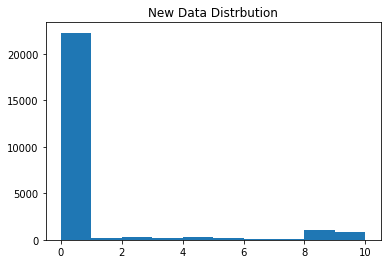

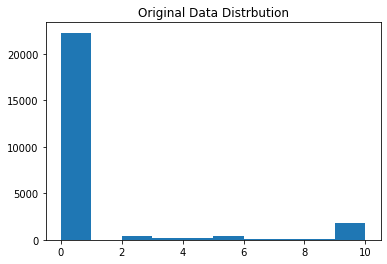

Adaptive model classifier evaluations
First 32000 Evaluation
Model accuracy score for incoming stream: 0.972027972027972
F1 score for incoming streams: 0.9618317419358483
recall score for incoming streams: 0.972027972027972
precision score for incoming streams: 0.9603694196305406
####################################
Static model classifier evaluations
First 32000 Evaluation
Model accuracy score for incoming stream: 0.8641358641358642
F1 score for incoming streams: 0.8631635031635031
recall score for incoming streams: 0.8641358641358642
precision score for incoming streams: 0.8631503631503632
####################################
0:	learn: 1.5661647	total: 523ms	remaining: 2.09s
1:	learn: 1.2627550	total: 1.06s	remaining: 1.59s
2:	learn: 1.0633138	total: 1.59s	remaining: 1.06s
3:	learn: 0.9182198	total: 2.13s	remaining: 531ms
4:	learn: 0.8038710	total: 2.65s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


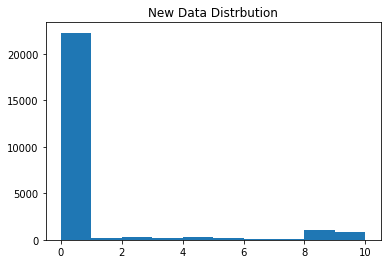

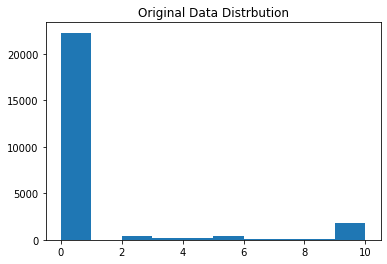

Adaptive model classifier evaluations
First 33000 Evaluation
Model accuracy score for incoming stream: 0.8801198801198801
F1 score for incoming streams: 0.8736349870910788
recall score for incoming streams: 0.8801198801198801
precision score for incoming streams: 0.8705681461395747
####################################
Static model classifier evaluations
First 33000 Evaluation
Model accuracy score for incoming stream: 0.986013986013986
F1 score for incoming streams: 0.981234938468117
recall score for incoming streams: 0.986013986013986
precision score for incoming streams: 0.9784461914896697
####################################
0:	learn: 1.5613427	total: 531ms	remaining: 2.13s
1:	learn: 1.2588403	total: 1.08s	remaining: 1.62s
2:	learn: 1.0611855	total: 1.61s	remaining: 1.07s
3:	learn: 0.9165050	total: 2.15s	remaining: 538ms
4:	learn: 0.8037781	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


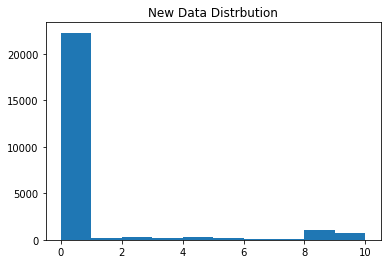

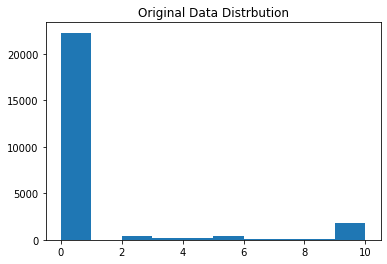

Adaptive model classifier evaluations
First 34000 Evaluation
Model accuracy score for incoming stream: 0.987012987012987
F1 score for incoming streams: 0.9822991123056599
recall score for incoming streams: 0.987012987012987
precision score for incoming streams: 0.9789391629104548
####################################
Static model classifier evaluations
First 34000 Evaluation
Model accuracy score for incoming stream: 0.8781218781218781
F1 score for incoming streams: 0.8778913394298009
recall score for incoming streams: 0.8781218781218781
precision score for incoming streams: 0.8777472527472527
####################################
0:	learn: 1.5579122	total: 534ms	remaining: 2.13s
1:	learn: 1.2558857	total: 1.08s	remaining: 1.62s
2:	learn: 1.0586716	total: 1.62s	remaining: 1.08s
3:	learn: 0.9136226	total: 2.16s	remaining: 540ms
4:	learn: 0.8001904	total: 2.7s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


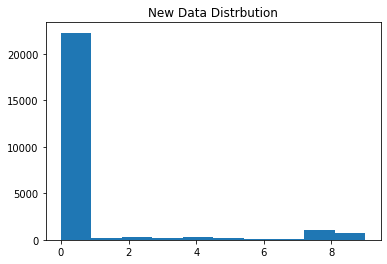

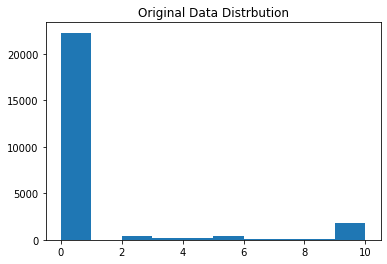

Adaptive model classifier evaluations
First 35000 Evaluation
Model accuracy score for incoming stream: 0.8911088911088911
F1 score for incoming streams: 0.8852211732064077
recall score for incoming streams: 0.8911088911088911
precision score for incoming streams: 0.8828438980981353
####################################
Static model classifier evaluations
First 35000 Evaluation
Model accuracy score for incoming stream: 0.985014985014985
F1 score for incoming streams: 0.9792246321171941
recall score for incoming streams: 0.985014985014985
precision score for incoming streams: 0.9767762281993781
####################################
0:	learn: 1.5437352	total: 478ms	remaining: 1.91s
1:	learn: 1.2492299	total: 980ms	remaining: 1.47s
2:	learn: 1.0532841	total: 1.48s	remaining: 986ms
3:	learn: 0.9091584	total: 1.96s	remaining: 491ms
4:	learn: 0.7967922	total: 2.46s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


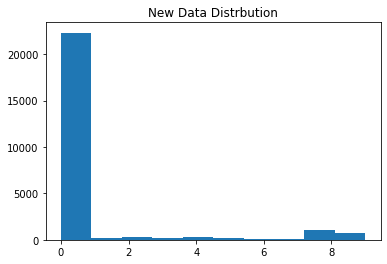

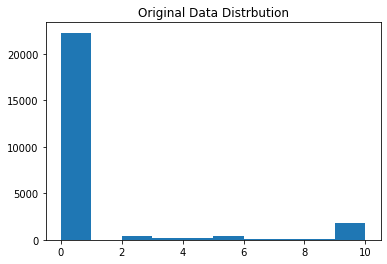

Adaptive model classifier evaluations
First 36000 Evaluation
Model accuracy score for incoming stream: 0.986013986013986
F1 score for incoming streams: 0.9813010972856866
recall score for incoming streams: 0.986013986013986
precision score for incoming streams: 0.9775887862980099
####################################
Static model classifier evaluations
First 36000 Evaluation
Model accuracy score for incoming stream: 0.8771228771228772
F1 score for incoming streams: 0.8771228771228772
recall score for incoming streams: 0.8771228771228772
precision score for incoming streams: 0.8771228771228772
####################################
0:	learn: 1.5458499	total: 486ms	remaining: 1.94s
1:	learn: 1.2502382	total: 983ms	remaining: 1.47s
2:	learn: 1.0536601	total: 1.46s	remaining: 975ms
3:	learn: 0.9091699	total: 1.96s	remaining: 490ms
4:	learn: 0.7965107	total: 2.45s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


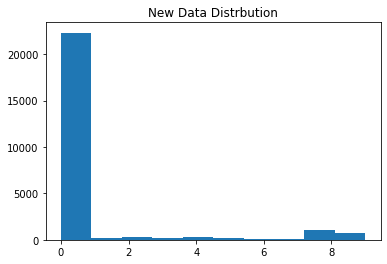

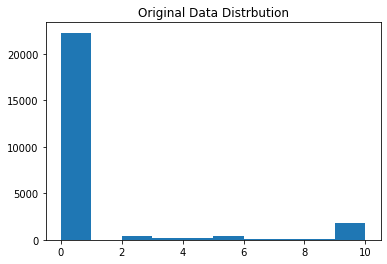

Adaptive model classifier evaluations
First 37000 Evaluation
Model accuracy score for incoming stream: 0.974025974025974
F1 score for incoming streams: 0.9655333565110026
recall score for incoming streams: 0.974025974025974
precision score for incoming streams: 0.962776947818537
####################################
Static model classifier evaluations
First 37000 Evaluation
Model accuracy score for incoming stream: 0.8671328671328671
F1 score for incoming streams: 0.8661582320118906
recall score for incoming streams: 0.8671328671328671
precision score for incoming streams: 0.8661461994795329
####################################
0:	learn: 1.5432672	total: 499ms	remaining: 1.99s
1:	learn: 1.2475943	total: 983ms	remaining: 1.47s
2:	learn: 1.0516345	total: 1.49s	remaining: 991ms
3:	learn: 0.9069480	total: 1.97s	remaining: 492ms
4:	learn: 0.7940575	total: 2.48s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


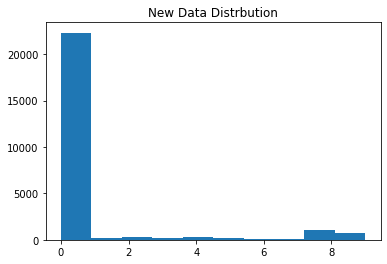

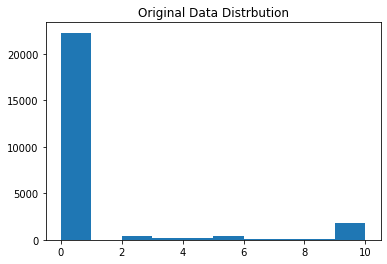

Adaptive model classifier evaluations
First 38000 Evaluation
Model accuracy score for incoming stream: 0.9790209790209791
F1 score for incoming streams: 0.9718821743080505
recall score for incoming streams: 0.9790209790209791
precision score for incoming streams: 0.9688781959941835
####################################
Static model classifier evaluations
First 38000 Evaluation
Model accuracy score for incoming stream: 0.8791208791208791
F1 score for incoming streams: 0.8791208791208791
recall score for incoming streams: 0.8791208791208791
precision score for incoming streams: 0.8791208791208791
####################################
0:	learn: 1.5490309	total: 484ms	remaining: 1.94s
1:	learn: 1.2503576	total: 991ms	remaining: 1.49s
2:	learn: 1.0525047	total: 1.49s	remaining: 992ms
3:	learn: 0.9089235	total: 2s	remaining: 500ms
4:	learn: 0.7951436	total: 2.49s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


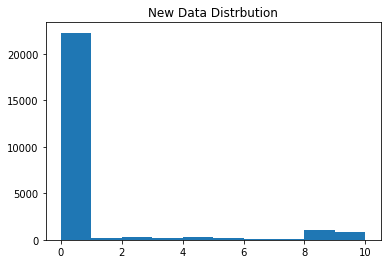

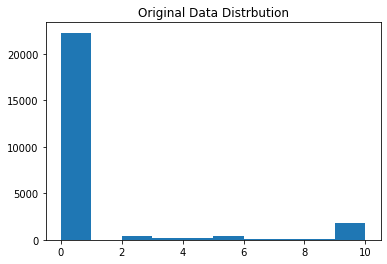

Adaptive model classifier evaluations
First 39000 Evaluation
Model accuracy score for incoming stream: 0.8591408591408591
F1 score for incoming streams: 0.8500224456964901
recall score for incoming streams: 0.8591408591408591
precision score for incoming streams: 0.8453743624796256
####################################
Static model classifier evaluations
First 39000 Evaluation
Model accuracy score for incoming stream: 0.98001998001998
F1 score for incoming streams: 0.9720844716935584
recall score for incoming streams: 0.98001998001998
precision score for incoming streams: 0.9671855921855922
####################################
0:	learn: 1.5635381	total: 549ms	remaining: 2.19s
1:	learn: 1.2637646	total: 1.09s	remaining: 1.64s
2:	learn: 1.0649018	total: 1.64s	remaining: 1.09s
3:	learn: 0.9186131	total: 2.19s	remaining: 546ms
4:	learn: 0.8041727	total: 2.75s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


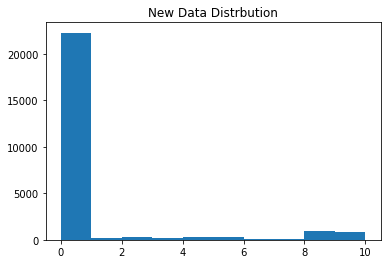

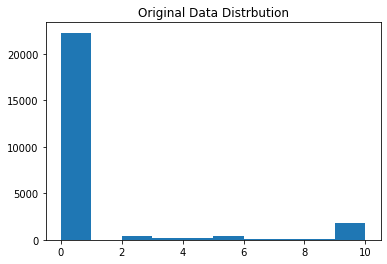

Adaptive model classifier evaluations
First 40000 Evaluation
Model accuracy score for incoming stream: 0.8811188811188811
F1 score for incoming streams: 0.8744637618380611
recall score for incoming streams: 0.8811188811188811
precision score for incoming streams: 0.8808995283199569
####################################
Static model classifier evaluations
First 40000 Evaluation
Model accuracy score for incoming stream: 0.987012987012987
F1 score for incoming streams: 0.9820529082430666
recall score for incoming streams: 0.987012987012987
precision score for incoming streams: 0.9786048563542169
####################################
0:	learn: 1.5693036	total: 537ms	remaining: 2.15s
1:	learn: 1.2655845	total: 1.08s	remaining: 1.62s
2:	learn: 1.0643888	total: 1.62s	remaining: 1.08s
3:	learn: 0.9180931	total: 2.16s	remaining: 540ms
4:	learn: 0.8033545	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


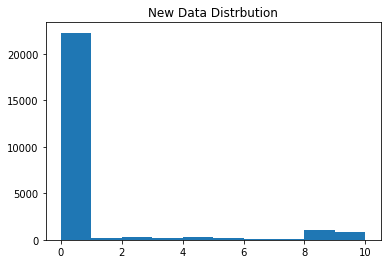

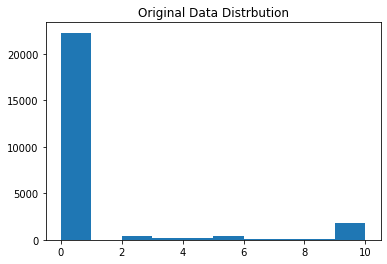

Adaptive model classifier evaluations
First 41000 Evaluation
Model accuracy score for incoming stream: 0.974025974025974
F1 score for incoming streams: 0.9697157614597316
recall score for incoming streams: 0.974025974025974
precision score for incoming streams: 0.9679019670674912
####################################
Static model classifier evaluations
First 41000 Evaluation
Model accuracy score for incoming stream: 0.8811188811188811
F1 score for incoming streams: 0.8801461696198538
recall score for incoming streams: 0.8811188811188811
precision score for incoming streams: 0.8801332001332001
####################################
0:	learn: 1.5602381	total: 529ms	remaining: 2.12s
1:	learn: 1.2612050	total: 1.06s	remaining: 1.59s
2:	learn: 1.0629440	total: 1.59s	remaining: 1.06s
3:	learn: 0.9168122	total: 2.12s	remaining: 530ms
4:	learn: 0.8035510	total: 2.65s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


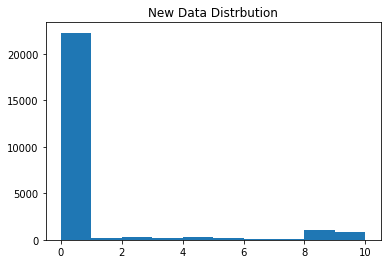

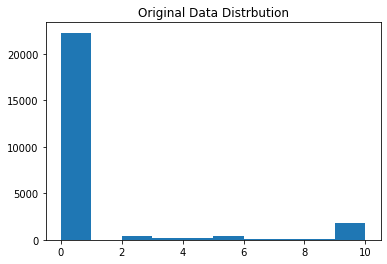

Adaptive model classifier evaluations
First 42000 Evaluation
Model accuracy score for incoming stream: 0.977022977022977
F1 score for incoming streams: 0.9695874134625421
recall score for incoming streams: 0.977022977022977
precision score for incoming streams: 0.964438347272904
####################################
Static model classifier evaluations
First 42000 Evaluation
Model accuracy score for incoming stream: 0.8731268731268731
F1 score for incoming streams: 0.8712430426716141
recall score for incoming streams: 0.8731268731268731
precision score for incoming streams: 0.8711876358935182
####################################
0:	learn: 1.5598576	total: 542ms	remaining: 2.17s
1:	learn: 1.2579456	total: 1.07s	remaining: 1.61s
2:	learn: 1.0588919	total: 1.61s	remaining: 1.07s
3:	learn: 0.9145186	total: 2.15s	remaining: 538ms
4:	learn: 0.8001009	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


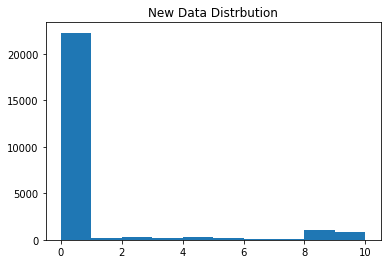

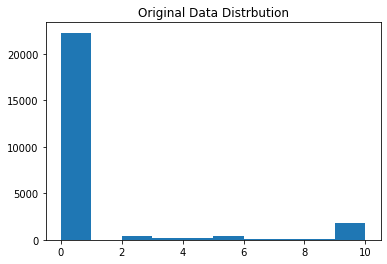

Adaptive model classifier evaluations
First 43000 Evaluation
Model accuracy score for incoming stream: 0.8741258741258742
F1 score for incoming streams: 0.8679158819627046
recall score for incoming streams: 0.8741258741258742
precision score for incoming streams: 0.872559583273869
####################################
Static model classifier evaluations
First 43000 Evaluation
Model accuracy score for incoming stream: 0.981018981018981
F1 score for incoming streams: 0.9753712953712954
recall score for incoming streams: 0.981018981018981
precision score for incoming streams: 0.9729130518604203
####################################
0:	learn: 1.5597823	total: 528ms	remaining: 2.11s
1:	learn: 1.2580186	total: 1.06s	remaining: 1.58s
2:	learn: 1.0605799	total: 1.6s	remaining: 1.06s
3:	learn: 0.9160168	total: 2.12s	remaining: 530ms
4:	learn: 0.8030838	total: 2.67s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


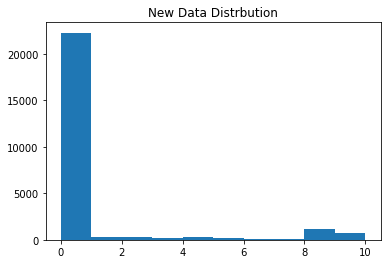

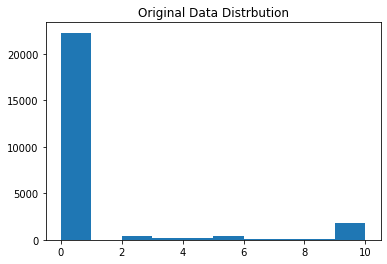

Adaptive model classifier evaluations
First 44000 Evaluation
Model accuracy score for incoming stream: 0.977022977022977
F1 score for incoming streams: 0.9697942423386119
recall score for incoming streams: 0.977022977022977
precision score for incoming streams: 0.9654468168454182
####################################
Static model classifier evaluations
First 44000 Evaluation
Model accuracy score for incoming stream: 0.8621378621378621
F1 score for incoming streams: 0.8611641523033927
recall score for incoming streams: 0.8621378621378621
precision score for incoming streams: 0.8611516688439765
####################################
0:	learn: 1.5587976	total: 530ms	remaining: 2.12s
1:	learn: 1.2536139	total: 1.05s	remaining: 1.58s
2:	learn: 1.0568055	total: 1.59s	remaining: 1.06s
3:	learn: 0.9119733	total: 2.14s	remaining: 534ms
4:	learn: 0.7992954	total: 2.67s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


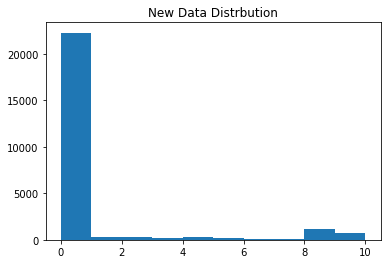

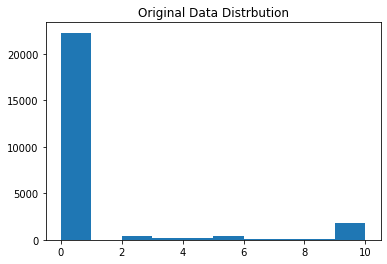

Adaptive model classifier evaluations
First 45000 Evaluation
Model accuracy score for incoming stream: 0.9820179820179821
F1 score for incoming streams: 0.975387550812956
recall score for incoming streams: 0.9820179820179821
precision score for incoming streams: 0.9708615032344743
####################################
Static model classifier evaluations
First 45000 Evaluation
Model accuracy score for incoming stream: 0.8711288711288712
F1 score for incoming streams: 0.8701565101565101
recall score for incoming streams: 0.8711288711288712
precision score for incoming streams: 0.8701433701433702
####################################
0:	learn: 1.5615808	total: 534ms	remaining: 2.13s
1:	learn: 1.2583835	total: 1.07s	remaining: 1.6s
2:	learn: 1.0603542	total: 1.6s	remaining: 1.06s
3:	learn: 0.9157432	total: 2.13s	remaining: 533ms
4:	learn: 0.8007648	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


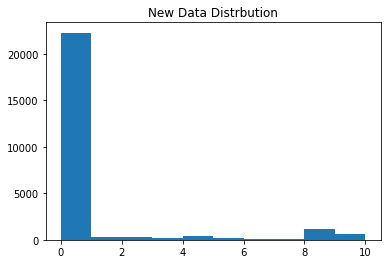

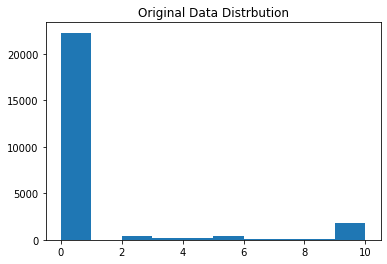

Adaptive model classifier evaluations
First 46000 Evaluation
Model accuracy score for incoming stream: 0.975024975024975
F1 score for incoming streams: 0.966323130777541
recall score for incoming streams: 0.975024975024975
precision score for incoming streams: 0.9632868637346927
####################################
Static model classifier evaluations
First 46000 Evaluation
Model accuracy score for incoming stream: 0.8531468531468531
F1 score for incoming streams: 0.8521772345301757
recall score for incoming streams: 0.8531468531468531
precision score for incoming streams: 0.8521627626105238
####################################
0:	learn: 1.5646329	total: 539ms	remaining: 2.16s
1:	learn: 1.2647988	total: 1.07s	remaining: 1.61s
2:	learn: 1.0649161	total: 1.62s	remaining: 1.08s
3:	learn: 0.9191821	total: 2.16s	remaining: 540ms
4:	learn: 0.8048990	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


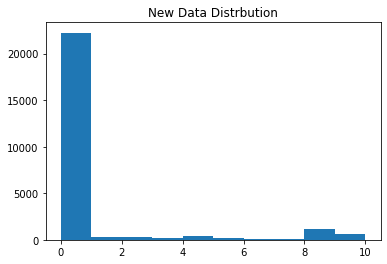

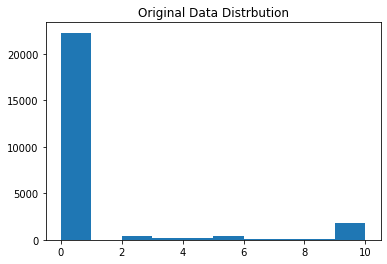

Adaptive model classifier evaluations
First 47000 Evaluation
Model accuracy score for incoming stream: 0.8711288711288712
F1 score for incoming streams: 0.8623722727304945
recall score for incoming streams: 0.8711288711288712
precision score for incoming streams: 0.8623776686276685
####################################
Static model classifier evaluations
First 47000 Evaluation
Model accuracy score for incoming stream: 0.9790209790209791
F1 score for incoming streams: 0.9714688404747407
recall score for incoming streams: 0.9790209790209791
precision score for incoming streams: 0.9677028576900206
####################################
0:	learn: 1.5651985	total: 542ms	remaining: 2.17s
1:	learn: 1.2606492	total: 1.07s	remaining: 1.61s
2:	learn: 1.0600329	total: 1.61s	remaining: 1.07s
3:	learn: 0.9157491	total: 2.15s	remaining: 538ms
4:	learn: 0.8010014	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


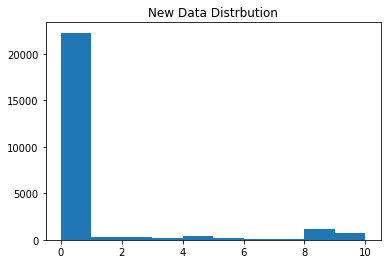

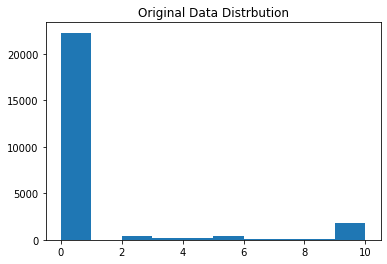

Adaptive model classifier evaluations
First 48000 Evaluation
Model accuracy score for incoming stream: 0.8851148851148851
F1 score for incoming streams: 0.876987177901211
recall score for incoming streams: 0.8851148851148851
precision score for incoming streams: 0.8716246683240438
####################################
Static model classifier evaluations
First 48000 Evaluation
Model accuracy score for incoming stream: 0.983016983016983
F1 score for incoming streams: 0.976697419170013
recall score for incoming streams: 0.983016983016983
precision score for incoming streams: 0.9733364159060753
####################################
0:	learn: 1.5581350	total: 541ms	remaining: 2.16s
1:	learn: 1.2599653	total: 1.08s	remaining: 1.63s
2:	learn: 1.0614164	total: 1.64s	remaining: 1.09s
3:	learn: 0.9157403	total: 2.19s	remaining: 546ms
4:	learn: 0.8022252	total: 2.74s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


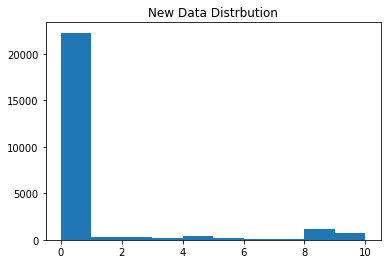

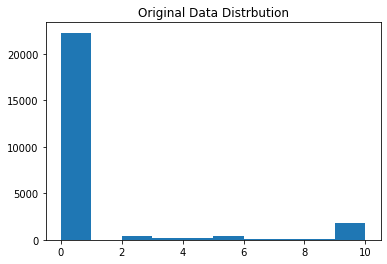

Adaptive model classifier evaluations
First 49000 Evaluation
Model accuracy score for incoming stream: 0.98001998001998
F1 score for incoming streams: 0.9738229354410218
recall score for incoming streams: 0.98001998001998
precision score for incoming streams: 0.9702198865255279
####################################
Static model classifier evaluations
First 49000 Evaluation
Model accuracy score for incoming stream: 0.8621378621378621
F1 score for incoming streams: 0.8616650720998547
recall score for incoming streams: 0.8621378621378621
precision score for incoming streams: 0.862151547083054
####################################
0:	learn: 1.5582316	total: 532ms	remaining: 2.13s
1:	learn: 1.2542972	total: 1.14s	remaining: 1.71s
2:	learn: 1.0570609	total: 1.69s	remaining: 1.13s
3:	learn: 0.9126607	total: 2.22s	remaining: 554ms
4:	learn: 0.7989574	total: 2.76s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


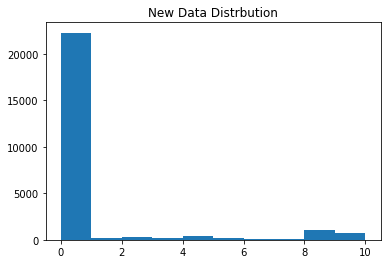

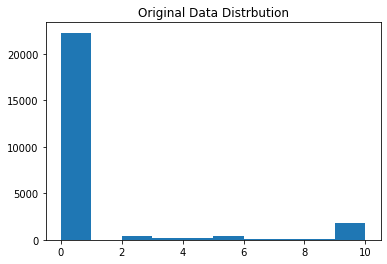

Adaptive model classifier evaluations
First 50000 Evaluation
Model accuracy score for incoming stream: 0.8791208791208791
F1 score for incoming streams: 0.8750128659219569
recall score for incoming streams: 0.8791208791208791
precision score for incoming streams: 0.8743449532923218
####################################
Static model classifier evaluations
First 50000 Evaluation
Model accuracy score for incoming stream: 0.9820179820179821
F1 score for incoming streams: 0.9759158590327423
recall score for incoming streams: 0.9820179820179821
precision score for incoming streams: 0.9732742195148211
####################################
0:	learn: 1.5630058	total: 559ms	remaining: 2.23s
1:	learn: 1.2565605	total: 1.11s	remaining: 1.67s
2:	learn: 1.0578513	total: 1.65s	remaining: 1.1s
3:	learn: 0.9133657	total: 2.18s	remaining: 545ms
4:	learn: 0.7999254	total: 2.72s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


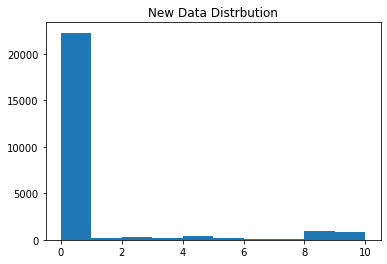

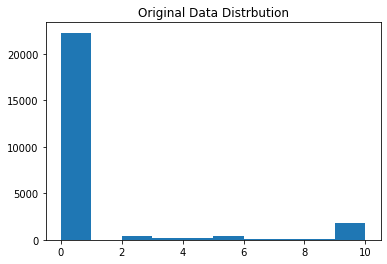

Adaptive model classifier evaluations
First 51000 Evaluation
Model accuracy score for incoming stream: 0.8811188811188811
F1 score for incoming streams: 0.874498103871989
recall score for incoming streams: 0.8811188811188811
precision score for incoming streams: 0.8720441734393162
####################################
Static model classifier evaluations
First 51000 Evaluation
Model accuracy score for incoming stream: 0.9820179820179821
F1 score for incoming streams: 0.9754901072194306
recall score for incoming streams: 0.9820179820179821
precision score for incoming streams: 0.9723421346928275
####################################
0:	learn: 1.5650057	total: 531ms	remaining: 2.12s
1:	learn: 1.2660622	total: 1.08s	remaining: 1.62s
2:	learn: 1.0654524	total: 1.62s	remaining: 1.08s
3:	learn: 0.9202415	total: 2.16s	remaining: 539ms
4:	learn: 0.8058843	total: 2.73s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


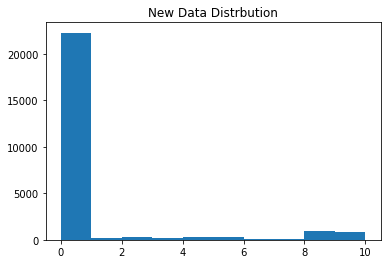

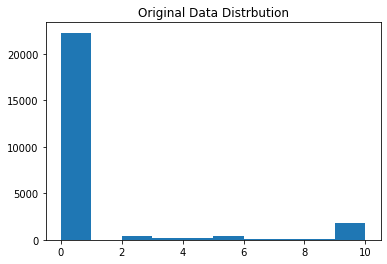

Adaptive model classifier evaluations
First 52000 Evaluation
Model accuracy score for incoming stream: 0.8921078921078921
F1 score for incoming streams: 0.8860988640477101
recall score for incoming streams: 0.8921078921078921
precision score for incoming streams: 0.8849659885653552
####################################
Static model classifier evaluations
First 52000 Evaluation
Model accuracy score for incoming stream: 0.989010989010989
F1 score for incoming streams: 0.9846747722323759
recall score for incoming streams: 0.989010989010989
precision score for incoming streams: 0.9823177177893713
####################################
0:	learn: 1.5636778	total: 527ms	remaining: 2.11s
1:	learn: 1.2612309	total: 1.07s	remaining: 1.61s
2:	learn: 1.0632663	total: 1.6s	remaining: 1.07s
3:	learn: 0.9187918	total: 2.14s	remaining: 535ms
4:	learn: 0.8041528	total: 2.66s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


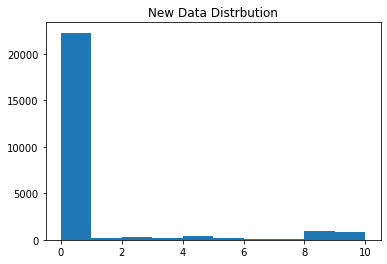

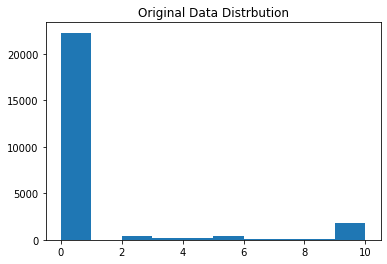

Adaptive model classifier evaluations
First 53000 Evaluation
Model accuracy score for incoming stream: 0.9460539460539461
F1 score for incoming streams: 0.9470308536854186
recall score for incoming streams: 0.9460539460539461
precision score for incoming streams: 0.9540032220583055
####################################
Static model classifier evaluations
First 53000 Evaluation
Model accuracy score for incoming stream: 0.8581418581418582
F1 score for incoming streams: 0.8581418581418582
recall score for incoming streams: 0.8581418581418582
precision score for incoming streams: 0.8581418581418582
####################################
0:	learn: 1.5625434	total: 523ms	remaining: 2.09s
1:	learn: 1.2601253	total: 1.06s	remaining: 1.59s
2:	learn: 1.0605629	total: 1.61s	remaining: 1.07s
3:	learn: 0.9158282	total: 2.15s	remaining: 537ms
4:	learn: 0.8020337	total: 2.68s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


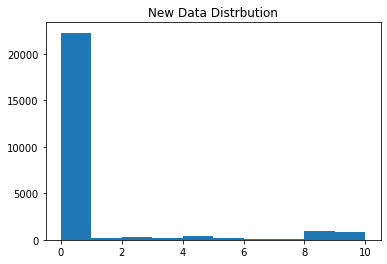

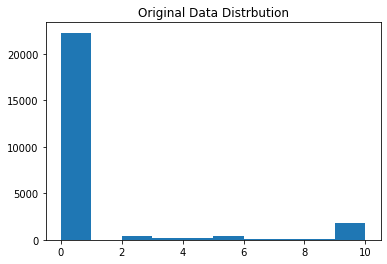

Adaptive model classifier evaluations
First 54000 Evaluation
Model accuracy score for incoming stream: 0.98001998001998
F1 score for incoming streams: 0.974694713429012
recall score for incoming streams: 0.98001998001998
precision score for incoming streams: 0.9722454766368661
####################################
Static model classifier evaluations
First 54000 Evaluation
Model accuracy score for incoming stream: 0.8731268731268731
F1 score for incoming streams: 0.87073481487597
recall score for incoming streams: 0.8731268731268731
precision score for incoming streams: 0.8701850145149114
####################################
0:	learn: 1.5661926	total: 528ms	remaining: 2.11s
1:	learn: 1.2623461	total: 1.08s	remaining: 1.62s
2:	learn: 1.0637253	total: 1.61s	remaining: 1.07s
3:	learn: 0.9192558	total: 2.15s	remaining: 536ms
4:	learn: 0.8050790	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


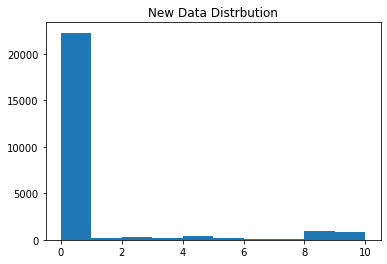

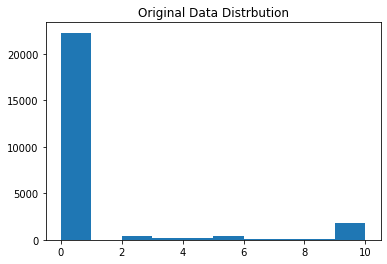

Adaptive model classifier evaluations
First 55000 Evaluation
Model accuracy score for incoming stream: 0.961038961038961
F1 score for incoming streams: 0.9536181647686495
recall score for incoming streams: 0.961038961038961
precision score for incoming streams: 0.9493430990154452
####################################
Static model classifier evaluations
First 55000 Evaluation
Model accuracy score for incoming stream: 0.8651348651348651
F1 score for incoming streams: 0.8632406554484476
recall score for incoming streams: 0.8651348651348651
precision score for incoming streams: 0.8631901431901431
####################################
0:	learn: 1.5592900	total: 531ms	remaining: 2.13s
1:	learn: 1.2572926	total: 1.07s	remaining: 1.6s
2:	learn: 1.0595740	total: 1.6s	remaining: 1.06s
3:	learn: 0.9149483	total: 2.13s	remaining: 534ms
4:	learn: 0.8018180	total: 2.67s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


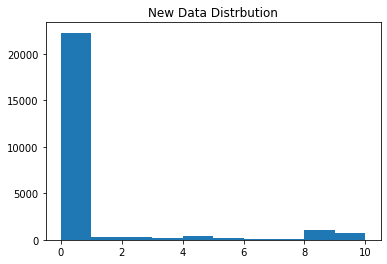

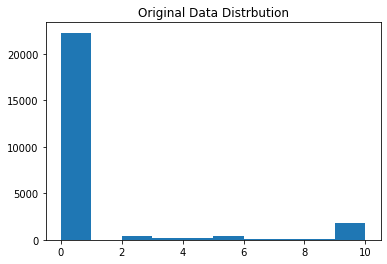

Adaptive model classifier evaluations
First 56000 Evaluation
Model accuracy score for incoming stream: 0.978021978021978
F1 score for incoming streams: 0.9707157314996144
recall score for incoming streams: 0.978021978021978
precision score for incoming streams: 0.9651788185751373
####################################
Static model classifier evaluations
First 56000 Evaluation
Model accuracy score for incoming stream: 0.8751248751248751
F1 score for incoming streams: 0.8751248751248751
recall score for incoming streams: 0.8751248751248751
precision score for incoming streams: 0.8751248751248751
####################################
0:	learn: 1.5607389	total: 533ms	remaining: 2.13s
1:	learn: 1.2585133	total: 1.08s	remaining: 1.62s
2:	learn: 1.0595320	total: 1.62s	remaining: 1.08s
3:	learn: 0.9156954	total: 2.16s	remaining: 540ms
4:	learn: 0.8018930	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


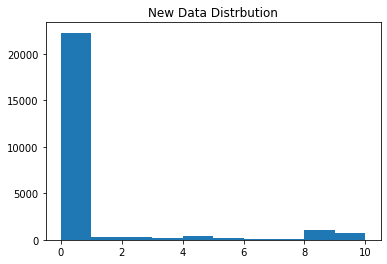

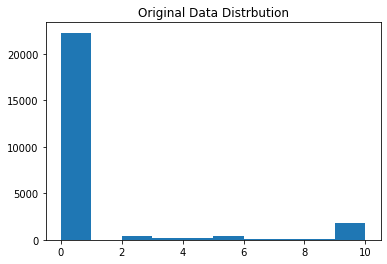

Adaptive model classifier evaluations
First 57000 Evaluation
Model accuracy score for incoming stream: 0.978021978021978
F1 score for incoming streams: 0.9707298041027096
recall score for incoming streams: 0.978021978021978
precision score for incoming streams: 0.9696400810459165
####################################
Static model classifier evaluations
First 57000 Evaluation
Model accuracy score for incoming stream: 0.8671328671328671
F1 score for incoming streams: 0.8661605061605061
recall score for incoming streams: 0.8671328671328671
precision score for incoming streams: 0.8661473661473662
####################################
0:	learn: 1.5584276	total: 538ms	remaining: 2.15s
1:	learn: 1.2571457	total: 1.08s	remaining: 1.62s
2:	learn: 1.0584049	total: 1.63s	remaining: 1.08s
3:	learn: 0.9146109	total: 2.2s	remaining: 549ms
4:	learn: 0.8015864	total: 2.75s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


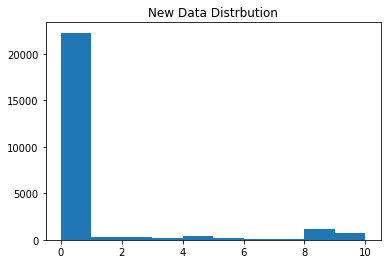

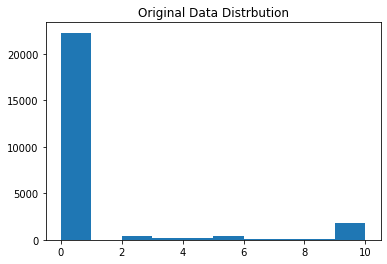

Adaptive model classifier evaluations
First 58000 Evaluation
Model accuracy score for incoming stream: 0.983016983016983
F1 score for incoming streams: 0.9786203571590953
recall score for incoming streams: 0.983016983016983
precision score for incoming streams: 0.9766270886400757
####################################
Static model classifier evaluations
First 58000 Evaluation
Model accuracy score for incoming stream: 0.8591408591408591
F1 score for incoming streams: 0.8596400694018358
recall score for incoming streams: 0.8591408591408591
precision score for incoming streams: 0.8601398601398601
####################################
0:	learn: 1.5609378	total: 527ms	remaining: 2.11s
1:	learn: 1.2576858	total: 1.08s	remaining: 1.62s
2:	learn: 1.0585559	total: 1.64s	remaining: 1.09s
3:	learn: 0.9125067	total: 2.19s	remaining: 547ms
4:	learn: 0.7992136	total: 2.72s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


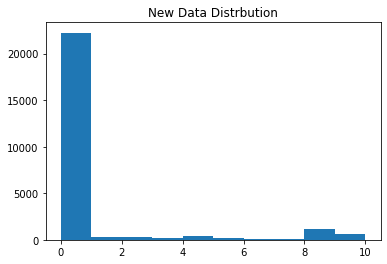

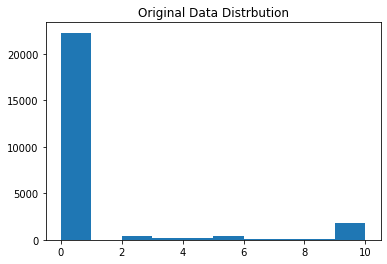

Adaptive model classifier evaluations
First 59000 Evaluation
Model accuracy score for incoming stream: 0.9790209790209791
F1 score for incoming streams: 0.972621047258711
recall score for incoming streams: 0.9790209790209791
precision score for incoming streams: 0.9705395391712506
####################################
Static model classifier evaluations
First 59000 Evaluation
Model accuracy score for incoming stream: 0.8601398601398601
F1 score for incoming streams: 0.8601398601398601
recall score for incoming streams: 0.8601398601398601
precision score for incoming streams: 0.8601398601398601
####################################
0:	learn: 1.5602139	total: 538ms	remaining: 2.15s
1:	learn: 1.2571382	total: 1.08s	remaining: 1.61s
2:	learn: 1.0591156	total: 1.62s	remaining: 1.08s
3:	learn: 0.9126664	total: 2.17s	remaining: 542ms
4:	learn: 0.7994798	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


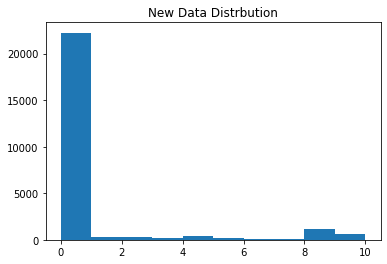

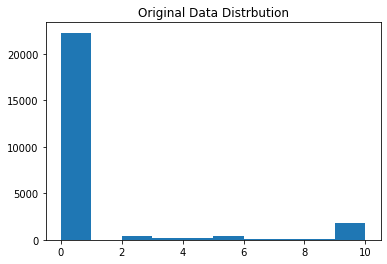

Adaptive model classifier evaluations
First 60000 Evaluation
Model accuracy score for incoming stream: 0.985014985014985
F1 score for incoming streams: 0.9795853430879166
recall score for incoming streams: 0.985014985014985
precision score for incoming streams: 0.9762601192349476
####################################
Static model classifier evaluations
First 60000 Evaluation
Model accuracy score for incoming stream: 0.8721278721278721
F1 score for incoming streams: 0.8702323317707933
recall score for incoming streams: 0.8721278721278721
precision score for incoming streams: 0.8701824491298176
####################################
0:	learn: 1.5595282	total: 520ms	remaining: 2.08s
1:	learn: 1.2533177	total: 1.09s	remaining: 1.64s
2:	learn: 1.0544671	total: 1.64s	remaining: 1.1s
3:	learn: 0.9073399	total: 2.19s	remaining: 547ms
4:	learn: 0.7939394	total: 2.73s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


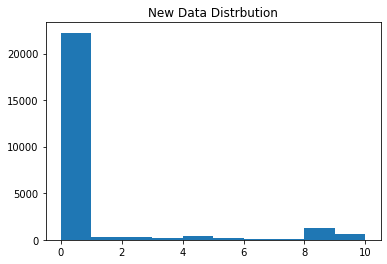

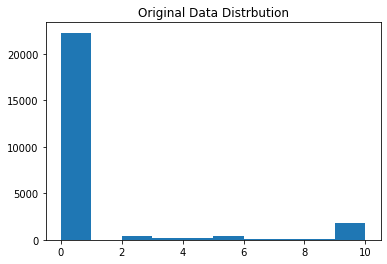

Adaptive model classifier evaluations
First 61000 Evaluation
Model accuracy score for incoming stream: 0.989010989010989
F1 score for incoming streams: 0.9860105522495893
recall score for incoming streams: 0.989010989010989
precision score for incoming streams: 0.9872652781392277
####################################
Static model classifier evaluations
First 61000 Evaluation
Model accuracy score for incoming stream: 0.8731268731268731
F1 score for incoming streams: 0.8731268731268731
recall score for incoming streams: 0.8731268731268731
precision score for incoming streams: 0.8731268731268731
####################################
0:	learn: 1.5676941	total: 527ms	remaining: 2.11s
1:	learn: 1.2564289	total: 1.08s	remaining: 1.62s
2:	learn: 1.0566995	total: 1.61s	remaining: 1.07s
3:	learn: 0.9114445	total: 2.17s	remaining: 541ms
4:	learn: 0.7976725	total: 2.7s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


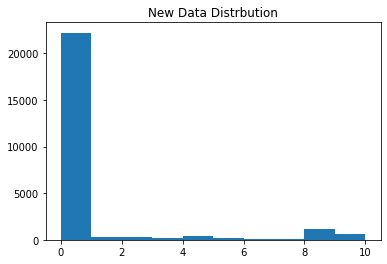

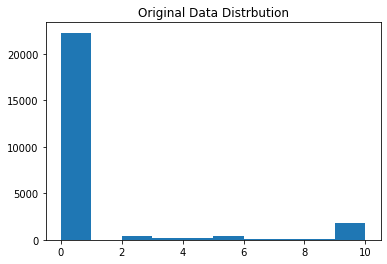

Adaptive model classifier evaluations
First 62000 Evaluation
Model accuracy score for incoming stream: 0.8811188811188811
F1 score for incoming streams: 0.873378579575433
recall score for incoming streams: 0.8811188811188811
precision score for incoming streams: 0.8698324964017866
####################################
Static model classifier evaluations
First 62000 Evaluation
Model accuracy score for incoming stream: 0.983016983016983
F1 score for incoming streams: 0.9765150059334838
recall score for incoming streams: 0.983016983016983
precision score for incoming streams: 0.9720937161235669
####################################
0:	learn: 1.5641856	total: 518ms	remaining: 2.07s
1:	learn: 1.2602215	total: 1.05s	remaining: 1.58s
2:	learn: 1.0618317	total: 1.59s	remaining: 1.06s
3:	learn: 0.9171585	total: 2.14s	remaining: 534ms
4:	learn: 0.8023019	total: 2.67s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


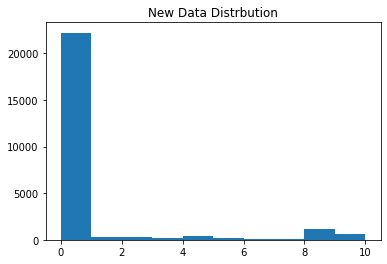

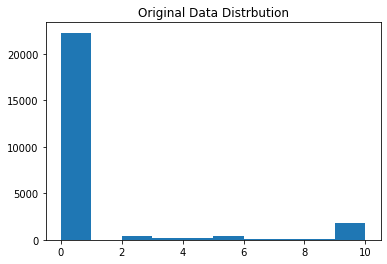

Adaptive model classifier evaluations
First 63000 Evaluation
Model accuracy score for incoming stream: 0.974025974025974
F1 score for incoming streams: 0.9658137826119915
recall score for incoming streams: 0.974025974025974
precision score for incoming streams: 0.9663719966099374
####################################
Static model classifier evaluations
First 63000 Evaluation
Model accuracy score for incoming stream: 0.8481518481518482
F1 score for incoming streams: 0.8466777133098281
recall score for incoming streams: 0.8481518481518482
precision score for incoming streams: 0.8461672057724803
####################################
0:	learn: 1.5615492	total: 530ms	remaining: 2.12s
1:	learn: 1.2628513	total: 1.09s	remaining: 1.63s
2:	learn: 1.0625932	total: 1.63s	remaining: 1.08s
3:	learn: 0.9169394	total: 2.18s	remaining: 544ms
4:	learn: 0.8021534	total: 2.72s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


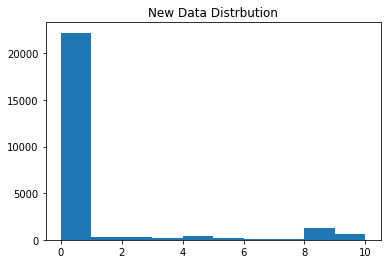

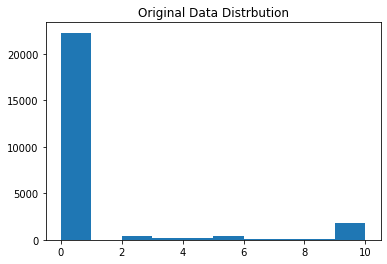

Adaptive model classifier evaluations
First 64000 Evaluation
Model accuracy score for incoming stream: 0.985014985014985
F1 score for incoming streams: 0.9780785991662796
recall score for incoming streams: 0.985014985014985
precision score for incoming streams: 0.972084306670773
####################################
Static model classifier evaluations
First 64000 Evaluation
Model accuracy score for incoming stream: 0.8721278721278721
F1 score for incoming streams: 0.8711529434421
recall score for incoming streams: 0.8721278721278721
precision score for incoming streams: 0.8711410540678833
####################################
0:	learn: 1.5580156	total: 530ms	remaining: 2.12s
1:	learn: 1.2552333	total: 1.05s	remaining: 1.58s
2:	learn: 1.0563845	total: 1.59s	remaining: 1.06s
3:	learn: 0.9121191	total: 2.13s	remaining: 532ms
4:	learn: 0.7988708	total: 2.68s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


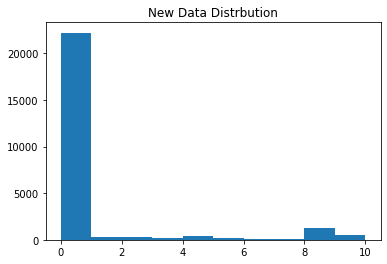

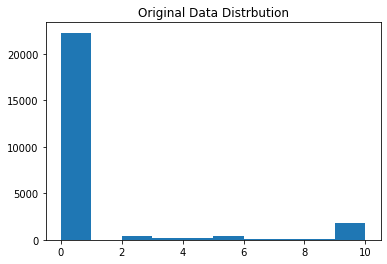

Adaptive model classifier evaluations
First 65000 Evaluation
Model accuracy score for incoming stream: 0.9790209790209791
F1 score for incoming streams: 0.9720212520029206
recall score for incoming streams: 0.9790209790209791
precision score for incoming streams: 0.9681195779010905
####################################
Static model classifier evaluations
First 65000 Evaluation
Model accuracy score for incoming stream: 0.8731268731268731
F1 score for incoming streams: 0.8731268731268731
recall score for incoming streams: 0.8731268731268731
precision score for incoming streams: 0.8731268731268731
####################################
0:	learn: 1.5544180	total: 525ms	remaining: 2.1s
1:	learn: 1.2484570	total: 1.09s	remaining: 1.63s
2:	learn: 1.0502398	total: 1.63s	remaining: 1.08s
3:	learn: 0.9050891	total: 2.16s	remaining: 540ms
4:	learn: 0.7914105	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


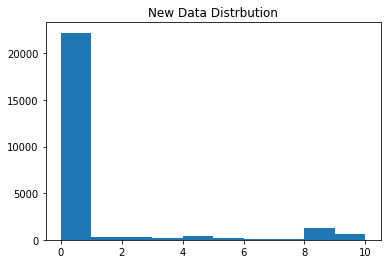

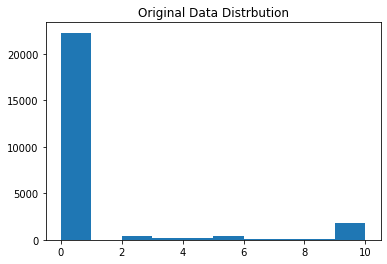

Adaptive model classifier evaluations
First 66000 Evaluation
Model accuracy score for incoming stream: 0.8661338661338661
F1 score for incoming streams: 0.8602267297919471
recall score for incoming streams: 0.8661338661338661
precision score for incoming streams: 0.8585202676111767
####################################
Static model classifier evaluations
First 66000 Evaluation
Model accuracy score for incoming stream: 0.985014985014985
F1 score for incoming streams: 0.9786436124850759
recall score for incoming streams: 0.985014985014985
precision score for incoming streams: 0.9738179889695042
####################################
0:	learn: 1.5611215	total: 536ms	remaining: 2.14s
1:	learn: 1.2541169	total: 1.07s	remaining: 1.61s
2:	learn: 1.0546060	total: 1.62s	remaining: 1.08s
3:	learn: 0.9096461	total: 2.15s	remaining: 537ms
4:	learn: 0.7958026	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


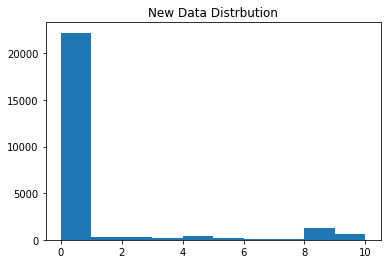

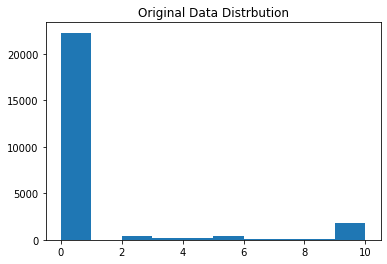

Adaptive model classifier evaluations
First 67000 Evaluation
Model accuracy score for incoming stream: 0.977022977022977
F1 score for incoming streams: 0.9682558075745142
recall score for incoming streams: 0.977022977022977
precision score for incoming streams: 0.9630472906509773
####################################
Static model classifier evaluations
First 67000 Evaluation
Model accuracy score for incoming stream: 0.8641358641358642
F1 score for incoming streams: 0.8631631526368369
recall score for incoming streams: 0.8641358641358642
precision score for incoming streams: 0.8631501831501831
####################################
0:	learn: 1.5571182	total: 536ms	remaining: 2.15s
1:	learn: 1.2538811	total: 1.07s	remaining: 1.6s
2:	learn: 1.0546094	total: 1.62s	remaining: 1.08s
3:	learn: 0.9073820	total: 2.15s	remaining: 539ms
4:	learn: 0.7937032	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


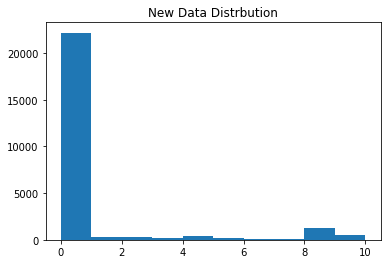

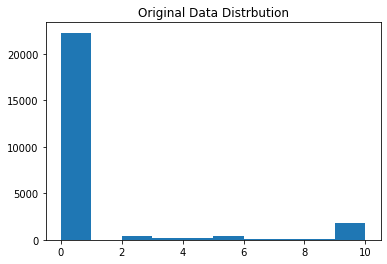

Adaptive model classifier evaluations
First 68000 Evaluation
Model accuracy score for incoming stream: 0.978021978021978
F1 score for incoming streams: 0.9709569410760834
recall score for incoming streams: 0.978021978021978
precision score for incoming streams: 0.9673593542506849
####################################
Static model classifier evaluations
First 68000 Evaluation
Model accuracy score for incoming stream: 0.8541458541458542
F1 score for incoming streams: 0.8541458541458542
recall score for incoming streams: 0.8541458541458542
precision score for incoming streams: 0.8541458541458542
####################################
0:	learn: 1.5619559	total: 525ms	remaining: 2.1s
1:	learn: 1.2546123	total: 1.07s	remaining: 1.61s
2:	learn: 1.0542697	total: 1.61s	remaining: 1.07s
3:	learn: 0.9075331	total: 2.16s	remaining: 541ms
4:	learn: 0.7931263	total: 2.7s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


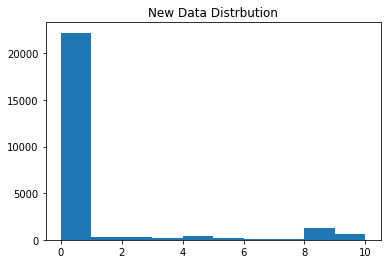

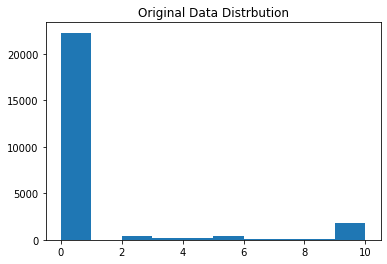

Adaptive model classifier evaluations
First 69000 Evaluation
Model accuracy score for incoming stream: 0.8891108891108891
F1 score for incoming streams: 0.8848199419627991
recall score for incoming streams: 0.8891108891108891
precision score for incoming streams: 0.8838239682395527
####################################
Static model classifier evaluations
First 69000 Evaluation
Model accuracy score for incoming stream: 0.985014985014985
F1 score for incoming streams: 0.9801946544286557
recall score for incoming streams: 0.985014985014985
precision score for incoming streams: 0.9770406302235128
####################################
0:	learn: 1.5623001	total: 540ms	remaining: 2.16s
1:	learn: 1.2566356	total: 1.09s	remaining: 1.64s
2:	learn: 1.0550817	total: 1.64s	remaining: 1.1s
3:	learn: 0.9094767	total: 2.2s	remaining: 550ms
4:	learn: 0.7948225	total: 2.74s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


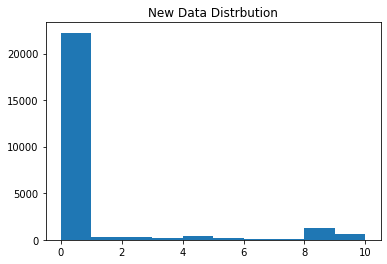

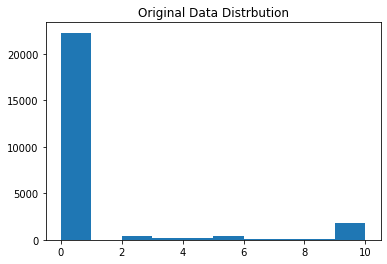

Adaptive model classifier evaluations
First 70000 Evaluation
Model accuracy score for incoming stream: 0.983016983016983
F1 score for incoming streams: 0.9770573320790007
recall score for incoming streams: 0.983016983016983
precision score for incoming streams: 0.974942784062389
####################################
Static model classifier evaluations
First 70000 Evaluation
Model accuracy score for incoming stream: 0.8811188811188811
F1 score for incoming streams: 0.8811188811188811
recall score for incoming streams: 0.8811188811188811
precision score for incoming streams: 0.8811188811188811
####################################
0:	learn: 1.5553343	total: 523ms	remaining: 2.09s
1:	learn: 1.2529142	total: 1.07s	remaining: 1.61s
2:	learn: 1.0540425	total: 1.61s	remaining: 1.07s
3:	learn: 0.9073286	total: 2.16s	remaining: 541ms
4:	learn: 0.7938541	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


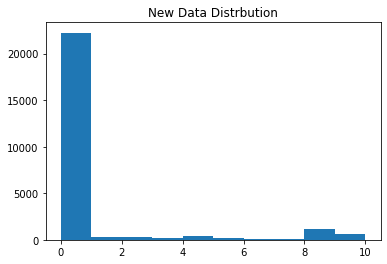

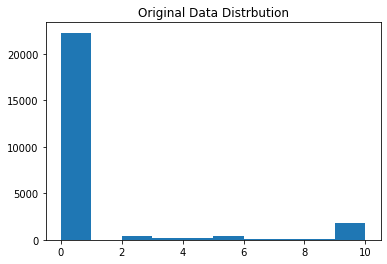

Adaptive model classifier evaluations
First 71000 Evaluation
Model accuracy score for incoming stream: 0.8891108891108891
F1 score for incoming streams: 0.8844177937226533
recall score for incoming streams: 0.8891108891108891
precision score for incoming streams: 0.8838328338328338
####################################
Static model classifier evaluations
First 71000 Evaluation
Model accuracy score for incoming stream: 0.987012987012987
F1 score for incoming streams: 0.9826133755700163
recall score for incoming streams: 0.987012987012987
precision score for incoming streams: 0.9794590025359255
####################################
0:	learn: 1.5572153	total: 533ms	remaining: 2.13s
1:	learn: 1.2569172	total: 1.08s	remaining: 1.62s
2:	learn: 1.0577918	total: 1.63s	remaining: 1.09s
3:	learn: 0.9123550	total: 2.17s	remaining: 544ms
4:	learn: 0.7992797	total: 2.72s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


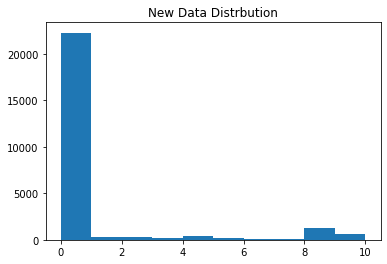

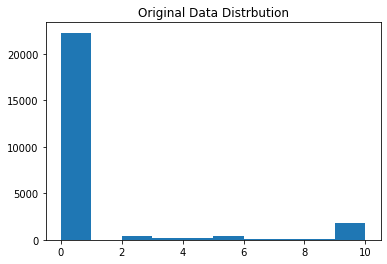

Adaptive model classifier evaluations
First 72000 Evaluation
Model accuracy score for incoming stream: 0.984015984015984
F1 score for incoming streams: 0.9772488226851985
recall score for incoming streams: 0.984015984015984
precision score for incoming streams: 0.97215084585685
####################################
Static model classifier evaluations
First 72000 Evaluation
Model accuracy score for incoming stream: 0.8721278721278721
F1 score for incoming streams: 0.8721278721278721
recall score for incoming streams: 0.8721278721278721
precision score for incoming streams: 0.8721278721278721
####################################
0:	learn: 1.5625403	total: 523ms	remaining: 2.09s
1:	learn: 1.2613309	total: 1.07s	remaining: 1.6s
2:	learn: 1.0586417	total: 1.62s	remaining: 1.08s
3:	learn: 0.9125652	total: 2.18s	remaining: 544ms
4:	learn: 0.7978100	total: 2.73s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


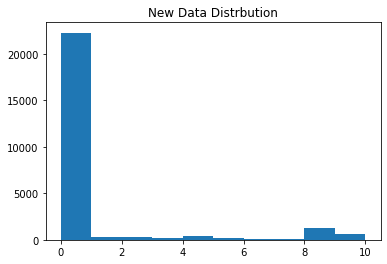

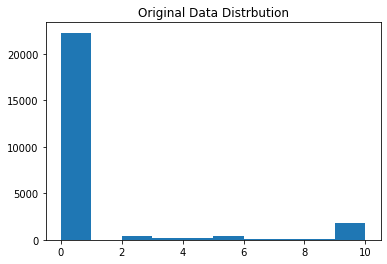

Adaptive model classifier evaluations
First 73000 Evaluation
Model accuracy score for incoming stream: 0.8761238761238761
F1 score for incoming streams: 0.8688476600937557
recall score for incoming streams: 0.8761238761238761
precision score for incoming streams: 0.8653119206456201
####################################
Static model classifier evaluations
First 73000 Evaluation
Model accuracy score for incoming stream: 0.984015984015984
F1 score for incoming streams: 0.9785148820510401
recall score for incoming streams: 0.984015984015984
precision score for incoming streams: 0.9763835313285862
####################################
0:	learn: 1.5607772	total: 544ms	remaining: 2.18s
1:	learn: 1.2522517	total: 1.1s	remaining: 1.65s
2:	learn: 1.0529790	total: 1.65s	remaining: 1.1s
3:	learn: 0.9080384	total: 2.23s	remaining: 558ms
4:	learn: 0.7938452	total: 2.78s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


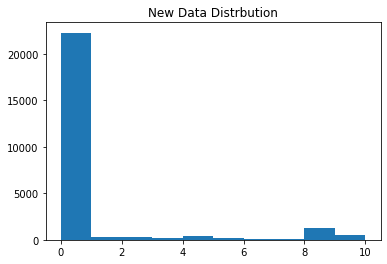

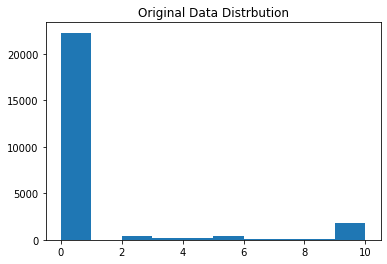

Adaptive model classifier evaluations
First 74000 Evaluation
Model accuracy score for incoming stream: 0.972027972027972
F1 score for incoming streams: 0.964271141566452
recall score for incoming streams: 0.972027972027972
precision score for incoming streams: 0.9615343416380039
####################################
Static model classifier evaluations
First 74000 Evaluation
Model accuracy score for incoming stream: 0.8611388611388612
F1 score for incoming streams: 0.8616380720728547
recall score for incoming streams: 0.8611388611388612
precision score for incoming streams: 0.8621378621378621
####################################
0:	learn: 1.5546350	total: 523ms	remaining: 2.09s
1:	learn: 1.2482676	total: 1.08s	remaining: 1.62s
2:	learn: 1.0494180	total: 1.62s	remaining: 1.08s
3:	learn: 0.9040996	total: 2.16s	remaining: 541ms
4:	learn: 0.7913356	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


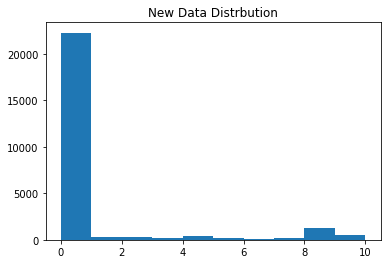

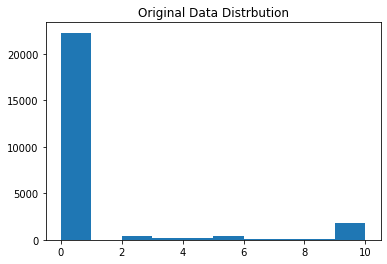

Adaptive model classifier evaluations
First 75000 Evaluation
Model accuracy score for incoming stream: 0.913086913086913
F1 score for incoming streams: 0.9065649731180637
recall score for incoming streams: 0.913086913086913
precision score for incoming streams: 0.9028761642398007
####################################
Static model classifier evaluations
First 75000 Evaluation
Model accuracy score for incoming stream: 0.8811188811188811
F1 score for incoming streams: 0.8811188811188811
recall score for incoming streams: 0.8811188811188811
precision score for incoming streams: 0.8811188811188811
####################################
0:	learn: 1.5567171	total: 529ms	remaining: 2.12s
1:	learn: 1.2543648	total: 1.07s	remaining: 1.61s
2:	learn: 1.0561392	total: 1.62s	remaining: 1.08s
3:	learn: 0.9117098	total: 2.15s	remaining: 538ms
4:	learn: 0.7987231	total: 2.7s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


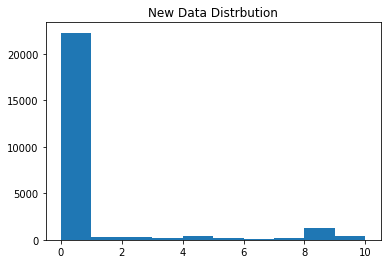

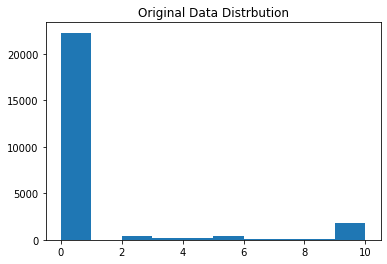

Adaptive model classifier evaluations
First 76000 Evaluation
Model accuracy score for incoming stream: 0.977022977022977
F1 score for incoming streams: 0.969318129792438
recall score for incoming streams: 0.977022977022977
precision score for incoming streams: 0.9696994302905633
####################################
Static model classifier evaluations
First 76000 Evaluation
Model accuracy score for incoming stream: 0.8791208791208791
F1 score for incoming streams: 0.8791208791208791
recall score for incoming streams: 0.8791208791208791
precision score for incoming streams: 0.8791208791208791
####################################
0:	learn: 1.5538982	total: 528ms	remaining: 2.11s
1:	learn: 1.2480488	total: 1.08s	remaining: 1.62s
2:	learn: 1.0514022	total: 1.64s	remaining: 1.09s
3:	learn: 0.9048166	total: 2.18s	remaining: 545ms
4:	learn: 0.7923758	total: 2.73s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


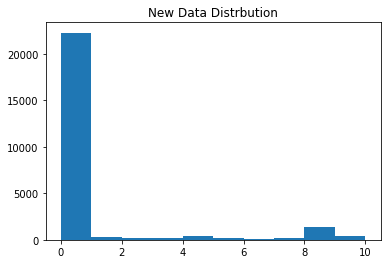

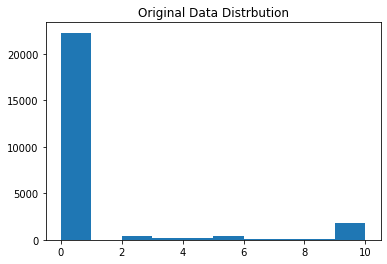

Adaptive model classifier evaluations
First 77000 Evaluation
Model accuracy score for incoming stream: 0.988011988011988
F1 score for incoming streams: 0.9834110736632927
recall score for incoming streams: 0.988011988011988
precision score for incoming streams: 0.9805435656297725
####################################
Static model classifier evaluations
First 77000 Evaluation
Model accuracy score for incoming stream: 0.8701298701298701
F1 score for incoming streams: 0.8701298701298701
recall score for incoming streams: 0.8701298701298701
precision score for incoming streams: 0.8701298701298701
####################################
0:	learn: 1.5495380	total: 542ms	remaining: 2.17s
1:	learn: 1.2437546	total: 1.08s	remaining: 1.63s
2:	learn: 1.0446072	total: 1.64s	remaining: 1.1s
3:	learn: 0.8994806	total: 2.19s	remaining: 546ms
4:	learn: 0.7870188	total: 2.73s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


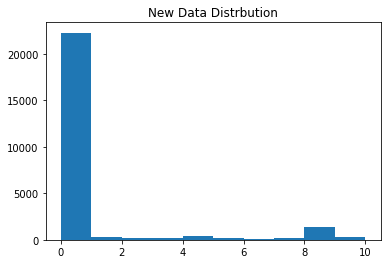

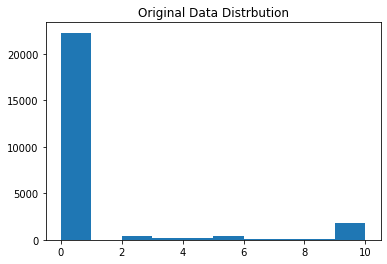

Adaptive model classifier evaluations
First 78000 Evaluation
Model accuracy score for incoming stream: 0.981018981018981
F1 score for incoming streams: 0.9742927455819441
recall score for incoming streams: 0.981018981018981
precision score for incoming streams: 0.9724225491458258
####################################
Static model classifier evaluations
First 78000 Evaluation
Model accuracy score for incoming stream: 0.8601398601398601
F1 score for incoming streams: 0.8591668072187553
recall score for incoming streams: 0.8601398601398601
precision score for incoming streams: 0.8591540038908461
####################################
0:	learn: 1.5471652	total: 534ms	remaining: 2.13s
1:	learn: 1.2405648	total: 1.07s	remaining: 1.61s
2:	learn: 1.0408719	total: 1.62s	remaining: 1.08s
3:	learn: 0.8949119	total: 2.17s	remaining: 543ms
4:	learn: 0.7812400	total: 2.72s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


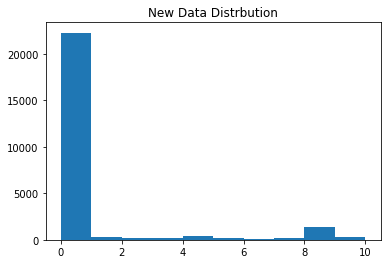

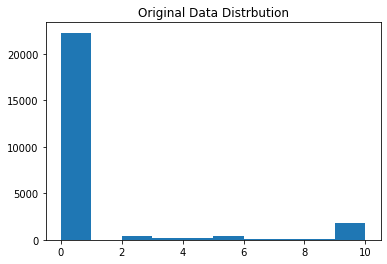

Adaptive model classifier evaluations
First 79000 Evaluation
Model accuracy score for incoming stream: 0.9820179820179821
F1 score for incoming streams: 0.9763465324771713
recall score for incoming streams: 0.9820179820179821
precision score for incoming streams: 0.9739698665827256
####################################
Static model classifier evaluations
First 79000 Evaluation
Model accuracy score for incoming stream: 0.8701298701298701
F1 score for incoming streams: 0.8691549414440981
recall score for incoming streams: 0.8701298701298701
precision score for incoming streams: 0.8691430520698813
####################################
0:	learn: 1.5483121	total: 529ms	remaining: 2.12s
1:	learn: 1.2404187	total: 1.06s	remaining: 1.59s
2:	learn: 1.0400260	total: 1.61s	remaining: 1.07s
3:	learn: 0.8952196	total: 2.14s	remaining: 535ms
4:	learn: 0.7817897	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


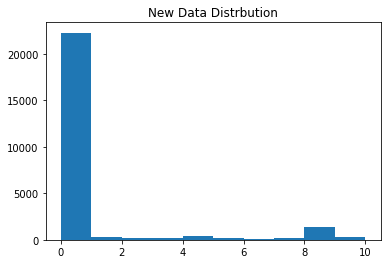

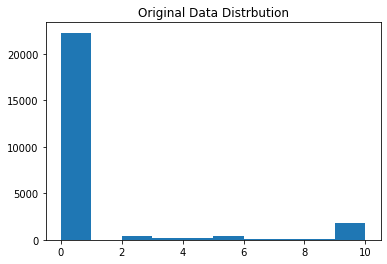

Adaptive model classifier evaluations
First 80000 Evaluation
Model accuracy score for incoming stream: 0.9820179820179821
F1 score for incoming streams: 0.975206182432096
recall score for incoming streams: 0.9820179820179821
precision score for incoming streams: 0.9714216218564045
####################################
Static model classifier evaluations
First 80000 Evaluation
Model accuracy score for incoming stream: 0.8681318681318682
F1 score for incoming streams: 0.8681318681318682
recall score for incoming streams: 0.8681318681318682
precision score for incoming streams: 0.8681318681318682
####################################
0:	learn: 1.5485623	total: 542ms	remaining: 2.17s
1:	learn: 1.2407287	total: 1.09s	remaining: 1.64s
2:	learn: 1.0414904	total: 1.65s	remaining: 1.1s
3:	learn: 0.8948749	total: 2.19s	remaining: 547ms
4:	learn: 0.7814926	total: 2.73s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


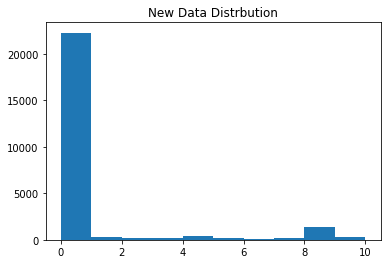

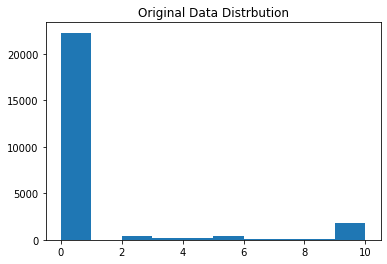

Adaptive model classifier evaluations
First 81000 Evaluation
Model accuracy score for incoming stream: 0.988011988011988
F1 score for incoming streams: 0.9836006396693574
recall score for incoming streams: 0.988011988011988
precision score for incoming streams: 0.9803001430518099
####################################
Static model classifier evaluations
First 81000 Evaluation
Model accuracy score for incoming stream: 0.8671328671328671
F1 score for incoming streams: 0.8661579384470951
recall score for incoming streams: 0.8671328671328671
precision score for incoming streams: 0.8661460490728783
####################################
0:	learn: 1.5508249	total: 534ms	remaining: 2.14s
1:	learn: 1.2438657	total: 1.09s	remaining: 1.63s
2:	learn: 1.0438768	total: 1.63s	remaining: 1.09s
3:	learn: 0.8982471	total: 2.17s	remaining: 544ms
4:	learn: 0.7844104	total: 2.72s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


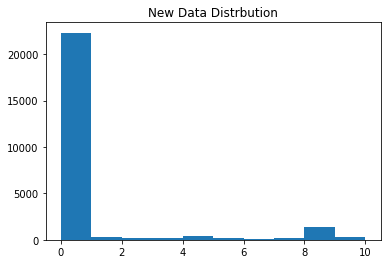

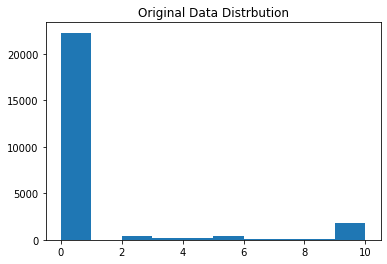

Adaptive model classifier evaluations
First 82000 Evaluation
Model accuracy score for incoming stream: 0.983016983016983
F1 score for incoming streams: 0.9763371743463909
recall score for incoming streams: 0.983016983016983
precision score for incoming streams: 0.9748231566413385
####################################
Static model classifier evaluations
First 82000 Evaluation
Model accuracy score for incoming stream: 0.8921078921078921
F1 score for incoming streams: 0.8911387120342343
recall score for incoming streams: 0.8921078921078921
precision score for incoming streams: 0.8911240274876638
####################################
0:	learn: 1.5509201	total: 539ms	remaining: 2.15s
1:	learn: 1.2461100	total: 1.09s	remaining: 1.64s
2:	learn: 1.0439131	total: 1.63s	remaining: 1.08s
3:	learn: 0.8973934	total: 2.17s	remaining: 542ms
4:	learn: 0.7843411	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


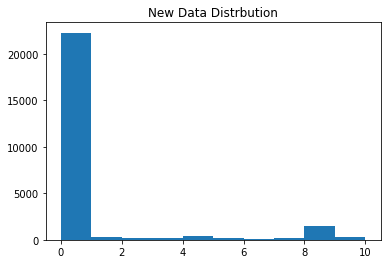

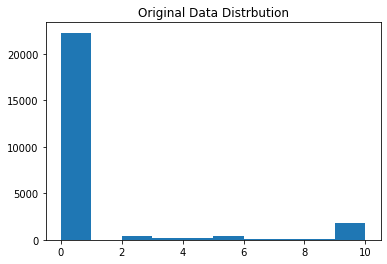

Adaptive model classifier evaluations
First 83000 Evaluation
Model accuracy score for incoming stream: 0.985014985014985
F1 score for incoming streams: 0.9805370479083563
recall score for incoming streams: 0.985014985014985
precision score for incoming streams: 0.9819614533698243
####################################
Static model classifier evaluations
First 83000 Evaluation
Model accuracy score for incoming stream: 0.8581418581418582
F1 score for incoming streams: 0.8581418581418582
recall score for incoming streams: 0.8581418581418582
precision score for incoming streams: 0.8581418581418582
####################################
0:	learn: 1.5473645	total: 539ms	remaining: 2.15s
1:	learn: 1.2431506	total: 1.08s	remaining: 1.62s
2:	learn: 1.0441357	total: 1.63s	remaining: 1.08s
3:	learn: 0.8992636	total: 2.17s	remaining: 541ms
4:	learn: 0.7844520	total: 2.72s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


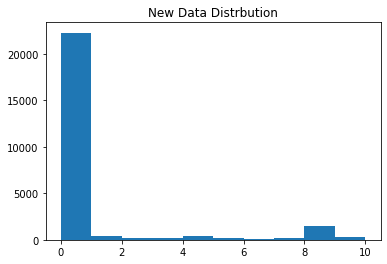

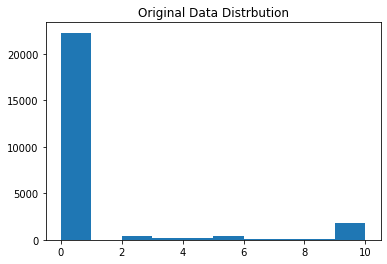

Adaptive model classifier evaluations
First 84000 Evaluation
Model accuracy score for incoming stream: 0.984015984015984
F1 score for incoming streams: 0.977679228558994
recall score for incoming streams: 0.984015984015984
precision score for incoming streams: 0.9725718122457253
####################################
Static model classifier evaluations
First 84000 Evaluation
Model accuracy score for incoming stream: 0.8661338661338661
F1 score for incoming streams: 0.866633078736825
recall score for incoming streams: 0.8661338661338661
precision score for incoming streams: 0.8671328671328671
####################################
0:	learn: 1.5468778	total: 545ms	remaining: 2.18s
1:	learn: 1.2429660	total: 1.1s	remaining: 1.65s
2:	learn: 1.0422964	total: 1.65s	remaining: 1.1s
3:	learn: 0.8957313	total: 2.2s	remaining: 549ms
4:	learn: 0.7818665	total: 2.75s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


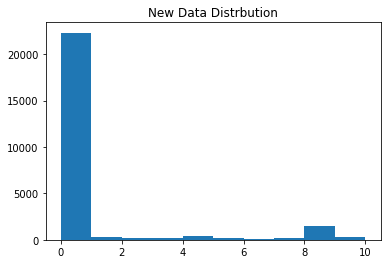

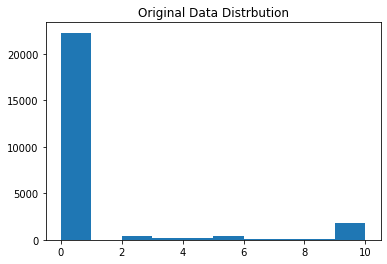

Adaptive model classifier evaluations
First 85000 Evaluation
Model accuracy score for incoming stream: 0.973026973026973
F1 score for incoming streams: 0.9638428247323934
recall score for incoming streams: 0.973026973026973
precision score for incoming streams: 0.9613158339864774
####################################
Static model classifier evaluations
First 85000 Evaluation
Model accuracy score for incoming stream: 0.8551448551448552
F1 score for incoming streams: 0.8556440640503687
recall score for incoming streams: 0.8551448551448552
precision score for incoming streams: 0.8561438561438561
####################################
0:	learn: 1.5460843	total: 535ms	remaining: 2.14s
1:	learn: 1.2394545	total: 1.09s	remaining: 1.63s
2:	learn: 1.0398021	total: 1.63s	remaining: 1.08s
3:	learn: 0.8954742	total: 2.17s	remaining: 544ms
4:	learn: 0.7814096	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


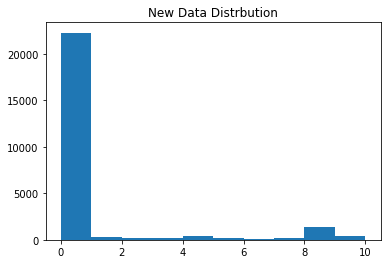

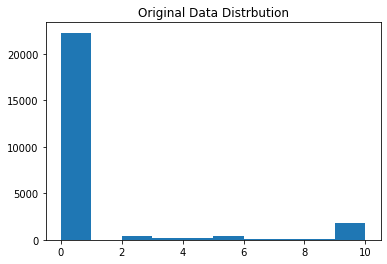

Adaptive model classifier evaluations
First 86000 Evaluation
Model accuracy score for incoming stream: 0.8741258741258742
F1 score for incoming streams: 0.8683651031829168
recall score for incoming streams: 0.8741258741258742
precision score for incoming streams: 0.8666371942234011
####################################
Static model classifier evaluations
First 86000 Evaluation
Model accuracy score for incoming stream: 0.985014985014985
F1 score for incoming streams: 0.9789875447133511
recall score for incoming streams: 0.985014985014985
precision score for incoming streams: 0.9748226713589899
####################################
0:	learn: 1.5571492	total: 527ms	remaining: 2.11s
1:	learn: 1.2522950	total: 1.08s	remaining: 1.61s
2:	learn: 1.0510760	total: 1.62s	remaining: 1.08s
3:	learn: 0.9041026	total: 2.16s	remaining: 541ms
4:	learn: 0.7898225	total: 2.69s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


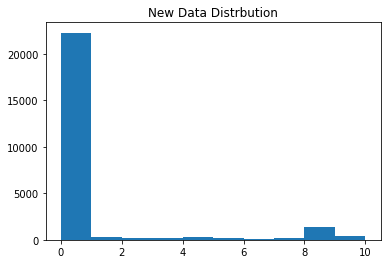

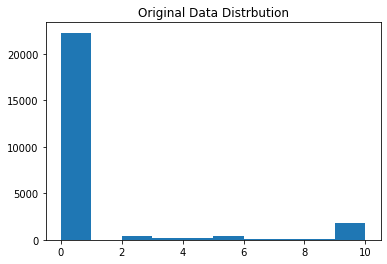

Adaptive model classifier evaluations
First 87000 Evaluation
Model accuracy score for incoming stream: 0.984015984015984
F1 score for incoming streams: 0.9787824438026076
recall score for incoming streams: 0.984015984015984
precision score for incoming streams: 0.9774417310795913
####################################
Static model classifier evaluations
First 87000 Evaluation
Model accuracy score for incoming stream: 0.8741258741258742
F1 score for incoming streams: 0.8741258741258742
recall score for incoming streams: 0.8741258741258742
precision score for incoming streams: 0.8741258741258742
####################################
0:	learn: 1.5605322	total: 538ms	remaining: 2.15s
1:	learn: 1.2555026	total: 1.08s	remaining: 1.62s
2:	learn: 1.0526781	total: 1.62s	remaining: 1.08s
3:	learn: 0.9074194	total: 2.15s	remaining: 539ms
4:	learn: 0.7926797	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


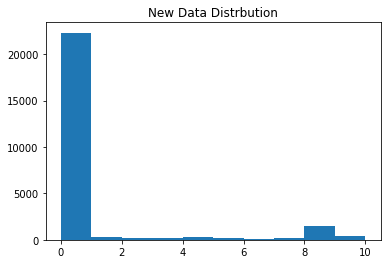

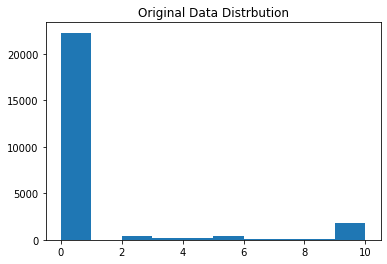

Adaptive model classifier evaluations
First 88000 Evaluation
Model accuracy score for incoming stream: 0.978021978021978
F1 score for incoming streams: 0.9705499837395907
recall score for incoming streams: 0.978021978021978
precision score for incoming streams: 0.9677652851471649
####################################
Static model classifier evaluations
First 88000 Evaluation
Model accuracy score for incoming stream: 0.8751248751248751
F1 score for incoming streams: 0.8751248751248751
recall score for incoming streams: 0.8751248751248751
precision score for incoming streams: 0.8751248751248751
####################################
0:	learn: 1.5467086	total: 526ms	remaining: 2.1s
1:	learn: 1.2415069	total: 1.07s	remaining: 1.61s
2:	learn: 1.0421038	total: 1.61s	remaining: 1.07s
3:	learn: 0.8965743	total: 2.16s	remaining: 541ms
4:	learn: 0.7820959	total: 2.7s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


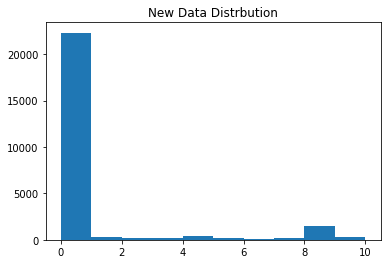

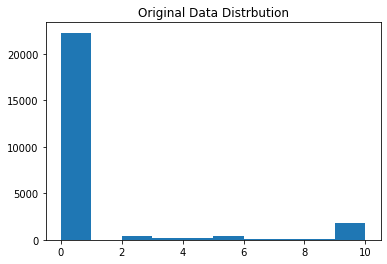

Adaptive model classifier evaluations
First 89000 Evaluation
Model accuracy score for incoming stream: 0.986013986013986
F1 score for incoming streams: 0.9812169776057246
recall score for incoming streams: 0.986013986013986
precision score for incoming streams: 0.9796391751825946
####################################
Static model classifier evaluations
First 89000 Evaluation
Model accuracy score for incoming stream: 0.8631368631368631
F1 score for incoming streams: 0.8631368631368631
recall score for incoming streams: 0.8631368631368631
precision score for incoming streams: 0.8631368631368631
####################################
0:	learn: 1.5542018	total: 557ms	remaining: 2.23s
1:	learn: 1.2488246	total: 1.13s	remaining: 1.69s
2:	learn: 1.0468437	total: 1.71s	remaining: 1.14s
3:	learn: 0.8997193	total: 2.34s	remaining: 586ms
4:	learn: 0.7854211	total: 2.91s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


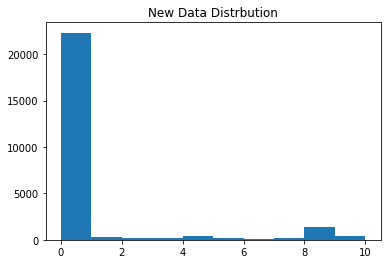

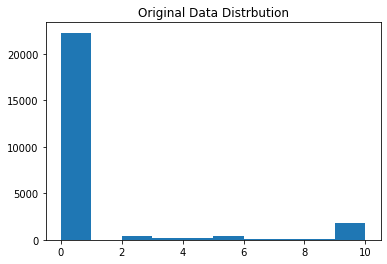

Adaptive model classifier evaluations
First 90000 Evaluation
Model accuracy score for incoming stream: 0.8831168831168831
F1 score for incoming streams: 0.8745731225410674
recall score for incoming streams: 0.8831168831168831
precision score for incoming streams: 0.8700345726162375
####################################
Static model classifier evaluations
First 90000 Evaluation
Model accuracy score for incoming stream: 0.98001998001998
F1 score for incoming streams: 0.972577848844174
recall score for incoming streams: 0.98001998001998
precision score for incoming streams: 0.9673007640741877
####################################
0:	learn: 1.5608162	total: 537ms	remaining: 2.15s
1:	learn: 1.2515198	total: 1.1s	remaining: 1.65s
2:	learn: 1.0533368	total: 1.65s	remaining: 1.1s
3:	learn: 0.9062792	total: 2.2s	remaining: 550ms
4:	learn: 0.7927721	total: 2.75s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


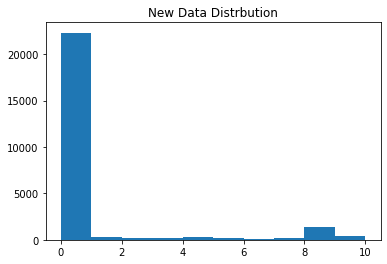

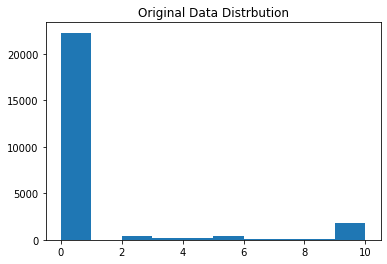

Adaptive model classifier evaluations
First 91000 Evaluation
Model accuracy score for incoming stream: 0.8781218781218781
F1 score for incoming streams: 0.8707416847968802
recall score for incoming streams: 0.8781218781218781
precision score for incoming streams: 0.8668839097410526
####################################
Static model classifier evaluations
First 91000 Evaluation
Model accuracy score for incoming stream: 0.985014985014985
F1 score for incoming streams: 0.9793603959716917
recall score for incoming streams: 0.985014985014985
precision score for incoming streams: 0.9751757363697662
####################################
0:	learn: 1.5522866	total: 537ms	remaining: 2.15s
1:	learn: 1.2496386	total: 1.11s	remaining: 1.67s
2:	learn: 1.0509404	total: 1.67s	remaining: 1.11s
3:	learn: 0.9065229	total: 2.23s	remaining: 559ms
4:	learn: 0.7929627	total: 2.81s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


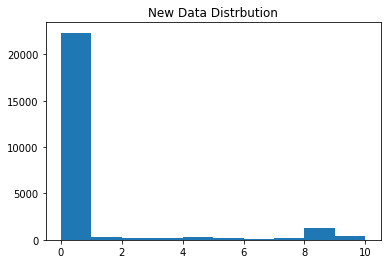

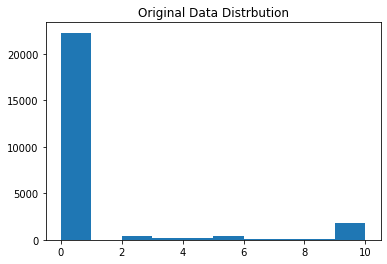

Adaptive model classifier evaluations
First 92000 Evaluation
Model accuracy score for incoming stream: 0.8881118881118881
F1 score for incoming streams: 0.8832309775236834
recall score for incoming streams: 0.8881118881118881
precision score for incoming streams: 0.8822173497498172
####################################
Static model classifier evaluations
First 92000 Evaluation
Model accuracy score for incoming stream: 0.977022977022977
F1 score for incoming streams: 0.9685712932165749
recall score for incoming streams: 0.977022977022977
precision score for incoming streams: 0.9661283882063103
####################################
0:	learn: 1.5609705	total: 535ms	remaining: 2.14s
1:	learn: 1.2536603	total: 1.09s	remaining: 1.63s
2:	learn: 1.0543706	total: 1.65s	remaining: 1.1s
3:	learn: 0.9096328	total: 2.23s	remaining: 557ms
4:	learn: 0.7953239	total: 2.79s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


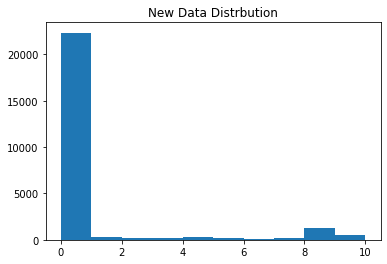

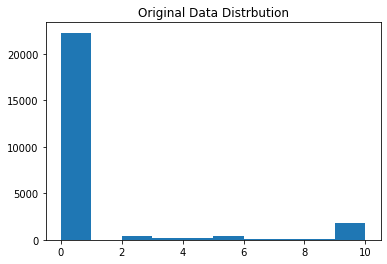

Adaptive model classifier evaluations
First 93000 Evaluation
Model accuracy score for incoming stream: 0.8611388611388612
F1 score for incoming streams: 0.8529876804872618
recall score for incoming streams: 0.8611388611388612
precision score for incoming streams: 0.8493328421466074
####################################
Static model classifier evaluations
First 93000 Evaluation
Model accuracy score for incoming stream: 0.985014985014985
F1 score for incoming streams: 0.9789740078915141
recall score for incoming streams: 0.985014985014985
precision score for incoming streams: 0.9744311595577418
####################################
0:	learn: 1.5562194	total: 545ms	remaining: 2.18s
1:	learn: 1.2539056	total: 1.09s	remaining: 1.64s
2:	learn: 1.0571879	total: 1.65s	remaining: 1.1s
3:	learn: 0.9113023	total: 2.2s	remaining: 551ms
4:	learn: 0.7986045	total: 2.75s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


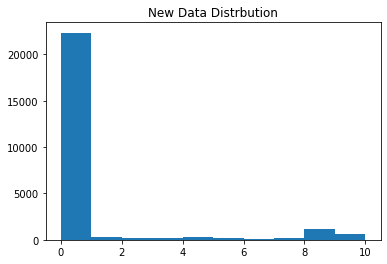

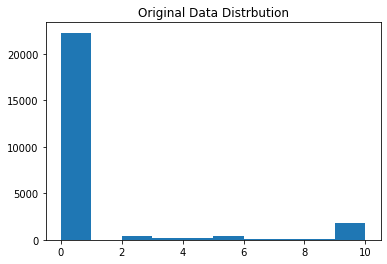

Adaptive model classifier evaluations
First 94000 Evaluation
Model accuracy score for incoming stream: 0.8771228771228772
F1 score for incoming streams: 0.870076633364136
recall score for incoming streams: 0.8771228771228772
precision score for incoming streams: 0.8681347891874207
####################################
Static model classifier evaluations
First 94000 Evaluation
Model accuracy score for incoming stream: 0.981018981018981
F1 score for incoming streams: 0.9744043717867903
recall score for incoming streams: 0.981018981018981
precision score for incoming streams: 0.9706765663422009
####################################
0:	learn: 1.5646812	total: 543ms	remaining: 2.17s
1:	learn: 1.2647957	total: 1.08s	remaining: 1.63s
2:	learn: 1.0644583	total: 1.64s	remaining: 1.09s
3:	learn: 0.9190114	total: 2.19s	remaining: 548ms
4:	learn: 0.8042695	total: 2.73s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


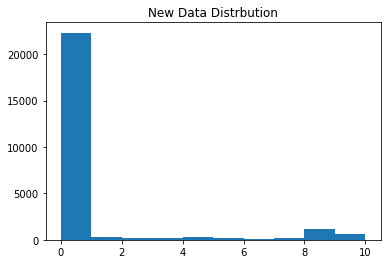

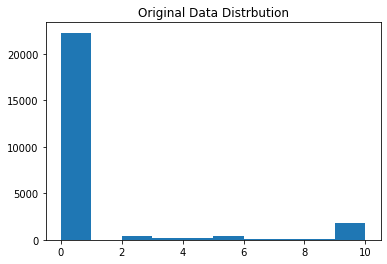

Adaptive model classifier evaluations
First 95000 Evaluation
Model accuracy score for incoming stream: 0.8931068931068931
F1 score for incoming streams: 0.8837319192336061
recall score for incoming streams: 0.8931068931068931
precision score for incoming streams: 0.8786304404948473
####################################
Static model classifier evaluations
First 95000 Evaluation
Model accuracy score for incoming stream: 0.981018981018981
F1 score for incoming streams: 0.9741385964459246
recall score for incoming streams: 0.981018981018981
precision score for incoming streams: 0.9707535850392993
####################################
0:	learn: 1.5606172	total: 538ms	remaining: 2.15s
1:	learn: 1.2586557	total: 1.1s	remaining: 1.65s
2:	learn: 1.0601479	total: 1.64s	remaining: 1.09s
3:	learn: 0.9157097	total: 2.18s	remaining: 545ms
4:	learn: 0.8016173	total: 2.72s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


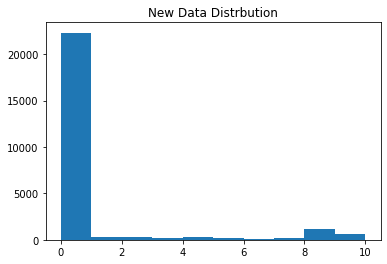

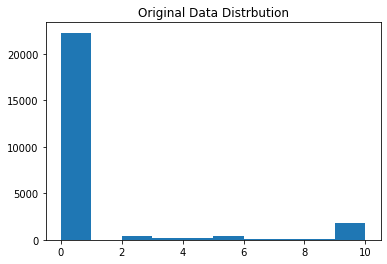

Adaptive model classifier evaluations
First 96000 Evaluation
Model accuracy score for incoming stream: 0.984015984015984
F1 score for incoming streams: 0.9805269528447962
recall score for incoming streams: 0.984015984015984
precision score for incoming streams: 0.9810874947599055
####################################
Static model classifier evaluations
First 96000 Evaluation
Model accuracy score for incoming stream: 0.8601398601398601
F1 score for incoming streams: 0.8591640917222313
recall score for incoming streams: 0.8601398601398601
precision score for incoming streams: 0.8591526120937886
####################################
0:	learn: 1.5597112	total: 541ms	remaining: 2.17s
1:	learn: 1.2548804	total: 1.08s	remaining: 1.61s
2:	learn: 1.0585927	total: 1.63s	remaining: 1.08s
3:	learn: 0.9138815	total: 2.18s	remaining: 546ms
4:	learn: 0.8014016	total: 2.73s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


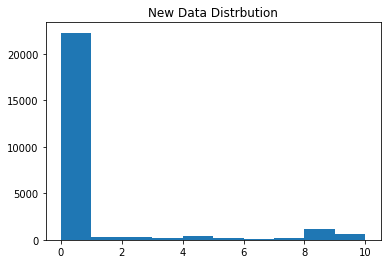

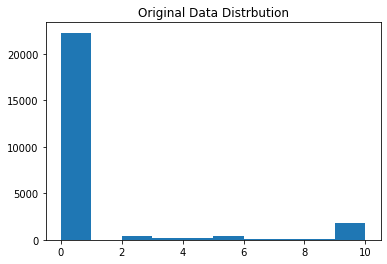

Adaptive model classifier evaluations
First 97000 Evaluation
Model accuracy score for incoming stream: 0.8791208791208791
F1 score for incoming streams: 0.8737778737778737
recall score for incoming streams: 0.8791208791208791
precision score for incoming streams: 0.8718408288544035
####################################
Static model classifier evaluations
First 97000 Evaluation
Model accuracy score for incoming stream: 0.981018981018981
F1 score for incoming streams: 0.9744548621063193
recall score for incoming streams: 0.981018981018981
precision score for incoming streams: 0.9701128999205922
####################################
0:	learn: 1.5668198	total: 546ms	remaining: 2.18s
1:	learn: 1.2631578	total: 1.09s	remaining: 1.64s
2:	learn: 1.0657047	total: 1.63s	remaining: 1.08s
3:	learn: 0.9182725	total: 2.17s	remaining: 542ms
4:	learn: 0.8042764	total: 2.7s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


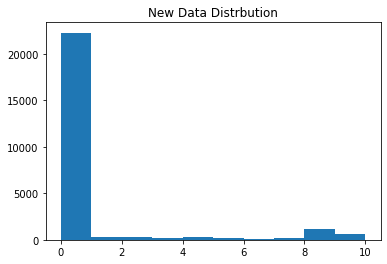

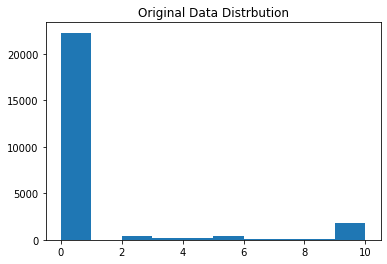

Adaptive model classifier evaluations
First 98000 Evaluation
Model accuracy score for incoming stream: 0.9690309690309691
F1 score for incoming streams: 0.9585593658113726
recall score for incoming streams: 0.9690309690309691
precision score for incoming streams: 0.9556834679944579
####################################
Static model classifier evaluations
First 98000 Evaluation
Model accuracy score for incoming stream: 0.8541458541458542
F1 score for incoming streams: 0.8531695577150122
recall score for incoming streams: 0.8541458541458542
precision score for incoming streams: 0.8531583359169567
####################################
0:	learn: 1.5614246	total: 532ms	remaining: 2.13s
1:	learn: 1.2568012	total: 1.07s	remaining: 1.61s
2:	learn: 1.0592800	total: 1.62s	remaining: 1.08s
3:	learn: 0.9143291	total: 2.15s	remaining: 536ms
4:	learn: 0.8009622	total: 2.71s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################


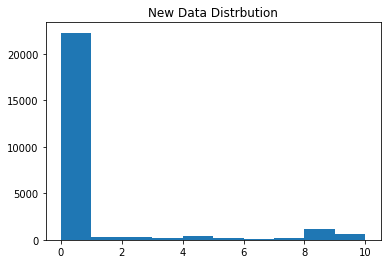

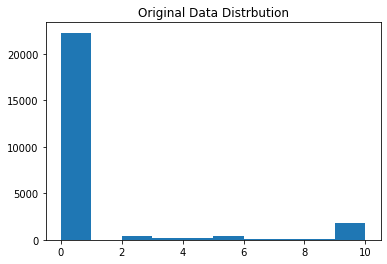

Adaptive model classifier evaluations
First 99000 Evaluation
Model accuracy score for incoming stream: 0.8871128871128872
F1 score for incoming streams: 0.8802024500226343
recall score for incoming streams: 0.8871128871128872
precision score for incoming streams: 0.8834850955496117
####################################
Static model classifier evaluations
First 99000 Evaluation
Model accuracy score for incoming stream: 0.981018981018981
F1 score for incoming streams: 0.9744450633494169
recall score for incoming streams: 0.981018981018981
precision score for incoming streams: 0.9704913300286002
####################################
0:	learn: 1.5617664	total: 544ms	remaining: 2.18s
1:	learn: 1.2570455	total: 1.09s	remaining: 1.64s
2:	learn: 1.0597352	total: 1.64s	remaining: 1.09s
3:	learn: 0.9153162	total: 2.17s	remaining: 543ms
4:	learn: 0.8031352	total: 2.72s	remaining: 0us
Make sure the model is fitted to the new data: True
###################################
Shape of final Data (25683, 

In [ ]:
import time
start = time.time()
df_updated = df_copy.copy()

Kafka_Data=pd.DataFrame()
Evaluation_multi = {"accuracies_dynamic": [],"stream_index":[],"f1_scores_dynamic":[],"precision_dynamic":[],"recall_dynamic":[],
              "accuracies_static": [],"f1_scores_static":[],"precision_static":[],"recall_static":[]}
# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer

# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task2',   
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# Data Stream flowing in.
i = 0
for message in consumer:
    
#    print(f"Consuming the {i+1}th data packet!")
    
    data_packet = message.value
    
    #print(data_packet)
    
    
    
    ##############################################
    x=eval(data_packet)
    y=pd.DataFrame(x, index=[0])
    Kafka_Data=Kafka_Data.append(y,ignore_index=True)
    if i in np.arange(1000,100000, 1000):
        batch = pd.DataFrame()
        batch = Kafka_Data.iloc[i-1000:i+1,:]
        batch["Class"] = encoder.fit_transform(batch["Class"])
        batch["Source"] = encoder.fit_transform(batch["Source"])
        df_updated.drop(df_updated.head(1000).index, inplace = True)
        batch.replace([np.inf, -np.inf], np.nan, inplace=True)
        batch.fillna(batch.mean(),inplace= True)
        batch.sort_index(inplace=True)

        X_stream = batch.drop(['Class'], axis=1)
        y_stream = batch["Class"]


        df_updated = df_updated.append(batch)
        df_updated.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_updated.dropna(inplace= True)
        #print(df_updated.head())
        X = df_updated.drop(['Class'], axis=1)
        y = df_updated['Class']
        
        plt.title("New Data Distrbution")
        plt.hist(y)
        plt.show()
        plt.title("Original Data Distrbution")
        plt.hist(y_original)
        plt.show()
        # Predict on the test set results
        stream_prediction_dynamic = cat_ada.predict(X_stream)
        stream_prediction_static = cat_static.predict(X_stream)

  ############################################################################
        Evaluation_multi["accuracies_dynamic"].append(accuracy_score(y_stream,stream_prediction_dynamic))
        Evaluation_multi["f1_scores_dynamic"].append(f1_score(y_stream,stream_prediction_dynamic, average='weighted'))
        Evaluation_multi["recall_dynamic"].append(recall_score(y_stream,stream_prediction_dynamic,average='weighted'))
        Evaluation_multi["precision_dynamic"].append(precision_score(y_stream,stream_prediction_dynamic,average='weighted'))

        Evaluation_multi["accuracies_static"].append(accuracy_score(y_stream,stream_prediction_static))
        Evaluation_multi["f1_scores_static"].append(f1_score(y_stream,stream_prediction_static, average='weighted'))
        Evaluation_multi["recall_static"].append(recall_score(y_stream,stream_prediction_static,average='weighted'))
        Evaluation_multi["precision_static"].append(precision_score(y_stream,stream_prediction_static,average='weighted'))

   
   
        # fit the model to the updated training set


      
        print("Adaptive model classifier evaluations")
        print("First "+ str(i) +" Evaluation")
        print('Model accuracy score for incoming stream:', accuracy_score(y_stream,stream_prediction_dynamic))
        print("F1 score for incoming streams:",f1_score(y_stream,stream_prediction_dynamic, average='weighted'))
        print("recall score for incoming streams:",recall_score(y_stream,stream_prediction_dynamic,average="weighted"))
        print("precision score for incoming streams:",precision_score(y_stream,stream_prediction_dynamic,average="weighted"))
        print("####################################")
        print("Static model classifier evaluations")
        print("First "+ str(i) +" Evaluation")
        print('Model accuracy score for incoming stream:', accuracy_score(y_stream,stream_prediction_static))
        print("F1 score for incoming streams:",f1_score(y_stream,stream_prediction_static, average='weighted'))
        print("recall score for incoming streams:",recall_score(y_stream,stream_prediction_static,average="weighted"))
        print("precision score for incoming streams:",precision_score(y_stream,stream_prediction_static,average="weighted"))
        print("####################################")


        
        Evaluation_multi["stream_index"].append(i)
        cat_ada = CatBoostClassifier(iterations=5, learning_rate=0.1, random_state=0).fit(X, y)
        
        print("Make sure the model is fitted to the new data:",cat_ada.is_fitted())
        print("###################################")



    ##############################################
    if i == 100000:
        # save the model to disk
        filename = 'finalized_catboost.sav'
        pickle.dump(cat_ada, open(filename, 'wb'))
        print("Shape of final Data", df_updated.shape)
        break
    i+=1

end = time.time()
print("Training 100000 stream took:", (end-start)/60)

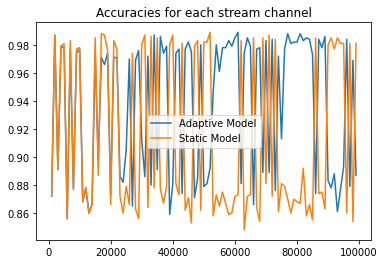

<Figure size 1440x1440 with 0 Axes>

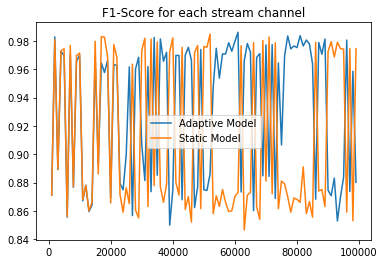

<Figure size 1440x1440 with 0 Axes>

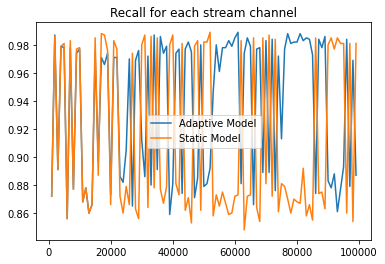

<Figure size 1440x1440 with 0 Axes>

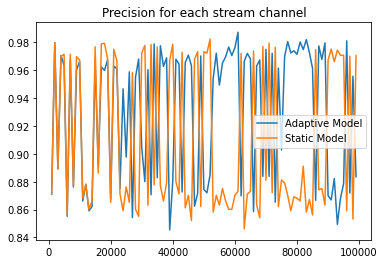

<Figure size 1440x1440 with 0 Axes>

In [ ]:
plt.title("Accuracies for each stream channel")
plt.plot(Evaluation_multi["stream_index"],Evaluation_multi["accuracies_dynamic"], label = "Adaptive Model")
plt.plot(Evaluation_multi["stream_index"],Evaluation_multi["accuracies_static"], label = "Static Model")
plt.legend()
plt.figure(figsize=(20,20));
plt.show()
plt.title("F1-Score for each stream channel")
plt.plot(Evaluation_multi["stream_index"],Evaluation_multi["f1_scores_dynamic"], label = "Adaptive Model")
plt.plot(Evaluation_multi["stream_index"],Evaluation_multi["f1_scores_static"], label = "Static Model")
plt.legend()
plt.figure(figsize=(20,20));
plt.show()
plt.title("Recall for each stream channel")
plt.plot(Evaluation_multi["stream_index"],Evaluation_multi["recall_dynamic"], label = "Adaptive Model")
plt.plot(Evaluation_multi["stream_index"],Evaluation_multi["recall_static"], label = "Static Model")
plt.legend()
plt.figure(figsize=(20,20));
plt.show()
plt.title("Precision for each stream channel")
plt.plot(Evaluation_multi["stream_index"],Evaluation_multi["precision_dynamic"], label = "Adaptive Model")
plt.plot(Evaluation_multi["stream_index"],Evaluation_multi["precision_static"], label = "Static Model")
plt.legend()
plt.figure(figsize=(20,20));
plt.show()
